In [ ]:
!pip install xgboost lightgbm pandas seaborn scikit-learn optuna expetator cryptography

In [ ]:
!pip install imbalanced-learn

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/ML_DVFS/Modeling and evaluation'
os.chdir(PATH)

Mounted at /content/drive


In [ ]:
from expetator.tools import read_experiment, show_heatmap, add_objectives
from expetator.tools import prune_vectors, mojitos_to_vectors, show_pct_distribution
from expetator.monitors import mojitos
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb
import multiprocessing
#import optuna.integration.lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from random import sample 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def generate_en_features(df):
    df = df.copy()
    cols = set(df.columns)-{'metric','expe','group','target'}
    for col in cols:
        for func in ['mean','std','min','max']:
            temp = df.groupby('expe')[col].agg([func]).rename({func:f"{col}_{func}"},axis=1)
            df = pd.merge(df,temp,on='expe',how='left')
        df[col+'_bin10'] = pd.cut(df[col], bins = 10, labels = False)
        df[col+'_bin100'] = pd.cut(df[col], bins = 100, labels = False)
        #df[col+'_log'] = df[col].apply(lambda row: np.log(1+row))
        #df[col+'log+1'] = (df[col]+1).transform(np.log)
        #df[col+'log(x-min(x)+1)'] = (df[col]-df[col].min()+1) .transform(np.log)
    return df
def generate_aggregations(df):
    df = df.copy()
    for col in set(df.columns)-{'metric','expe','freq','group','target'}:
        for func in ['mean','std','min','max']:
          temp = vectors.groupby('expe')[col].agg([func]).rename({func:f"{col}_{func}"},axis=1)
          df = pd.merge(df,temp,on='expe',how='left')
    return df
def outlierdrop(df,factor):
    for col in set(df.columns) - {'metric','expe','freq','group','target'}:
        upper_lim = df[col].mean () + df[col].std () * factor
        lower_lim = df[col].mean () - df[col].std () * factor
        df = df[(df[col] < upper_lim) & (df[col] > lower_lim)]
    return df
def outlierfill(df):
    for column in set(df.columns) - {'metric','expe','freq','group','target'}:
        upper_lim = df[column].quantile(.95)
        lower_lim = df[column].quantile(0.05)
        df.loc[(df[column] > upper_lim),column] = upper_lim
        df.loc[(df[column] < lower_lim),column] = lower_lim
    return df
all_knowledge = pd.read_csv("../csvs/knowledge_allmetrics.csv")
all_vectors = pd.read_csv("../csvs/vectors_allmetrics.csv")
all_vectors['typedata'] = 0

all_knowledge_old = pd.read_csv("../csvs/old/knowledge_allmetrics.csv")
all_vectors_old = pd.read_csv("../csvs/old/vectors_allmetrics.csv")
all_knowledge_old['expe'] = all_knowledge_old['expe'] + all_knowledge.expe.values[-1] + 1
all_vectors_old['typedata'] = 1

all_knowledge = pd.concat([all_knowledge, all_knowledge_old],ignore_index=True)
all_vectors = pd.concat([all_vectors, all_vectors_old],ignore_index=True)

# merge knowlage to vectors => data for training 
all_vectors['expe'] = all_knowledge.expe
all_vectors['target'] = all_knowledge['target']

ignore_columns = ['irxp', 'irxb','itxp', 'itxb', 'core0','core1','bpf_output',
                 'alignment_faults','page_faults_maj','dummy','emulation_faults','nice',
                 'irq','steal','guest','guest_nice']
all_vectors = all_vectors.loc[:,~ all_vectors.columns.isin(ignore_columns)]
all_vectors_outlier = outlierfill(all_vectors)
vectorbin = generate_en_features(all_vectors_outlier)
vectors = prune_vectors(vectorbin)


ignore_columns = ['typedata','expe','group','target','Kfold', #'guest', 'guest_nice', 'irq',
                  #'steal','nice','emulation_faults','irxp', 'irxb', 
                  #'itxp', 'itxb', 'core0','core1','iowait','softirq','txp',
                 ]

# convert categories to numerical
metric_mapping = {
    "energy":0,
    "duration":1,
    "etp":2
}
vectors['metric'] = all_knowledge['metric'].map(metric_mapping)
labels = [1200000,
     1300000,
     1400000,
     1500000,
     1600000,
     1700000,
     1800000,
     1900000,
     2000000,
     2100000,
     2200000,
     2300000,
     2400000]
vectors['target'] = vectors.target.apply(lambda row: labels.index(row))

#split dataset to train, test: 0.8:0.2. Note that split base on expe
testidx = []
exps = list(set(vectors[vectors['typedata'] == 1].expe))
testidx.extend(sample(exps, int(0.2*len(exps))))

exps = list(set(vectors[vectors['typedata'] == 0].expe))
testidx.extend(sample(exps, int(0.2*len(exps))))

train = vectors[~vectors.expe.isin(testidx)].reset_index(drop=True)
test = vectors[vectors.expe.isin(testidx)].reset_index(drop=True)

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [ ]:
def lgb_f1mse_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat) + 2*mean_squared_error(y_true,y_hat), True
metric_list=['merror']
earlyStop=30
def optimize(trial):
    boosting_list = ['gbdt','goss']
    objective_list_reg = ['huber', 'gamma', 'fair', 'tweedie']
    objective_list_class = ['multiclass','multiclassova']
    param={
      'num_class':13,
      'boosting':trial.suggest_categorical('boosting',boosting_list),
      'num_leaves':trial.suggest_int('num_leaves', 2, 2**11),
      'max_depth':trial.suggest_int('max_depth', 2, 25),
      'max_bin': trial.suggest_int('max_bin', 32, 255),      
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 256),
      'min_data_in_bin': trial.suggest_int('min_data_in_bin', 1, 256),
      'min_gain_to_split' : trial.suggest_discrete_uniform('min_gain_to_split', 0.1, 5, 0.01),      
      'lambda_l1':trial.suggest_loguniform('lamda_l1',1e-8,10),
      'lambda_l2':trial.suggest_loguniform('lamda_l2',1e-8,10),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
      'metric':trial.suggest_categorical('metric', ['multi_logloss','multi_error']),#'multi_logloss','multi_error'
      'objective':trial.suggest_categorical('objective',objective_list_class),
      'bagging_fraction':trial.suggest_discrete_uniform('bagging_fraction',0.5, 1, 0.01),
      'feature_fraction':trial.suggest_discrete_uniform('feature_fraction',0.5, 1, 0.01),
      'num_threads': multiprocessing.cpu_count(),
      'verbose':-1,
      #'is_unbalance':'true',
      #'class_weight':class_weight_dict
        
    }
    
    
    accuracies = []
    skf = GroupKFold(n_splits=5)
    train['group'] = train.apply(lambda row: str(row['expe']) + str(row['metric'])+str(row['typedata']),axis = 1)
    test_pro = []
    for i, (train_index, test_index) in enumerate(skf.split(train, train.target, groups = train['group'])):
        xtrain_fold = train.loc[train_index, ~train.columns.isin(ignore_columns)]
        ytrain_fold = train.loc[train_index,'target']
        X_val_fold = train.loc[test_index, ~train.columns.isin(ignore_columns)]
        y_val_fold = train.loc[test_index,'target']
        

        df_Ytrain = ytrain_fold.reset_index(drop=True)
        df_Yval = y_val_fold.reset_index(drop=True)

        sc = StandardScaler()
        df_train = sc.fit_transform(xtrain_fold)
        df_val = sc.transform(X_val_fold)
    
        #over = SMOTE()
        #under = RandomUnderSampler()
        #steps = [('u', under)]#('o', over), 
        #pipeline = Pipeline(steps=steps)
        #xthang, ythang = pipeline.fit_resample(df_train, df_Ytrain)

        #df_Xtrain_sc = pd.DataFrame(xthang,columns = xtrain_fold.columns)
        df_Xtrain_sc = pd.DataFrame(df_train,columns = xtrain_fold.columns)
        df_Xval_sc = pd.DataFrame(df_val,columns = X_val_fold.columns)

        
        dtrain = lgb.Dataset(df_Xtrain_sc,label=df_Ytrain)
        dval = lgb.Dataset(df_Xval_sc,label=df_Yval)
        watchlist = [dtrain,dval]
        lgbmPruningCallback = optuna.integration.LightGBMPruningCallback(trial, 'rmse', valid_name='valid_2')

        model = lgb.train(param,train_set=dtrain,num_boost_round=1000,valid_sets=watchlist,verbose_eval=-1,early_stopping_rounds=earlyStop)#callbacks=[lgbmPruningCallback]
        #bst = lgb.train(param, dtrain)
        #preds = bst.predict(dval)
        pred_val=model.predict(df_Xval_sc,num_iteration=model.best_iteration)
        
        df_Yval = y_val_fold.reset_index(drop=True)
        preds = np.argmax(pred_val,axis = 1)
        accuracy = accuracy_score(df_Yval, preds)
        print(f"                                                                                  FOLD{i}-val acc: {(accuracy * 100.0)}", end=' ')
        
        accuracies.append(accuracy)
        
        X_test = test.loc[:, ~test.columns.isin(ignore_columns)]
        df_Xtest = sc.transform(X_test)
        df_Xtest_sc = pd.DataFrame(df_Xtest,columns = X_test.columns)
        y_test = test.target.reset_index(drop=True)
        pred_val=model.predict(df_Xtest_sc,num_iteration=model.best_iteration)
        
        #dtest = lgb.Dataset(df_Xtest_sc,label=y_test)
        test_pro.append(pred_val)
        #preds = bst.predict(dtest)
        preds = np.argmax(pred_val,axis = 1)
        accuracy = accuracy_score(y_test, preds)
        print(f" FOLD{i}-test acc: {(accuracy * 100.0)}")
    test_pro_mean = np.mean(test_pro,axis=0)
    preds = np.argmax(test_pro_mean,axis = 1)
    accuracy = accuracy_score(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    mse_fre = mean_squared_error([labels[i] for i in y_test], [labels[i] for i in preds])
    print(f"=====================> TTA on test acc: {(accuracy * 100.0)}, mse: {mse} ~ {mse_fre}")
    
    if accuracy > 0.77:
      print(classification_report(y_test, preds))
      cfm = confusion_matrix(y_test, preds, labels = range(0,13))
      cm = cfm
      cfm = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis]
      tmplabel = [i//100000 for i in labels]
      annot = np.empty_like(cfm).astype(str)
      nrows, ncols = cfm.shape
      for i in range(nrows):
          for j in range(ncols):
              c = cfm[i, j]*100
              if c == 0:
                  annot[i, j] = ''
              else:
                annot[i, j] = '%.1f%%\n%d' % (c,cm[i, j])
      plt.figure(figsize=(12,10))
      ax = sns.heatmap(cfm, annot=annot, fmt='',cmap="YlGnBu")
      ax.set_xticklabels(tmplabel)
      ax.set_yticklabels(tmplabel)
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.show()       
        
    return -1.0*np.mean(accuracies)

[I 2021-01-15 10:14:27,054] A new study created in memory with name: no-name-aec91a8a-1d06-4116-a2af-86e00af94f53


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.240748	valid_1's multi_logloss: 0.624381
                                                                                  FOLD0-val acc: 79.77883096366509  FOLD0-test acc: 77.2943414170233
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.238111	valid_1's multi_logloss: 0.697763
                                                                                  FOLD1-val acc: 78.16943127962085  FOLD1-test acc: 77.43699476937708
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.237625	valid_1's multi_logloss: 0.65441
                                                                                  FOLD2-val acc: 79.66837741808132  FOLD2-test acc: 77.389443651

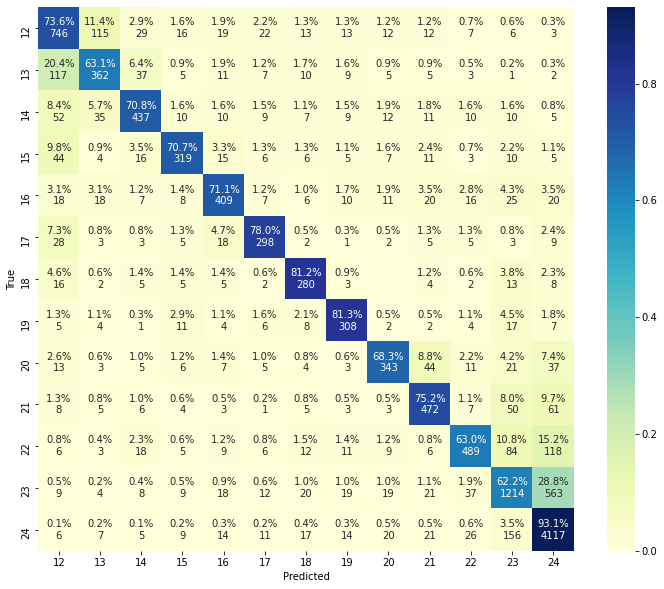

[I 2021-01-15 10:33:34,226] Trial 0 finished with value: -0.7952014917163758 and parameters: {'boosting': 'goss', 'num_leaves': 1338, 'max_depth': 17, 'max_bin': 176, 'min_data_in_leaf': 89, 'min_data_in_bin': 255, 'min_gain_to_split': 3.0900000000000003, 'lamda_l1': 1.5782563836363194e-05, 'lamda_l2': 0.008419295362831437, 'learning_rate': 0.010242246338665486, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.97, 'feature_fraction': 0.77}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[587]	training's multi_logloss: 0.474253	valid_1's multi_logloss: 0.805168
                                                                                  FOLD0-val acc: 78.14968404423381  FOLD0-test acc: 76.11348866698367
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[588]	training's multi_logloss: 0.477016	valid_1's multi_logloss: 0.854423
                                                                                  FOLD1-val acc: 77.40916271721959  FOLD1-test acc: 76.28784276430495
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[564]	training's multi_logloss: 0.476233	valid_1's multi_logloss: 0.859411
                                                                                  FOLD2-val acc: 77.45756020529016  FOLD2-test acc: 75.71722935488984
Training until validation scores d

[I 2021-01-15 10:48:04,315] Trial 1 finished with value: -0.7752444692203555 and parameters: {'boosting': 'gbdt', 'num_leaves': 644, 'max_depth': 13, 'max_bin': 226, 'min_data_in_leaf': 243, 'min_data_in_bin': 196, 'min_gain_to_split': 4.91, 'lamda_l1': 1.969473743056533, 'lamda_l2': 6.239173257931466, 'learning_rate': 0.016684218540364216, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.95, 'feature_fraction': 0.79}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[130]	training's multi_error: 0.0841168	valid_1's multi_error: 0.225217
                                                                                  FOLD0-val acc: 77.47827804107425  FOLD0-test acc: 76.04216199080679
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[231]	training's multi_error: 0.0746663	valid_1's multi_error: 0.22887
                                                                                  FOLD1-val acc: 77.1129541864139  FOLD1-test acc: 76.04216199080679
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[278]	training's multi_error: 0.0702564	valid_1's multi_error: 0.226017
                                                                                  FOLD2-val acc: 77.39834188709041  FOLD2-test acc: 75.87573307972737
Training until validation scores don't improv

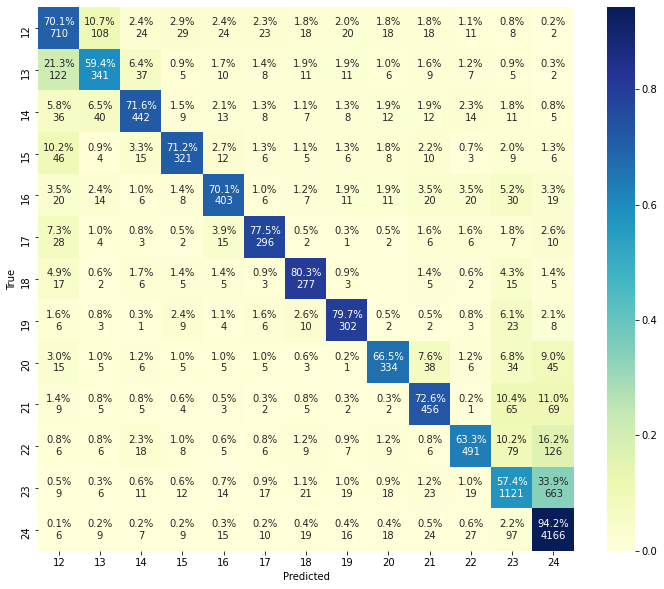

[I 2021-01-15 10:58:00,009] Trial 2 finished with value: -0.7740595316670371 and parameters: {'boosting': 'gbdt', 'num_leaves': 1820, 'max_depth': 17, 'max_bin': 168, 'min_data_in_leaf': 84, 'min_data_in_bin': 100, 'min_gain_to_split': 4.72, 'lamda_l1': 7.916535370246302e-05, 'lamda_l2': 0.09066165964660859, 'learning_rate': 0.020308339524285655, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.5700000000000001, 'feature_fraction': 0.95}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's multi_error: 0.657068	valid_1's multi_error: 0.65235
                                                                                  FOLD0-val acc: 34.765007898894154  FOLD0-test acc: 35.05309874782057
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's multi_error: 0.657562	valid_1's multi_error: 0.650375
                                                                                  FOLD1-val acc: 34.962480252764614  FOLD1-test acc: 35.05309874782057
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[1]	training's multi_error: 0.652716	valid_1's multi_error: 0.669759
                                                                                  FOLD2-val acc: 33.0240821160679  FOLD2-test acc: 35.05309874782057
Training until validation scores don't improve for 3

[I 2021-01-15 10:59:23,126] Trial 3 finished with value: -0.3438760342243056 and parameters: {'boosting': 'gbdt', 'num_leaves': 660, 'max_depth': 12, 'max_bin': 204, 'min_data_in_leaf': 105, 'min_data_in_bin': 20, 'min_gain_to_split': 1.36, 'lamda_l1': 0.0015807676029815896, 'lamda_l2': 4.464401137989228, 'learning_rate': 0.006259220380055072, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.95, 'feature_fraction': 0.54}. Best is trial 0 with value: -0.7952014917163758.


Early stopping, best iteration is:
[1]	training's multi_error: 0.655923	valid_1's multi_error: 0.656931
                                                                                  FOLD4-val acc: 34.30685742476566  FOLD4-test acc: 35.05309874782057
=====================> TTA on test acc: 35.05309874782057, mse: 32.47035980345538
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.402729	valid_1's multi_logloss: 0.796515
                                                                                  FOLD0-val acc: 78.51500789889415  FOLD0-test acc: 76.26406720557934
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[120]	training's multi_logloss: 0.41275	valid_1's multi_logloss: 0.851406
                                                                                  FOLD1-val acc: 77.15244865718799  FOLD1-test acc: 75.99461087335553
Training until valida

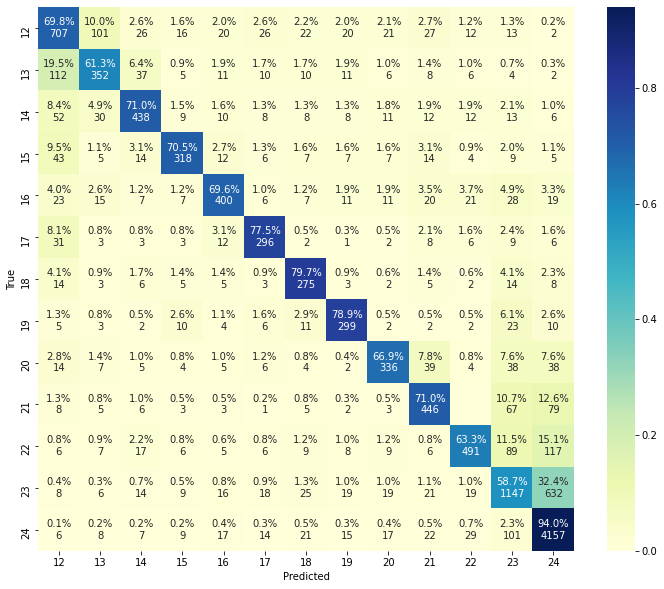

[I 2021-01-15 11:02:16,263] Trial 4 finished with value: -0.7783630416672354 and parameters: {'boosting': 'gbdt', 'num_leaves': 320, 'max_depth': 18, 'max_bin': 179, 'min_data_in_leaf': 178, 'min_data_in_bin': 56, 'min_gain_to_split': 4.93, 'lamda_l1': 0.00024419732568765337, 'lamda_l2': 0.0015625570809126809, 'learning_rate': 0.07479488155340272, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.99, 'feature_fraction': 0.6}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[330]	training's multi_logloss: 0.424604	valid_1's multi_logloss: 0.811454
                                                                                  FOLD0-val acc: 78.23854660347551  FOLD0-test acc: 76.29576795054683
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[325]	training's multi_logloss: 0.426192	valid_1's multi_logloss: 0.853385
                                                                                  FOLD1-val acc: 77.43878357030016  FOLD1-test acc: 75.96291012838802
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[335]	training's multi_logloss: 0.427667	valid_1's multi_logloss: 0.856306
                                                                                  FOLD2-val acc: 77.15159889459139  FOLD2-test acc: 75.48739895387541
Training until validation scores d

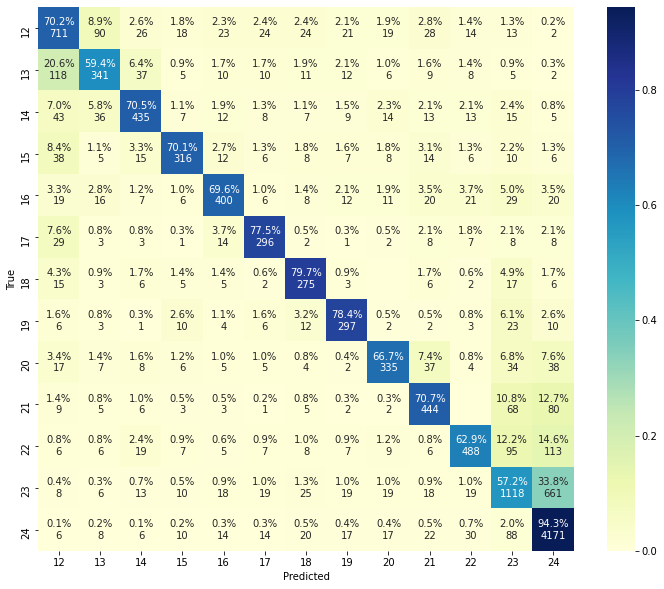

[I 2021-01-15 11:11:08,160] Trial 5 finished with value: -0.7764681801398694 and parameters: {'boosting': 'gbdt', 'num_leaves': 1537, 'max_depth': 24, 'max_bin': 191, 'min_data_in_leaf': 207, 'min_data_in_bin': 242, 'min_gain_to_split': 4.8999999999999995, 'lamda_l1': 2.6560742179506e-07, 'lamda_l2': 1.902257070329164, 'learning_rate': 0.02510355217903089, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.62, 'feature_fraction': 0.77}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[10]	training's multi_error: 0.0951464	valid_1's multi_error: 0.254344
                                                                                  FOLD0-val acc: 74.57543443917851  FOLD0-test acc: 71.4455539705183
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[15]	training's multi_error: 0.0742468	valid_1's multi_error: 0.255233
                                                                                  FOLD1-val acc: 74.48657187993682  FOLD1-test acc: 70.93834205103819
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[10]	training's multi_error: 0.094761	valid_1's multi_error: 0.253158
                                                                                  FOLD2-val acc: 74.72364784840111  FOLD2-test acc: 72.58678078934855
Training until validation scores don't improve f

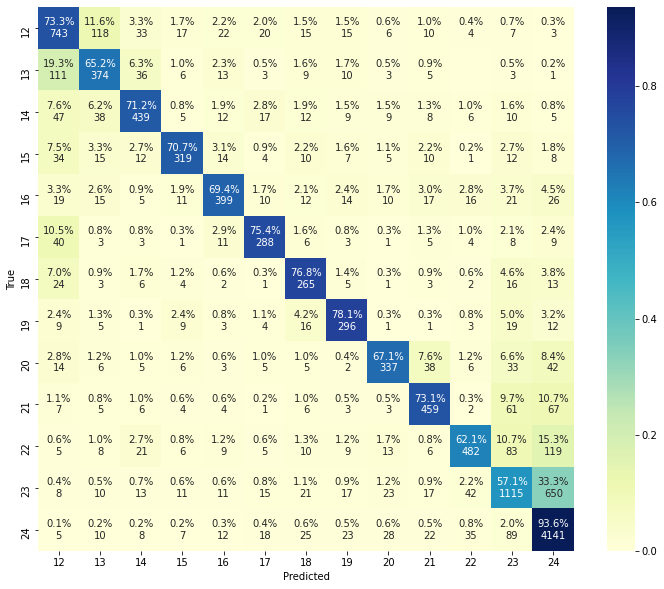

[I 2021-01-15 11:12:33,577] Trial 6 finished with value: -0.746796519270468 and parameters: {'boosting': 'gbdt', 'num_leaves': 1325, 'max_depth': 9, 'max_bin': 99, 'min_data_in_leaf': 121, 'min_data_in_bin': 250, 'min_gain_to_split': 2.06, 'lamda_l1': 1.5945437502566402e-05, 'lamda_l2': 0.011574820201273359, 'learning_rate': 0.4559245016258399, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.96, 'feature_fraction': 0.99}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[513]	training's multi_error: 0.133516	valid_1's multi_error: 0.21564
                                                                                  FOLD0-val acc: 78.43601895734598  FOLD0-test acc: 76.96148359486448
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[372]	training's multi_error: 0.165347	valid_1's multi_error: 0.237954
                                                                                  FOLD1-val acc: 76.20458135860979  FOLD1-test acc: 76.45427167538436
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[739]	training's multi_error: 0.103003	valid_1's multi_error: 0.208942
                                                                                  FOLD2-val acc: 79.10580339518357  FOLD2-test acc: 76.92978284989698
Training until validation scores don't improve 

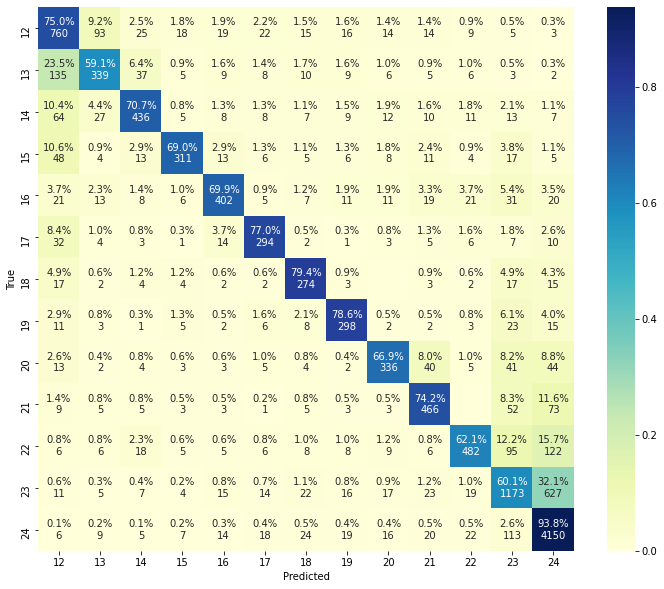

[I 2021-01-15 11:23:00,529] Trial 7 finished with value: -0.7752442642162782 and parameters: {'boosting': 'gbdt', 'num_leaves': 498, 'max_depth': 5, 'max_bin': 54, 'min_data_in_leaf': 115, 'min_data_in_bin': 122, 'min_gain_to_split': 2.9000000000000004, 'lamda_l1': 1.9130177733142661e-07, 'lamda_l2': 0.00016992164277230342, 'learning_rate': 0.015785357684607156, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.67, 'feature_fraction': 0.5700000000000001}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.708352	valid_1's multi_logloss: 0.848244
                                                                                  FOLD0-val acc: 75.6022906793049  FOLD0-test acc: 74.7107307021715
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.706926	valid_1's multi_logloss: 0.891729
                                                                                  FOLD1-val acc: 74.31872037914692  FOLD1-test acc: 74.99603740687905
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.703063	valid_1's multi_logloss: 0.883051
                                                                                  FOLD2-val acc: 75.03947887879984  FOLD2-test acc: 74.789982564

[I 2021-01-15 11:40:00,848] Trial 8 finished with value: -0.7502708772625285 and parameters: {'boosting': 'gbdt', 'num_leaves': 551, 'max_depth': 3, 'max_bin': 46, 'min_data_in_leaf': 143, 'min_data_in_bin': 140, 'min_gain_to_split': 3.44, 'lamda_l1': 0.11189036089037795, 'lamda_l2': 0.0012128451933842085, 'learning_rate': 0.008744239622712325, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.63, 'feature_fraction': 0.56}. Best is trial 0 with value: -0.7952014917163758.


 FOLD4-test acc: 74.73450626089712
=====================> TTA on test acc: 74.90886035821842, mse: 5.2685845617372005
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[414]	training's multi_logloss: 0.425141	valid_1's multi_logloss: 0.790606
                                                                                  FOLD0-val acc: 78.84083728278041  FOLD0-test acc: 76.41464574417499
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[424]	training's multi_logloss: 0.430013	valid_1's multi_logloss: 0.838167
                                                                                  FOLD1-val acc: 77.87322274881517  FOLD1-test acc: 76.14518941195118
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[415]	training's multi_logloss: 0.422215	valid_1's multi_logloss: 0.833556
                                                                  

[I 2021-01-15 11:50:16,179] Trial 9 finished with value: -0.7819564518556081 and parameters: {'boosting': 'gbdt', 'num_leaves': 1953, 'max_depth': 8, 'max_bin': 201, 'min_data_in_leaf': 66, 'min_data_in_bin': 8, 'min_gain_to_split': 2.8400000000000003, 'lamda_l1': 5.259519743093454, 'lamda_l2': 0.0021966462816069153, 'learning_rate': 0.02753097397952021, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.6, 'feature_fraction': 0.77}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[426]	training's multi_logloss: 0.178829	valid_1's multi_logloss: 0.65617
                                                                                  FOLD0-val acc: 79.03830963665087  FOLD0-test acc: 77.09621176097639
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[472]	training's multi_logloss: 0.17686	valid_1's multi_logloss: 0.672525
                                                                                  FOLD1-val acc: 78.89020537124803  FOLD1-test acc: 76.83468061499445
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[396]	training's multi_logloss: 0.17576	valid_1's multi_logloss: 0.67562
                                                                                  FOLD2-val acc: 78.08922226608765  FOLD2-test acc: 76.27991757806308
Training until validation scores don't

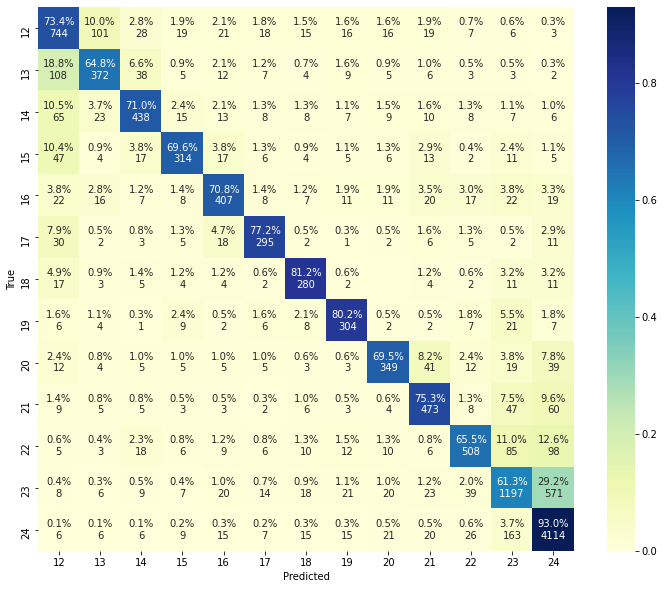

[I 2021-01-15 11:54:34,832] Trial 10 finished with value: -0.7854910859340167 and parameters: {'boosting': 'goss', 'num_leaves': 1081, 'max_depth': 25, 'max_bin': 104, 'min_data_in_leaf': 3, 'min_data_in_bin': 194, 'min_gain_to_split': 3.72, 'lamda_l1': 1.058769029001153e-08, 'lamda_l2': 3.493397129398307e-07, 'learning_rate': 0.11386999228768037, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.88}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[352]	training's multi_logloss: 0.185085	valid_1's multi_logloss: 0.644383
                                                                                  FOLD0-val acc: 79.2259083728278  FOLD0-test acc: 77.21508955460453
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[420]	training's multi_logloss: 0.182131	valid_1's multi_logloss: 0.682021
                                                                                  FOLD1-val acc: 78.76184834123224  FOLD1-test acc: 76.73957838009193
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[292]	training's multi_logloss: 0.184287	valid_1's multi_logloss: 0.672862
                                                                                  FOLD2-val acc: 78.67153572838531  FOLD2-test acc: 76.85845617372009
Training until validation scores do

[I 2021-01-15 11:58:40,744] Trial 11 finished with value: -0.7889645728900894 and parameters: {'boosting': 'goss', 'num_leaves': 1082, 'max_depth': 24, 'max_bin': 115, 'min_data_in_leaf': 5, 'min_data_in_bin': 201, 'min_gain_to_split': 3.75, 'lamda_l1': 2.939945605230608e-08, 'lamda_l2': 2.2716692060503866e-07, 'learning_rate': 0.11023966193786537, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.8, 'feature_fraction': 0.88}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[12]	training's multi_logloss: 0.440403	valid_1's multi_logloss: 0.896958
                                                                                  FOLD0-val acc: 73.93364928909952  FOLD0-test acc: 73.6883816769694
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[235]	training's multi_logloss: 0.185419	valid_1's multi_logloss: 0.704388
                                                                                  FOLD1-val acc: 77.90284360189574  FOLD1-test acc: 75.47947376763354
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[125]	training's multi_logloss: 0.199479	valid_1's multi_logloss: 0.727784
                                                                                  FOLD2-val acc: 77.86221871298855  FOLD2-test acc: 75.05943889681407
Training until validation scores don

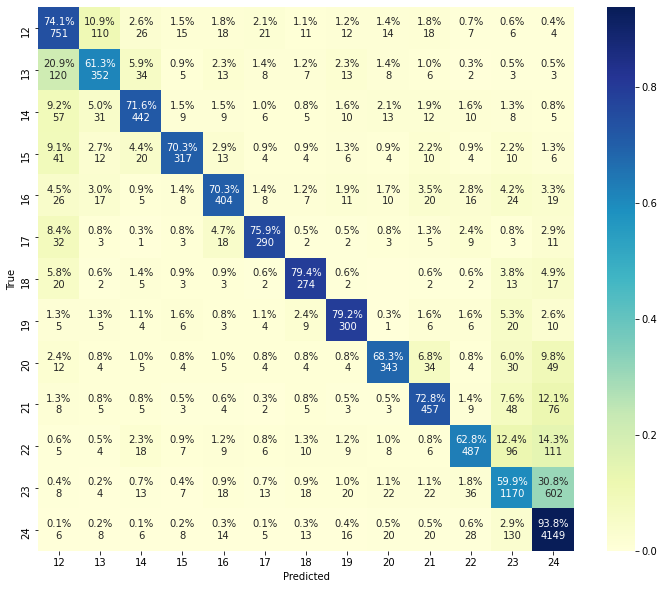

[I 2021-01-15 12:00:42,173] Trial 12 finished with value: -0.771786812718817 and parameters: {'boosting': 'goss', 'num_leaves': 1010, 'max_depth': 21, 'max_bin': 129, 'min_data_in_leaf': 2, 'min_data_in_bin': 205, 'min_gain_to_split': 4.12, 'lamda_l1': 2.036372563335429e-06, 'lamda_l2': 6.159528655351661e-06, 'learning_rate': 0.19771108355504777, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.6799999999999999}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[97]	training's multi_logloss: 0.028878	valid_1's multi_logloss: 0.686227
                                                                                  FOLD0-val acc: 79.8281990521327  FOLD0-test acc: 77.16753843715327
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[27]	training's multi_logloss: 0.10422	valid_1's multi_logloss: 0.74639
                                                                                  FOLD1-val acc: 77.69549763033176  FOLD1-test acc: 76.82675542875258
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[122]	training's multi_logloss: 0.0269572	valid_1's multi_logloss: 0.700942
                                                                                  FOLD2-val acc: 79.94472956968022  FOLD2-test acc: 77.3260421619908
Training until validation scores don't 

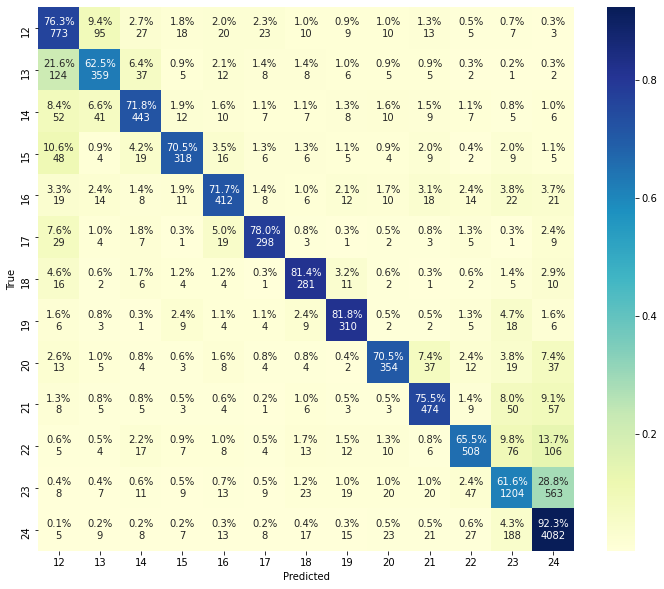

[I 2021-01-15 12:03:43,972] Trial 13 finished with value: -0.7911349722033929 and parameters: {'boosting': 'goss', 'num_leaves': 1515, 'max_depth': 20, 'max_bin': 134, 'min_data_in_leaf': 39, 'min_data_in_bin': 231, 'min_gain_to_split': 0.27, 'lamda_l1': 0.004777200906714464, 'lamda_l2': 1.1486560945097087e-08, 'learning_rate': 0.24069481366974288, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.8500000000000001}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[153]	training's multi_logloss: 0.0499346	valid_1's multi_logloss: 0.687184
                                                                                  FOLD0-val acc: 79.31477093206951  FOLD0-test acc: 76.15311459819306
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[200]	training's multi_logloss: 0.048582	valid_1's multi_logloss: 0.749683
                                                                                  FOLD1-val acc: 78.55450236966824  FOLD1-test acc: 76.08178792201616
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[33]	training's multi_logloss: 0.0654221	valid_1's multi_logloss: 0.728344
                                                                                  FOLD2-val acc: 78.69127516778524  FOLD2-test acc: 76.6841020763988
Training until validation scores d

[I 2021-01-15 12:05:48,507] Trial 14 finished with value: -0.7905828504361988 and parameters: {'boosting': 'goss', 'num_leaves': 1624, 'max_depth': 19, 'max_bin': 148, 'min_data_in_leaf': 50, 'min_data_in_bin': 254, 'min_gain_to_split': 0.62, 'lamda_l1': 0.01081425243452785, 'lamda_l2': 1.8016137831169477e-08, 'learning_rate': 0.4614520899408088, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.87, 'feature_fraction': 0.6799999999999999}. Best is trial 0 with value: -0.7952014917163758.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[197]	training's multi_logloss: 0.0359506	valid_1's multi_logloss: 0.681064
                                                                                  FOLD0-val acc: 79.81832543443917  FOLD0-test acc: 77.07243620225074
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[204]	training's multi_logloss: 0.0356626	valid_1's multi_logloss: 0.738154
                                                                                  FOLD1-val acc: 79.45300157977883  FOLD1-test acc: 76.90600729117133
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[199]	training's multi_logloss: 0.035424	valid_1's multi_logloss: 0.691761
                                                                                  FOLD2-val acc: 80.09277536517962  FOLD2-test acc: 76.86638135996195
Training until validation scores

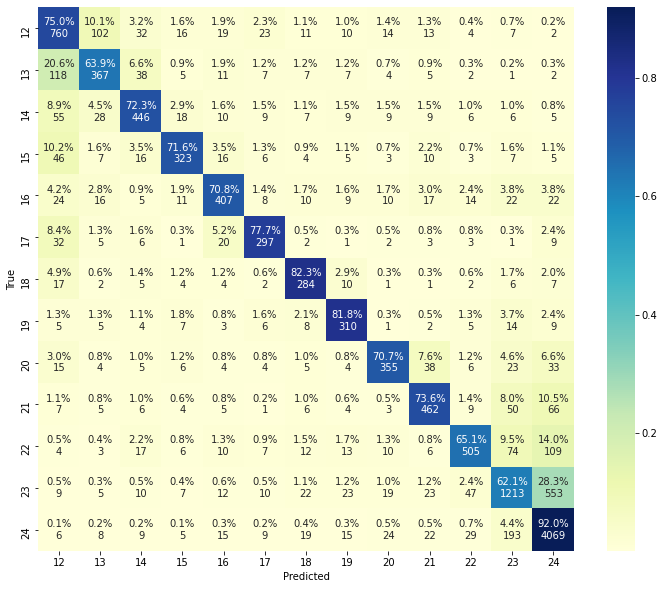

[I 2021-01-15 12:09:05,330] Trial 15 finished with value: -0.7977293423815435 and parameters: {'boosting': 'goss', 'num_leaves': 1366, 'max_depth': 16, 'max_bin': 154, 'min_data_in_leaf': 33, 'min_data_in_bin': 159, 'min_gain_to_split': 0.42000000000000004, 'lamda_l1': 0.012760481815824176, 'lamda_l2': 3.972400214708321e-05, 'learning_rate': 0.27113208228160257, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.72, 'feature_fraction': 0.8500000000000001}. Best is trial 15 with value: -0.7977293423815435.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[756]	training's multi_logloss: 0.133321	valid_1's multi_logloss: 0.612741
                                                                                  FOLD0-val acc: 80.11453396524486  FOLD0-test acc: 77.72230147408465
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.129297	valid_1's multi_logloss: 0.643751
                                                                                  FOLD1-val acc: 79.74921011058453  FOLD1-test acc: 77.25471548581392
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[861]	training's multi_logloss: 0.129815	valid_1's multi_logloss: 0.627006
                                                                                  FOLD2-val acc: 79.8262929332807  FOLD2-test acc: 77.24679029957204
Training until valida

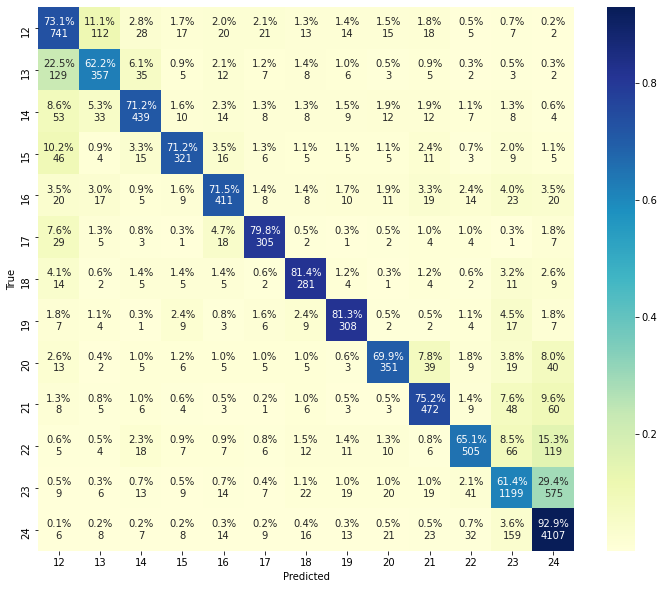

[I 2021-01-15 12:17:51,918] Trial 16 finished with value: -0.7995654903606841 and parameters: {'boosting': 'goss', 'num_leaves': 1309, 'max_depth': 15, 'max_bin': 234, 'min_data_in_leaf': 31, 'min_data_in_bin': 158, 'min_gain_to_split': 2.09, 'lamda_l1': 0.07128482406945728, 'lamda_l2': 3.3139251509026485e-05, 'learning_rate': 0.06271731958952362, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.72, 'feature_fraction': 0.6799999999999999}. Best is trial 16 with value: -0.7995654903606841.


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.131094	valid_1's multi_logloss: 0.610741
                                                                                  FOLD0-val acc: 80.78593996840442  FOLD0-test acc: 77.76985259153591
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.129948	valid_1's multi_logloss: 0.641659
                                                                                  FOLD1-val acc: 79.46287519747234  FOLD1-test acc: 77.19131399587891
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.128529	valid_1's multi_logloss: 0.630647
                                                                                  FOLD2-val acc: 79.8262929332807  FOLD2-test acc: 77.45284514

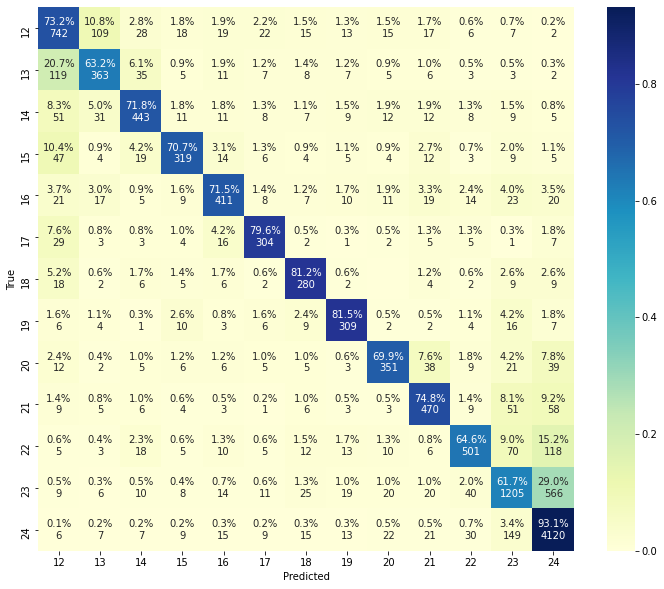

[I 2021-01-15 12:29:36,232] Trial 17 finished with value: -0.7995856331737654 and parameters: {'boosting': 'goss', 'num_leaves': 925, 'max_depth': 15, 'max_bin': 254, 'min_data_in_leaf': 29, 'min_data_in_bin': 153, 'min_gain_to_split': 1.9400000000000002, 'lamda_l1': 0.19700595070186877, 'lamda_l2': 5.587881682882713e-05, 'learning_rate': 0.04039988800340998, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.72, 'feature_fraction': 0.67}. Best is trial 17 with value: -0.7995856331737654.


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.133275	valid_1's multi_logloss: 0.606327
                                                                                  FOLD0-val acc: 80.87480252764612  FOLD0-test acc: 77.62719923918212
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[815]	training's multi_logloss: 0.135013	valid_1's multi_logloss: 0.641307
                                                                                  FOLD1-val acc: 79.71958925750396  FOLD1-test acc: 76.97733396734824
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.131141	valid_1's multi_logloss: 0.618864
                                                                                  FOLD2-val acc: 79.7769443347809  FOLD2-test acc: 77.06451101600888
Trainin

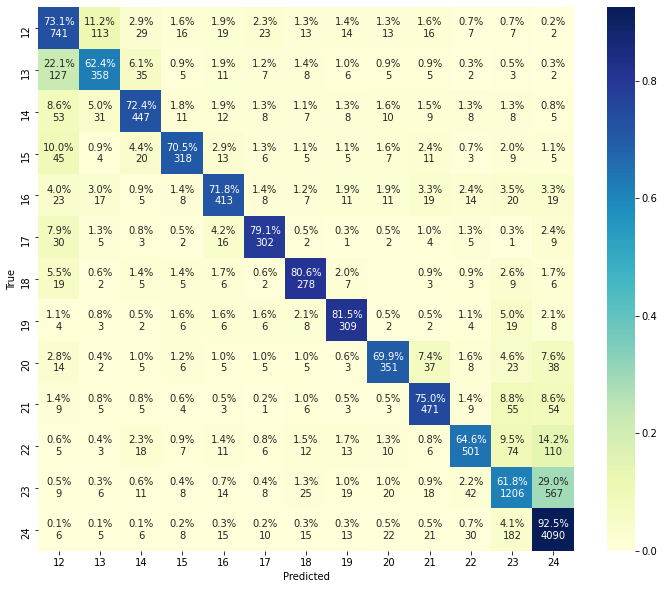

[I 2021-01-15 12:40:18,463] Trial 18 finished with value: -0.8012242386028443 and parameters: {'boosting': 'goss', 'num_leaves': 858, 'max_depth': 11, 'max_bin': 251, 'min_data_in_leaf': 28, 'min_data_in_bin': 90, 'min_gain_to_split': 2.0, 'lamda_l1': 0.2655055001207622, 'lamda_l2': 5.528694153275032e-06, 'learning_rate': 0.047409246816457806, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.74, 'feature_fraction': 0.66}. Best is trial 18 with value: -0.8012242386028443.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[831]	training's multi_logloss: 0.135275	valid_1's multi_logloss: 0.579226
                                                                                  FOLD0-val acc: 81.28949447077409  FOLD0-test acc: 77.01695989855762
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.126914	valid_1's multi_logloss: 0.603752
                                                                                  FOLD1-val acc: 80.97353870458136  FOLD1-test acc: 76.83468061499445
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.125502	valid_1's multi_logloss: 0.589579
                                                                                  FOLD2-val acc: 80.9218318199763  FOLD2-test acc: 77.04073545728325
Trainin

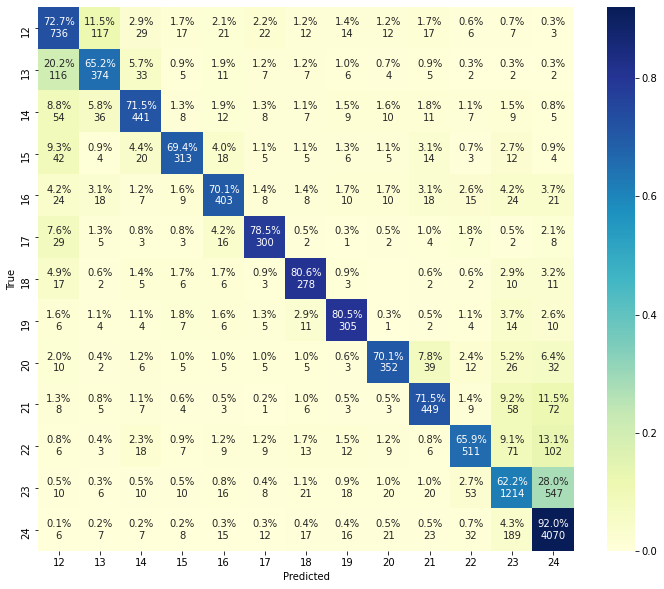

[I 2021-01-15 12:53:59,821] Trial 19 finished with value: -0.8088642283644726 and parameters: {'boosting': 'goss', 'num_leaves': 22, 'max_depth': 9, 'max_bin': 253, 'min_data_in_leaf': 158, 'min_data_in_bin': 69, 'min_gain_to_split': 1.3, 'lamda_l1': 0.4633169865830804, 'lamda_l2': 1.113932118179952e-06, 'learning_rate': 0.039210592762299185, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.51, 'feature_fraction': 0.64}. Best is trial 19 with value: -0.8088642283644726.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[460]	training's multi_error: 0.0835739	valid_1's multi_error: 0.198855
                                                                                  FOLD0-val acc: 80.11453396524486  FOLD0-test acc: 77.35774290695832
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[736]	training's multi_error: 0.0456486	valid_1's multi_error: 0.197867
                                                                                  FOLD1-val acc: 80.2132701421801  FOLD1-test acc: 76.97733396734824
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[623]	training's multi_error: 0.05698	valid_1's multi_error: 0.192756
                                                                                  FOLD2-val acc: 80.7244374259771  FOLD2-test acc: 76.78712949754319
Training until validation scores don't improve 

[I 2021-01-15 13:03:49,002] Trial 20 finished with value: -0.7999409353354373 and parameters: {'boosting': 'goss', 'num_leaves': 10, 'max_depth': 10, 'max_bin': 249, 'min_data_in_leaf': 155, 'min_data_in_bin': 70, 'min_gain_to_split': 1.1400000000000001, 'lamda_l1': 1.7057589055053877, 'lamda_l2': 1.9455947671400847e-06, 'learning_rate': 0.03905912293774665, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.54, 'feature_fraction': 0.64}. Best is trial 19 with value: -0.8088642283644726.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[214]	training's multi_error: 0.0402201	valid_1's multi_error: 0.203594
                                                                                  FOLD0-val acc: 79.64060031595577  FOLD0-test acc: 77.34189253447457
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[290]	training's multi_error: 0.02808	valid_1's multi_error: 0.205964
                                                                                  FOLD1-val acc: 79.40363349131123  FOLD1-test acc: 77.35774290695832
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[207]	training's multi_error: 0.0414333	valid_1's multi_error: 0.202625
                                                                                  FOLD2-val acc: 79.73746545598105  FOLD2-test acc: 77.16753843715327
Training until validation scores don't improv

[I 2021-01-15 13:10:40,242] Trial 21 finished with value: -0.796899738513069 and parameters: {'boosting': 'goss', 'num_leaves': 107, 'max_depth': 10, 'max_bin': 251, 'min_data_in_leaf': 158, 'min_data_in_bin': 66, 'min_gain_to_split': 1.09, 'lamda_l1': 0.9136593608313366, 'lamda_l2': 1.0448699143141726e-06, 'learning_rate': 0.044647948289105586, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.5, 'feature_fraction': 0.62}. Best is trial 19 with value: -0.8088642283644726.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[439]	training's multi_error: 0.108792	valid_1's multi_error: 0.209419
                                                                                  FOLD0-val acc: 79.05805687203792  FOLD0-test acc: 76.90600729117133
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[738]	training's multi_error: 0.0730131	valid_1's multi_error: 0.204581
                                                                                  FOLD1-val acc: 79.54186413902053  FOLD1-test acc: 77.04073545728325
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[521]	training's multi_error: 0.0933791	valid_1's multi_error: 0.201737
                                                                                  FOLD2-val acc: 79.8262929332807  FOLD2-test acc: 76.38294499920748
Training until validation scores don't improv

[I 2021-01-15 13:18:32,532] Trial 22 finished with value: -0.7912546500801709 and parameters: {'boosting': 'goss', 'num_leaves': 10, 'max_depth': 6, 'max_bin': 229, 'min_data_in_leaf': 189, 'min_data_in_bin': 76, 'min_gain_to_split': 1.4700000000000002, 'lamda_l1': 9.662878447906861, 'lamda_l2': 3.2702134623869915e-06, 'learning_rate': 0.03709790013275616, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.5, 'feature_fraction': 0.64}. Best is trial 19 with value: -0.8088642283644726.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[114]	training's multi_error: 0.0334345	valid_1's multi_error: 0.197966
                                                                                  FOLD0-val acc: 80.20339652448656  FOLD0-test acc: 77.45284514186083
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[337]	training's multi_error: 0.0113258	valid_1's multi_error: 0.195498
                                                                                  FOLD1-val acc: 80.45023696682463  FOLD1-test acc: 77.18338880963702
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[316]	training's multi_error: 0.010858	valid_1's multi_error: 0.190387
                                                                                  FOLD2-val acc: 80.96131069877616  FOLD2-test acc: 77.18338880963702
Training until validation scores don't impro

[I 2021-01-15 13:24:03,047] Trial 23 finished with value: -0.8037702874265271 and parameters: {'boosting': 'goss', 'num_leaves': 272, 'max_depth': 11, 'max_bin': 243, 'min_data_in_leaf': 151, 'min_data_in_bin': 38, 'min_gain_to_split': 0.92, 'lamda_l1': 0.41381969380253186, 'lamda_l2': 6.125359308462545e-08, 'learning_rate': 0.08240943394189976, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.54, 'feature_fraction': 0.72}. Best is trial 19 with value: -0.8088642283644726.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[380]	training's multi_error: 0.00710637	valid_1's multi_error: 0.182761
                                                                                  FOLD0-val acc: 81.72393364928911  FOLD0-test acc: 77.53209700427959
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[386]	training's multi_error: 0.00759987	valid_1's multi_error: 0.186809
                                                                                  FOLD1-val acc: 81.31911532385466  FOLD1-test acc: 76.88223173244572
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[269]	training's multi_error: 0.0109814	valid_1's multi_error: 0.195618
                                                                                  FOLD2-val acc: 80.43821555467825  FOLD2-test acc: 77.52417181803773
Training until validation scores don't im

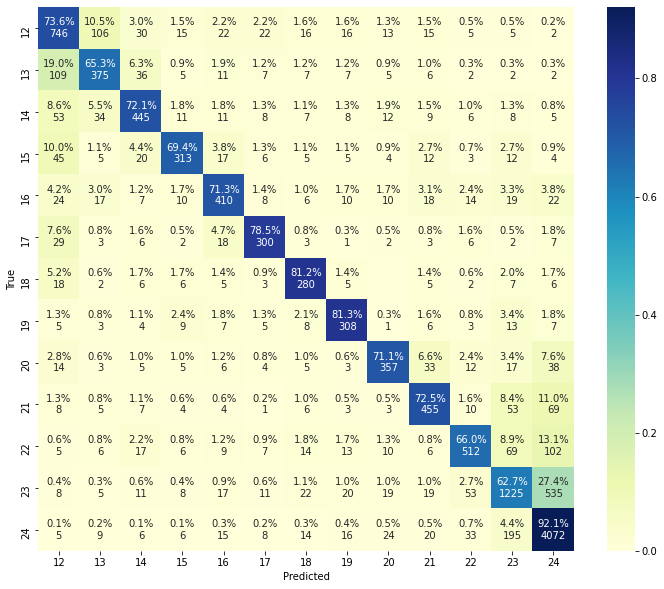

[I 2021-01-15 13:29:56,962] Trial 24 finished with value: -0.808608149733929 and parameters: {'boosting': 'goss', 'num_leaves': 223, 'max_depth': 12, 'max_bin': 219, 'min_data_in_leaf': 235, 'min_data_in_bin': 34, 'min_gain_to_split': 0.77, 'lamda_l1': 0.3456231149695745, 'lamda_l2': 4.2084565502697054e-08, 'learning_rate': 0.1010480878902187, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.54, 'feature_fraction': 0.71}. Best is trial 19 with value: -0.8088642283644726.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[244]	training's multi_error: 0.0136699	valid_1's multi_error: 0.190561
                                                                                  FOLD0-val acc: 80.94391785150079  FOLD0-test acc: 77.50832144555397
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[312]	training's multi_error: 0.00930244	valid_1's multi_error: 0.190857
                                                                                  FOLD1-val acc: 80.91429699842023  FOLD1-test acc: 77.09621176097639
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[135]	training's multi_error: 0.041532	valid_1's multi_error: 0.200059
                                                                                  FOLD2-val acc: 79.99407816818002  FOLD2-test acc: 77.41321921065145
Training until validation scores don't impr

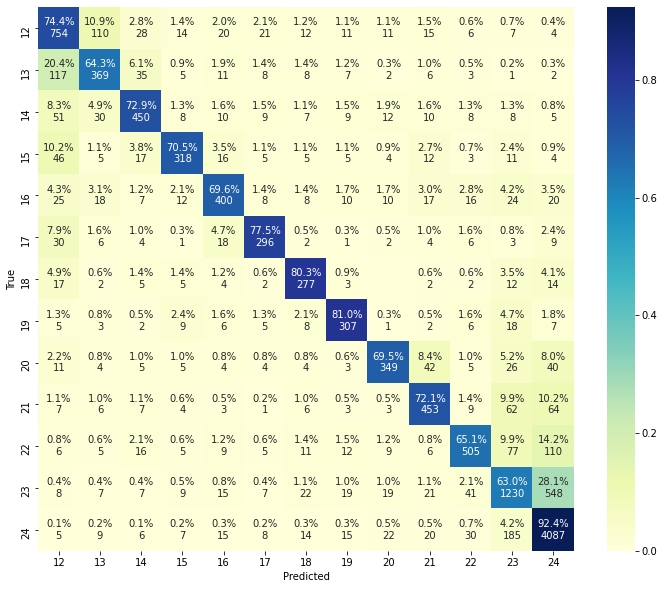

[I 2021-01-15 13:35:15,238] Trial 25 finished with value: -0.8051529992949508 and parameters: {'boosting': 'goss', 'num_leaves': 235, 'max_depth': 7, 'max_bin': 217, 'min_data_in_leaf': 252, 'min_data_in_bin': 34, 'min_gain_to_split': 0.73, 'lamda_l1': 0.03894874836119802, 'lamda_l2': 6.884762804562491e-08, 'learning_rate': 0.09870298619127872, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.54, 'feature_fraction': 0.73}. Best is trial 19 with value: -0.8088642283644726.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[200]	training's multi_error: 0.0061934	valid_1's multi_error: 0.190265
                                                                                  FOLD0-val acc: 80.97353870458136  FOLD0-test acc: 77.30226660326518
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[303]	training's multi_error: 0.000789597	valid_1's multi_error: 0.182859
                                                                                  FOLD1-val acc: 81.71406003159558  FOLD1-test acc: 76.67617689015692
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[203]	training's multi_error: 0.00562643	valid_1's multi_error: 0.187821
                                                                                  FOLD2-val acc: 81.21792341097512  FOLD2-test acc: 76.97733396734824
Training until validation scores don't i

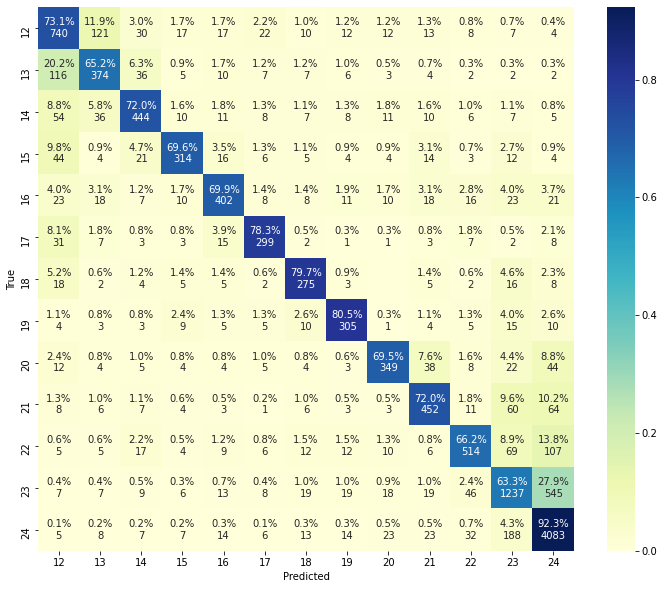

[I 2021-01-15 13:41:36,159] Trial 26 finished with value: -0.8099109700693375 and parameters: {'boosting': 'goss', 'num_leaves': 265, 'max_depth': 7, 'max_bin': 214, 'min_data_in_leaf': 254, 'min_data_in_bin': 32, 'min_gain_to_split': 0.11, 'lamda_l1': 0.040697744768451234, 'lamda_l2': 4.47364862040519e-08, 'learning_rate': 0.14455725529742267, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.53, 'feature_fraction': 0.72}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[229]	training's multi_error: 0.0314605	valid_1's multi_error: 0.189573
                                                                                  FOLD0-val acc: 81.04265402843602  FOLD0-test acc: 76.42257093041687
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[345]	training's multi_error: 0.0213685	valid_1's multi_error: 0.19066
                                                                                  FOLD1-val acc: 80.93404423380727  FOLD1-test acc: 76.54144872404501
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[253]	training's multi_error: 0.0268489	valid_1's multi_error: 0.190584
                                                                                  FOLD2-val acc: 80.94157125937623  FOLD2-test acc: 76.1372642257093
Training until validation scores don't improv

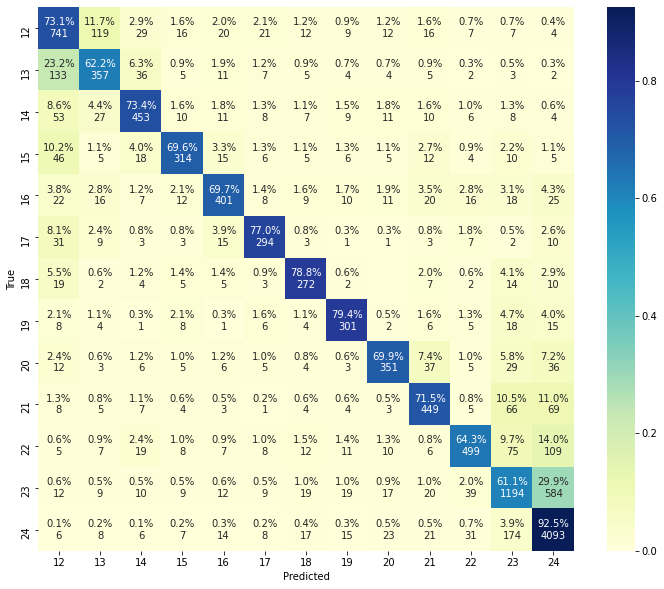

[I 2021-01-15 13:44:46,608] Trial 27 finished with value: -0.8070483361190753 and parameters: {'boosting': 'goss', 'num_leaves': 404, 'max_depth': 4, 'max_bin': 213, 'min_data_in_leaf': 226, 'min_data_in_bin': 44, 'min_gain_to_split': 1.6600000000000001, 'lamda_l1': 0.0015811395413676131, 'lamda_l2': 1.3491099558615372e-08, 'learning_rate': 0.19403884116755318, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.5, 'feature_fraction': 0.51}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[593]	training's multi_error: 0.092827	valid_1's multi_error: 0.200434
                                                                                  FOLD0-val acc: 79.9565560821485  FOLD0-test acc: 76.02631161832304
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[483]	training's multi_error: 0.111999	valid_1's multi_error: 0.216825
                                                                                  FOLD1-val acc: 78.3175355450237  FOLD1-test acc: 75.80440640355049
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[466]	training's multi_error: 0.114305	valid_1's multi_error: 0.208448
                                                                                  FOLD2-val acc: 79.15515199368338  FOLD2-test acc: 75.3922967189729
Training until validation scores don't improve fo

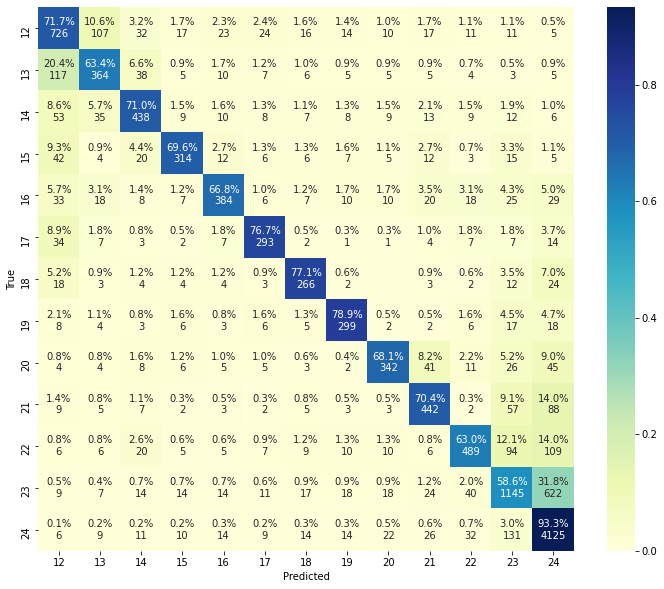

[I 2021-01-15 13:50:03,352] Trial 28 finished with value: -0.7885304378196862 and parameters: {'boosting': 'goss', 'num_leaves': 151, 'max_depth': 2, 'max_bin': 192, 'min_data_in_leaf': 228, 'min_data_in_bin': 7, 'min_gain_to_split': 0.21000000000000002, 'lamda_l1': 6.158486652982375, 'lamda_l2': 7.266728617208907e-08, 'learning_rate': 0.1491457576522797, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.5700000000000001, 'feature_fraction': 0.71}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[391]	training's multi_error: 0.0103635	valid_1's multi_error: 0.188092
                                                                                  FOLD0-val acc: 81.19075829383885  FOLD0-test acc: 77.65097479790775
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[360]	training's multi_error: 0.0138426	valid_1's multi_error: 0.197966
                                                                                  FOLD1-val acc: 80.20339652448656  FOLD1-test acc: 77.31811697574894
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[207]	training's multi_error: 0.042445	valid_1's multi_error: 0.194631
                                                                                  FOLD2-val acc: 80.53691275167785  FOLD2-test acc: 77.58757330797273
Training until validation scores don't impro

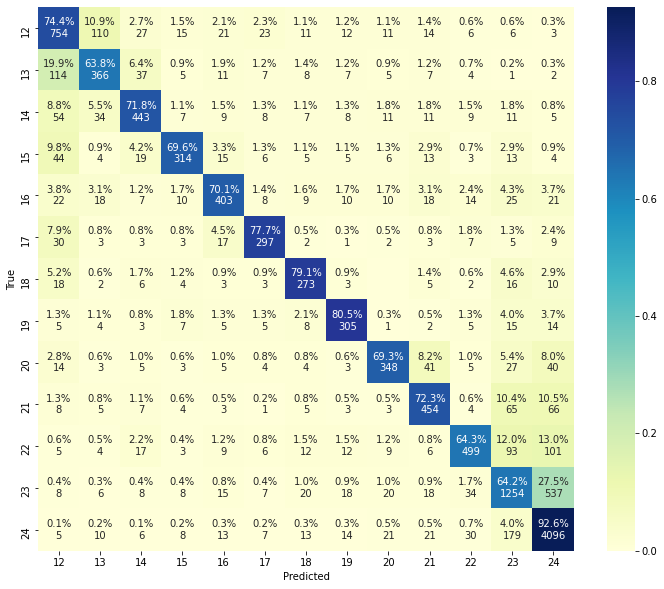

[I 2021-01-15 14:00:24,176] Trial 29 finished with value: -0.8047776302785732 and parameters: {'boosting': 'goss', 'num_leaves': 25, 'max_depth': 8, 'max_bin': 217, 'min_data_in_leaf': 256, 'min_data_in_bin': 1, 'min_gain_to_split': 0.17, 'lamda_l1': 0.03778351698156667, 'lamda_l2': 5.691405554570752e-07, 'learning_rate': 0.06085989901804768, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.64, 'feature_fraction': 0.8200000000000001}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[224]	training's multi_error: 0.00466356	valid_1's multi_error: 0.189475
                                                                                  FOLD0-val acc: 81.05252764612955  FOLD0-test acc: 76.57314946901252
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[196]	training's multi_error: 0.00513238	valid_1's multi_error: 0.192832
                                                                                  FOLD1-val acc: 80.71682464454977  FOLD1-test acc: 76.31954350927246
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[159]	training's multi_error: 0.00540434	valid_1's multi_error: 0.191966
                                                                                  FOLD2-val acc: 80.80339518357678  FOLD2-test acc: 76.29576795054683
Training until validation scores don't i

[I 2021-01-15 14:03:07,568] Trial 30 finished with value: -0.8055479399512399 and parameters: {'boosting': 'goss', 'num_leaves': 406, 'max_depth': 13, 'max_bin': 173, 'min_data_in_leaf': 204, 'min_data_in_bin': 23, 'min_gain_to_split': 0.62, 'lamda_l1': 0.7135068541847507, 'lamda_l2': 1.5939077172995565e-07, 'learning_rate': 0.33255574313351155, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.6799999999999999, 'feature_fraction': 0.74}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[286]	training's multi_error: 0.0282774	valid_1's multi_error: 0.192733
                                                                                  FOLD0-val acc: 80.72669826224329  FOLD0-test acc: 76.77920431130131
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[348]	training's multi_error: 0.0227996	valid_1's multi_error: 0.192634
                                                                                  FOLD1-val acc: 80.73657187993682  FOLD1-test acc: 76.47804723411001
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[337]	training's multi_error: 0.0225551	valid_1's multi_error: 0.185946
                                                                                  FOLD2-val acc: 81.40544808527437  FOLD2-test acc: 76.72372800760819
Training until validation scores don't impr

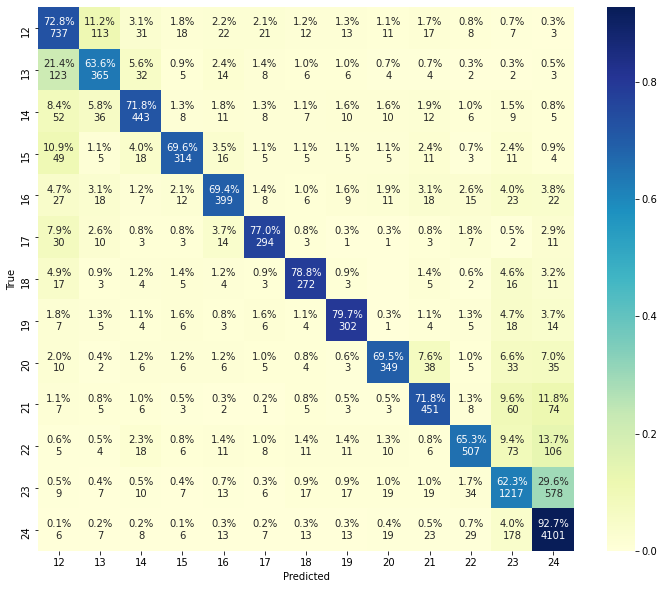

[I 2021-01-15 14:06:48,320] Trial 31 finished with value: -0.807047901512985 and parameters: {'boosting': 'goss', 'num_leaves': 442, 'max_depth': 4, 'max_bin': 211, 'min_data_in_leaf': 226, 'min_data_in_bin': 47, 'min_gain_to_split': 1.55, 'lamda_l1': 0.0007910269480114307, 'lamda_l2': 1.3982002460612905e-08, 'learning_rate': 0.16312045942997633, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.5, 'feature_fraction': 0.51}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[167]	training's multi_error: 0.0300294	valid_1's multi_error: 0.191943
                                                                                  FOLD0-val acc: 80.80568720379146  FOLD0-test acc: 76.89808210492947
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[240]	training's multi_error: 0.0245269	valid_1's multi_error: 0.191943
                                                                                  FOLD1-val acc: 80.80568720379146  FOLD1-test acc: 77.06451101600888
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[148]	training's multi_error: 0.033043	valid_1's multi_error: 0.19246
                                                                                  FOLD2-val acc: 80.75404658507699  FOLD2-test acc: 76.5810746552544
Training until validation scores don't improve

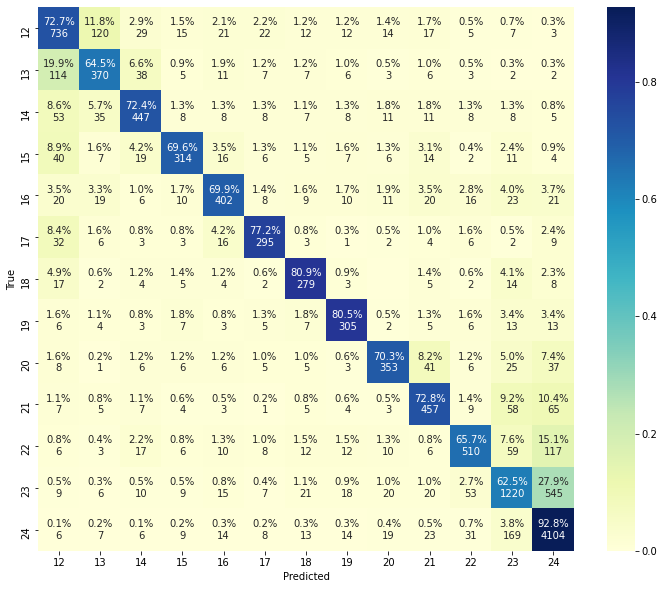

[I 2021-01-15 14:10:14,161] Trial 32 finished with value: -0.8078962417376955 and parameters: {'boosting': 'goss', 'num_leaves': 179, 'max_depth': 6, 'max_bin': 233, 'min_data_in_leaf': 235, 'min_data_in_bin': 91, 'min_gain_to_split': 1.7100000000000002, 'lamda_l1': 0.0017480874215329023, 'lamda_l2': 2.415157044506763e-08, 'learning_rate': 0.14464112412057525, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.58, 'feature_fraction': 0.6}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[304]	training's multi_error: 0.0327683	valid_1's multi_error: 0.189376
                                                                                  FOLD0-val acc: 81.06240126382306  FOLD0-test acc: 76.87430654620384
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[222]	training's multi_error: 0.0372098	valid_1's multi_error: 0.195498
                                                                                  FOLD1-val acc: 80.45023696682463  FOLD1-test acc: 76.57314946901252
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[265]	training's multi_error: 0.0344496	valid_1's multi_error: 0.192657
                                                                                  FOLD2-val acc: 80.73430714567706  FOLD2-test acc: 76.96940878110635
Training until validation scores don't impr

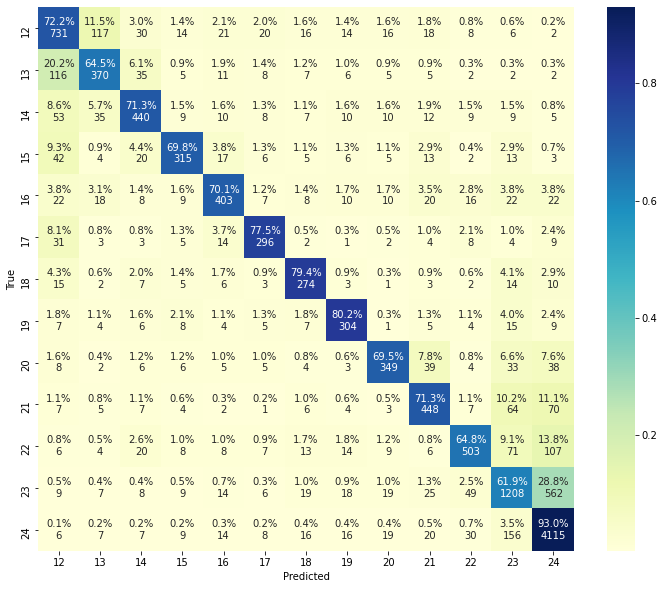

[I 2021-01-15 14:13:30,012] Trial 33 finished with value: -0.805705489168119 and parameters: {'boosting': 'goss', 'num_leaves': 141, 'max_depth': 6, 'max_bin': 235, 'min_data_in_leaf': 245, 'min_data_in_bin': 107, 'min_gain_to_split': 2.46, 'lamda_l1': 0.009213694072186022, 'lamda_l2': 2.822294296406165e-08, 'learning_rate': 0.1341029343475825, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.56, 'feature_fraction': 0.59}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[118]	training's multi_error: 0.0708417	valid_1's multi_error: 0.206161
                                                                                  FOLD0-val acc: 79.38388625592417  FOLD0-test acc: 77.06451101600888
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[466]	training's multi_error: 0.0137686	valid_1's multi_error: 0.191647
                                                                                  FOLD1-val acc: 80.83530805687204  FOLD1-test acc: 77.23093992708829
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[174]	training's multi_error: 0.0385954	valid_1's multi_error: 0.199961
                                                                                  FOLD2-val acc: 80.00394788787999  FOLD2-test acc: 77.38151846568394
Training until validation scores don't impr

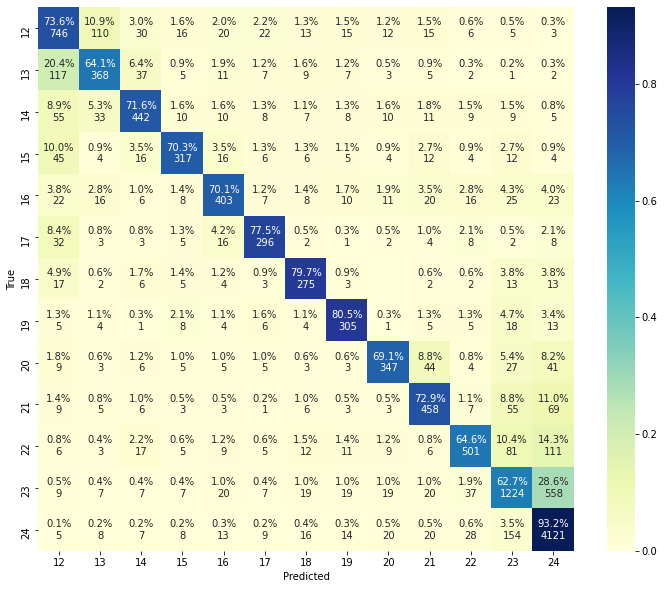

[I 2021-01-15 14:18:58,794] Trial 34 finished with value: -0.7998221733821487 and parameters: {'boosting': 'goss', 'num_leaves': 706, 'max_depth': 8, 'max_bin': 226, 'min_data_in_leaf': 208, 'min_data_in_bin': 91, 'min_gain_to_split': 1.1500000000000001, 'lamda_l1': 0.00013277310208242865, 'lamda_l2': 6.964303087199368e-08, 'learning_rate': 0.06694230668013874, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.6, 'feature_fraction': 0.7}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[195]	training's multi_error: 0.0287463	valid_1's multi_error: 0.1953
                                                                                  FOLD0-val acc: 80.46998420221169  FOLD0-test acc: 77.4290695831352
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[301]	training's multi_error: 0.024897	valid_1's multi_error: 0.199842
                                                                                  FOLD1-val acc: 80.01579778830964  FOLD1-test acc: 76.92185766365509
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[333]	training's multi_error: 0.0226538	valid_1's multi_error: 0.194433
                                                                                  FOLD2-val acc: 80.55665219107777  FOLD2-test acc: 77.04073545728325
Training until validation scores don't improve 

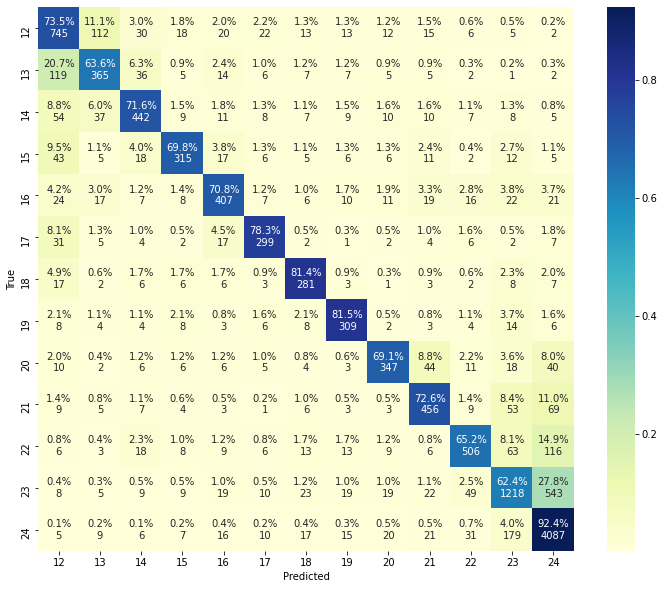

[I 2021-01-15 14:23:03,204] Trial 35 finished with value: -0.8021714764925753 and parameters: {'boosting': 'goss', 'num_leaves': 254, 'max_depth': 13, 'max_bin': 191, 'min_data_in_leaf': 180, 'min_data_in_bin': 59, 'min_gain_to_split': 1.7300000000000002, 'lamda_l1': 0.0028245924472201363, 'lamda_l2': 6.960379166640036e-07, 'learning_rate': 0.0910237098635526, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.52, 'feature_fraction': 0.62}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[82]	training's multi_error: 0.03795	valid_1's multi_error: 0.19066
                                                                                  FOLD0-val acc: 80.93404423380727  FOLD0-test acc: 76.2085909018862
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[97]	training's multi_error: 0.0362721	valid_1's multi_error: 0.203298
                                                                                  FOLD1-val acc: 79.67022116903634  FOLD1-test acc: 75.77270565858298
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[188]	training's multi_error: 0.0286751	valid_1's multi_error: 0.191473
                                                                                  FOLD2-val acc: 80.85274378207659  FOLD2-test acc: 76.46219686162625
Training until validation scores don't improve fo

[I 2021-01-15 14:25:08,582] Trial 36 finished with value: -0.8022113702855787 and parameters: {'boosting': 'goss', 'num_leaves': 120, 'max_depth': 6, 'max_bin': 238, 'min_data_in_leaf': 232, 'min_data_in_bin': 81, 'min_gain_to_split': 2.41, 'lamda_l1': 0.02269074217763584, 'lamda_l2': 2.2610000153409567e-07, 'learning_rate': 0.3149535246424409, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.59, 'feature_fraction': 0.8}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[267]	training's multi_error: 0.00671157	valid_1's multi_error: 0.187401
                                                                                  FOLD0-val acc: 81.25987361769353  FOLD0-test acc: 77.82532889522903
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[132]	training's multi_error: 0.0178893	valid_1's multi_error: 0.199842
                                                                                  FOLD1-val acc: 80.01579778830964  FOLD1-test acc: 76.35916944048185
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[270]	training's multi_error: 0.00710707	valid_1's multi_error: 0.191473
                                                                                  FOLD2-val acc: 80.85274378207659  FOLD2-test acc: 76.83468061499445
Training until validation scores don't im

[I 2021-01-15 14:29:40,702] Trial 37 finished with value: -0.8069881961798157 and parameters: {'boosting': 'goss', 'num_leaves': 622, 'max_depth': 10, 'max_bin': 181, 'min_data_in_leaf': 214, 'min_data_in_bin': 113, 'min_gain_to_split': 0.83, 'lamda_l1': 0.0004927720800189187, 'lamda_l2': 3.985405618036989e-08, 'learning_rate': 0.12936647460524583, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.5700000000000001, 'feature_fraction': 0.75}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[250]	training's multi_error: 0.017988	valid_1's multi_error: 0.186908
                                                                                  FOLD0-val acc: 81.30924170616115  FOLD0-test acc: 76.99318433983198
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[191]	training's multi_error: 0.0212451	valid_1's multi_error: 0.195893
                                                                                  FOLD1-val acc: 80.41074249605056  FOLD1-test acc: 76.32746869551434
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[132]	training's multi_error: 0.0252202	valid_1's multi_error: 0.198184
                                                                                  FOLD2-val acc: 80.18160284247926  FOLD2-test acc: 76.96940878110635
Training until validation scores don't impro

[I 2021-01-15 14:32:27,068] Trial 38 finished with value: -0.8048173722679002 and parameters: {'boosting': 'goss', 'num_leaves': 297, 'max_depth': 12, 'max_bin': 74, 'min_data_in_leaf': 256, 'min_data_in_bin': 27, 'min_gain_to_split': 1.31, 'lamda_l1': 2.2839252562099946e-05, 'lamda_l2': 1.225121062404513e-05, 'learning_rate': 0.16431073397892904, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.53, 'feature_fraction': 0.54}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[847]	training's multi_error: 0.202532	valid_1's multi_error: 0.247038
                                                                                  FOLD0-val acc: 75.29620853080569  FOLD0-test acc: 73.73593279442066
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[811]	training's multi_error: 0.203371	valid_1's multi_error: 0.260565
                                                                                  FOLD1-val acc: 73.94352290679305  FOLD1-test acc: 74.29069583135204
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[698]	training's multi_error: 0.216322	valid_1's multi_error: 0.263522
                                                                                  FOLD2-val acc: 73.6478484011054  FOLD2-test acc: 73.60912981455064
Training until validation scores don't improve 

[I 2021-01-15 14:40:01,095] Trial 39 finished with value: -0.7405794490274012 and parameters: {'boosting': 'goss', 'num_leaves': 736, 'max_depth': 2, 'max_bin': 204, 'min_data_in_leaf': 89, 'min_data_in_bin': 54, 'min_gain_to_split': 2.2600000000000002, 'lamda_l1': 1.700629884197253, 'lamda_l2': 0.2166509148249752, 'learning_rate': 0.025263504363596995, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.56, 'feature_fraction': 0.6}. Best is trial 26 with value: -0.8099109700693375.


 FOLD4-test acc: 73.45062608971311
=====================> TTA on test acc: 74.04501505785386, mse: 6.01410683151054
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[277]	training's multi_error: 0.00666223	valid_1's multi_error: 0.192338
                                                                                  FOLD0-val acc: 80.76619273301738  FOLD0-test acc: 77.23886511333016
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[251]	training's multi_error: 0.00949984	valid_1's multi_error: 0.199743
                                                                                  FOLD1-val acc: 80.02567140600317  FOLD1-test acc: 76.89808210492947
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[158]	training's multi_error: 0.0262814	valid_1's multi_error: 0.199072
                                                                           

[I 2021-01-15 14:46:28,030] Trial 40 finished with value: -0.8032372681038937 and parameters: {'boosting': 'goss', 'num_leaves': 562, 'max_depth': 9, 'max_bin': 160, 'min_data_in_leaf': 190, 'min_data_in_bin': 18, 'min_gain_to_split': 0.5, 'lamda_l1': 0.13079824692718103, 'lamda_l2': 1.068365978612543e-08, 'learning_rate': 0.07784053790652284, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.66, 'feature_fraction': 0.64}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[178]	training's multi_error: 0.036889	valid_1's multi_error: 0.188882
                                                                                  FOLD0-val acc: 81.11176935229068  FOLD0-test acc: 76.80297987002695
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[191]	training's multi_error: 0.0332124	valid_1's multi_error: 0.197077
                                                                                  FOLD1-val acc: 80.29225908372828  FOLD1-test acc: 76.30369313678872
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[285]	training's multi_error: 0.0216667	valid_1's multi_error: 0.186636
                                                                                  FOLD2-val acc: 81.33636004737465  FOLD2-test acc: 76.24821683309557
Training until validation scores don't impro

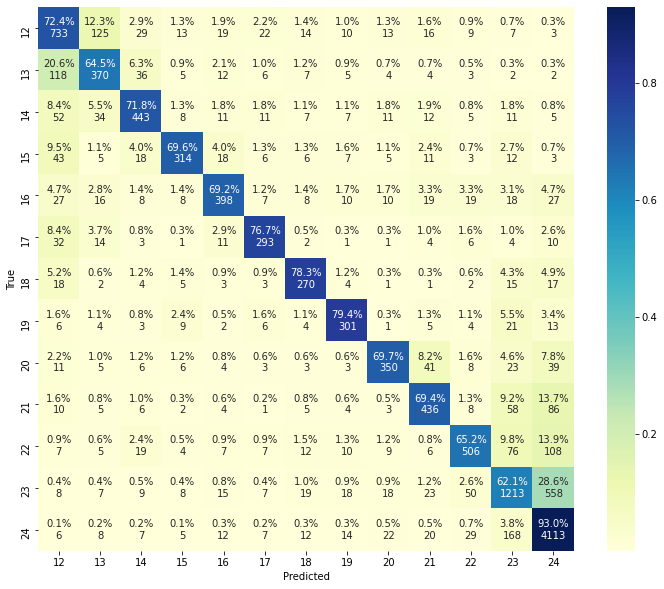

[I 2021-01-15 14:49:09,655] Trial 41 finished with value: -0.8041067250100896 and parameters: {'boosting': 'goss', 'num_leaves': 409, 'max_depth': 4, 'max_bin': 220, 'min_data_in_leaf': 238, 'min_data_in_bin': 42, 'min_gain_to_split': 1.7300000000000002, 'lamda_l1': 0.0038612048896965083, 'lamda_l2': 1.0517493735039368e-08, 'learning_rate': 0.2279488104726102, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.51, 'feature_fraction': 0.51}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[183]	training's multi_error: 0.03985	valid_1's multi_error: 0.192141
                                                                                  FOLD0-val acc: 80.78593996840442  FOLD0-test acc: 76.50182279283563
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[325]	training's multi_error: 0.0225035	valid_1's multi_error: 0.187994
                                                                                  FOLD1-val acc: 81.20063191153238  FOLD1-test acc: 76.47012204786813
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[238]	training's multi_error: 0.0280335	valid_1's multi_error: 0.192854
                                                                                  FOLD2-val acc: 80.71456770627714  FOLD2-test acc: 76.78712949754319
Training until validation scores don't improv

[I 2021-01-15 14:52:17,228] Trial 42 finished with value: -0.8053506761682936 and parameters: {'boosting': 'goss', 'num_leaves': 377, 'max_depth': 4, 'max_bin': 207, 'min_data_in_leaf': 217, 'min_data_in_bin': 50, 'min_gain_to_split': 1.7300000000000002, 'lamda_l1': 0.0009827805385817317, 'lamda_l2': 1.3852448774235058e-07, 'learning_rate': 0.19682435716664565, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.5, 'feature_fraction': 0.56}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[138]	training's multi_error: 0.00816739	valid_1's multi_error: 0.189672
                                                                                  FOLD0-val acc: 81.0327804107425  FOLD0-test acc: 76.96940878110635
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[204]	training's multi_error: 0.00700767	valid_1's multi_error: 0.191647
                                                                                  FOLD1-val acc: 80.83530805687204  FOLD1-test acc: 76.33539388175622
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[116]	training's multi_error: 0.00932804	valid_1's multi_error: 0.194335
                                                                                  FOLD2-val acc: 80.56652191077774  FOLD2-test acc: 76.18481534316057
Training until validation scores don't im

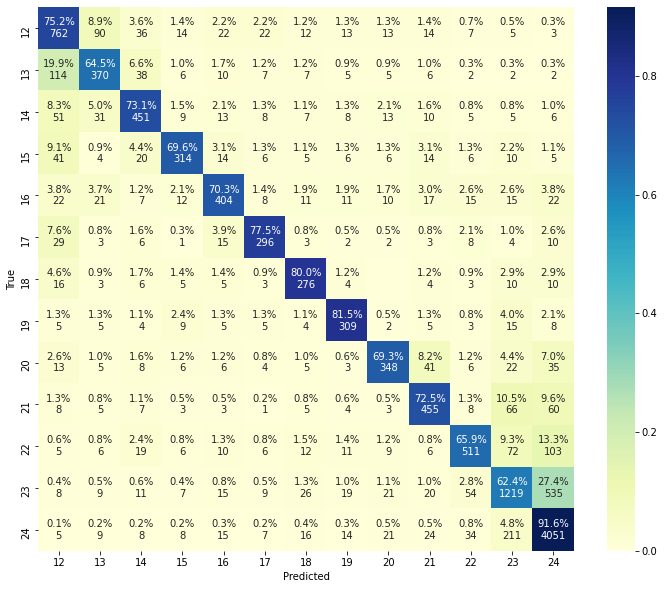

[I 2021-01-15 14:55:01,933] Trial 43 finished with value: -0.80696915237477 and parameters: {'boosting': 'goss', 'num_leaves': 196, 'max_depth': 7, 'max_bin': 198, 'min_data_in_leaf': 242, 'min_data_in_bin': 86, 'min_gain_to_split': 0.92, 'lamda_l1': 0.0001371900255667667, 'lamda_l2': 2.567536227386215e-08, 'learning_rate': 0.3422575386340288, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.59, 'feature_fraction': 0.76}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[101]	training's multi_error: 0.0534212	valid_1's multi_error: 0.198361
                                                                                  FOLD0-val acc: 80.16390205371248  FOLD0-test acc: 76.54937391028689
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[150]	training's multi_error: 0.0530017	valid_1's multi_error: 0.210604
                                                                                  FOLD1-val acc: 78.93957345971565  FOLD1-test acc: 76.08971310825804
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[144]	training's multi_error: 0.0478	valid_1's multi_error: 0.207462
                                                                                  FOLD2-val acc: 79.25384919068298  FOLD2-test acc: 75.88365826596925
Training until validation scores don't improve

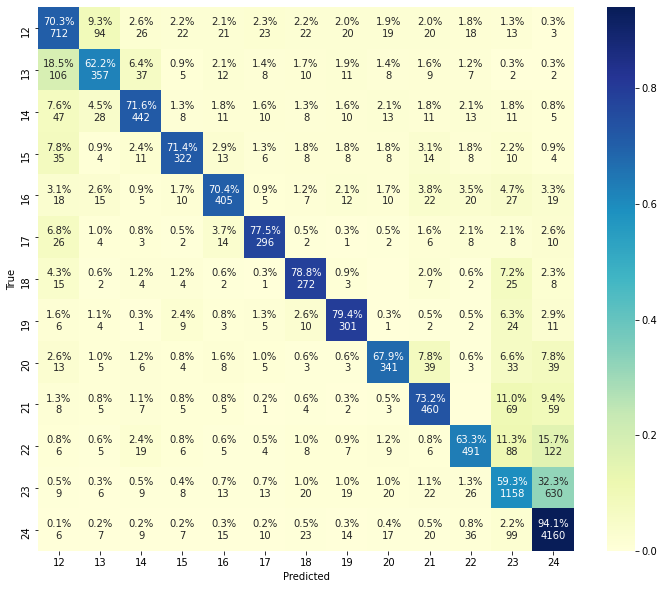

[I 2021-01-15 14:58:35,527] Trial 44 finished with value: -0.7933473172358185 and parameters: {'boosting': 'gbdt', 'num_leaves': 64, 'max_depth': 5, 'max_bin': 226, 'min_data_in_leaf': 196, 'min_data_in_bin': 65, 'min_gain_to_split': 1.28, 'lamda_l1': 0.07646946215491973, 'lamda_l2': 9.410511303894135e-07, 'learning_rate': 0.18990926044901152, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.61, 'feature_fraction': 0.7}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[799]	training's multi_error: 0.0345695	valid_1's multi_error: 0.194412
                                                                                  FOLD0-val acc: 80.5588467614534  FOLD0-test acc: 77.6034236804565
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[589]	training's multi_error: 0.0502381	valid_1's multi_error: 0.210999
                                                                                  FOLD1-val acc: 78.90007898894154  FOLD1-test acc: 77.61134886669836
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[721]	training's multi_error: 0.0378304	valid_1's multi_error: 0.201244
                                                                                  FOLD2-val acc: 79.87564153178049  FOLD2-test acc: 77.4290695831352
Training until validation scores don't improve

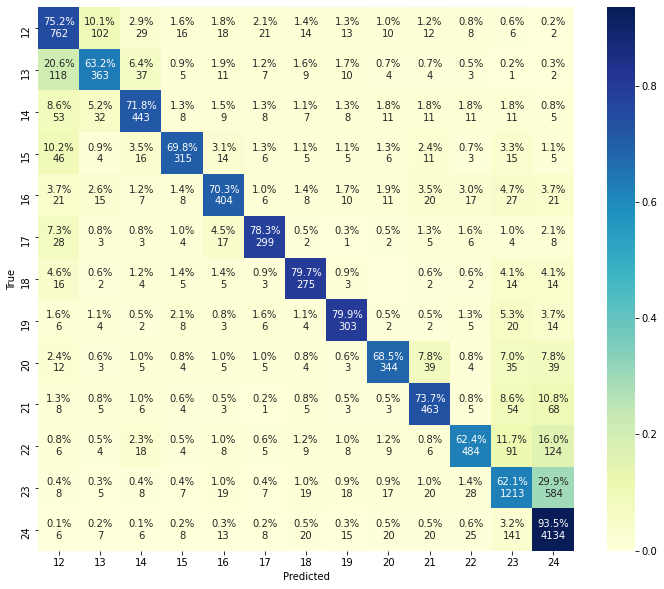

[I 2021-01-15 15:14:27,139] Trial 45 finished with value: -0.7941571194100707 and parameters: {'boosting': 'goss', 'num_leaves': 330, 'max_depth': 9, 'max_bin': 184, 'min_data_in_leaf': 166, 'min_data_in_bin': 14, 'min_gain_to_split': 1.6300000000000001, 'lamda_l1': 3.5354328356879515e-05, 'lamda_l2': 1.0567824254967097e-08, 'learning_rate': 0.01496161283148928, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.53, 'feature_fraction': 0.58}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[504]	training's multi_error: 0.0483135	valid_1's multi_error: 0.186216
                                                                                  FOLD0-val acc: 81.3783570300158  FOLD0-test acc: 77.15168806466951
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[401]	training's multi_error: 0.0597873	valid_1's multi_error: 0.202607
                                                                                  FOLD1-val acc: 79.739336492891  FOLD1-test acc: 76.87430654620384
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[463]	training's multi_error: 0.0512548	valid_1's multi_error: 0.193545
                                                                                  FOLD2-val acc: 80.64547966837742  FOLD2-test acc: 76.86638135996195
Training until validation scores don't improve

[I 2021-01-15 15:19:05,628] Trial 46 finished with value: -0.8012248504505288 and parameters: {'boosting': 'goss', 'num_leaves': 492, 'max_depth': 3, 'max_bin': 213, 'min_data_in_leaf': 134, 'min_data_in_bin': 99, 'min_gain_to_split': 2.91, 'lamda_l1': 0.001773704216200402, 'lamda_l2': 1.3790127069434193e-07, 'learning_rate': 0.12188549727665858, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.56, 'feature_fraction': 0.53}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[846]	training's multi_error: 0.0967503	valid_1's multi_error: 0.195399
                                                                                  FOLD0-val acc: 80.46011058451816  FOLD0-test acc: 77.04073545728325
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_error: 0.0816986	valid_1's multi_error: 0.199151
                                                                                  FOLD1-val acc: 80.0849131121643  FOLD1-test acc: 76.7158028213663
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[540]	training's multi_error: 0.137798	valid_1's multi_error: 0.207165
                                                                                  FOLD2-val acc: 79.28345834978286  FOLD2-test acc: 76.72372800760819
Training until validation scores

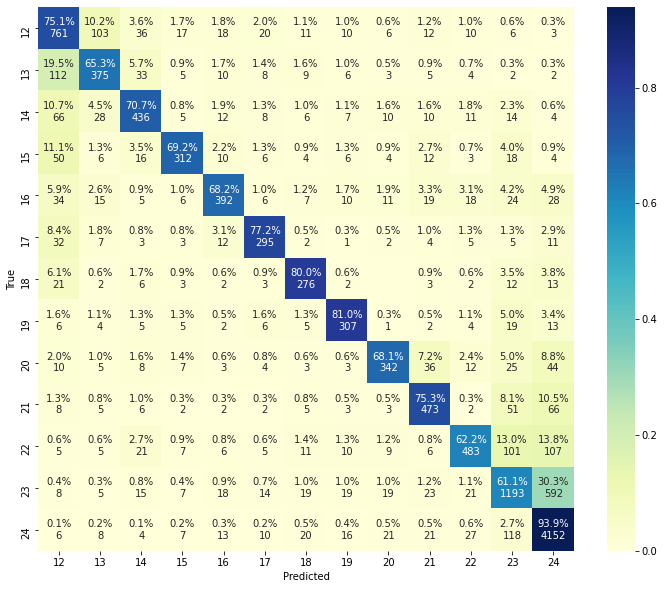

[I 2021-01-15 15:34:43,979] Trial 47 finished with value: -0.7936850776510918 and parameters: {'boosting': 'gbdt', 'num_leaves': 5, 'max_depth': 7, 'max_bin': 241, 'min_data_in_leaf': 175, 'min_data_in_bin': 32, 'min_gain_to_split': 1.02, 'lamda_l1': 4.147885595632989e-06, 'lamda_l2': 3.2312104609598634e-07, 'learning_rate': 0.053895602967573404, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.52, 'feature_fraction': 0.65}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.142448	valid_1's multi_logloss: 0.572576
                                                                                  FOLD0-val acc: 81.42772511848341  FOLD0-test acc: 77.23093992708829
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.141086	valid_1's multi_logloss: 0.603754
                                                                                  FOLD1-val acc: 81.01303317535546  FOLD1-test acc: 77.20716436836265
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.141372	valid_1's multi_logloss: 0.591887
                                                                                  FOLD2-val acc: 81.16857481247533  FOLD2-test acc: 77.2864162

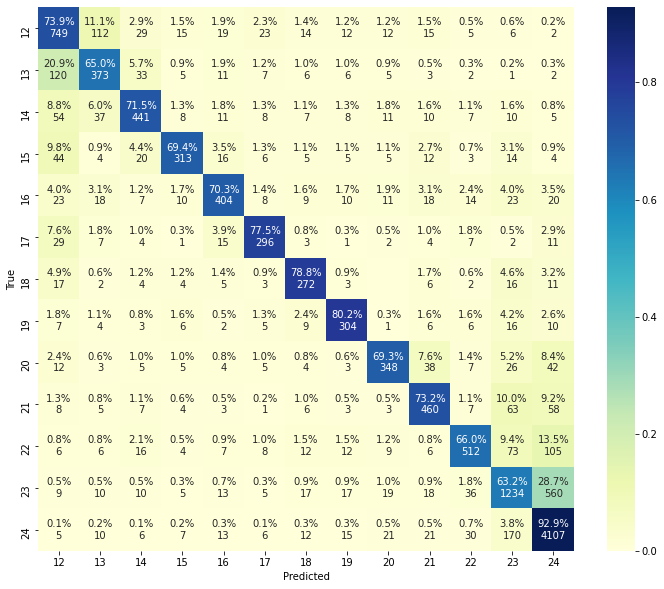

[I 2021-01-15 15:53:53,454] Trial 48 finished with value: -0.8093381502955508 and parameters: {'boosting': 'goss', 'num_leaves': 194, 'max_depth': 5, 'max_bin': 167, 'min_data_in_leaf': 220, 'min_data_in_bin': 125, 'min_gain_to_split': 0.39, 'lamda_l1': 0.006527387678753875, 'lamda_l2': 2.844546427067319e-08, 'learning_rate': 0.033565434319619426, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.63, 'feature_fraction': 0.61}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[317]	training's multi_logloss: 0.274539	valid_1's multi_logloss: 0.773972
                                                                                  FOLD0-val acc: 79.9960505529226  FOLD0-test acc: 77.27849104453955
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[305]	training's multi_logloss: 0.277426	valid_1's multi_logloss: 0.804338
                                                                                  FOLD1-val acc: 79.54186413902053  FOLD1-test acc: 76.81090505626882
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[317]	training's multi_logloss: 0.271044	valid_1's multi_logloss: 0.80489
                                                                                  FOLD2-val acc: 79.2735886300829  FOLD2-test acc: 76.43842130290062
Training until validation scores don'

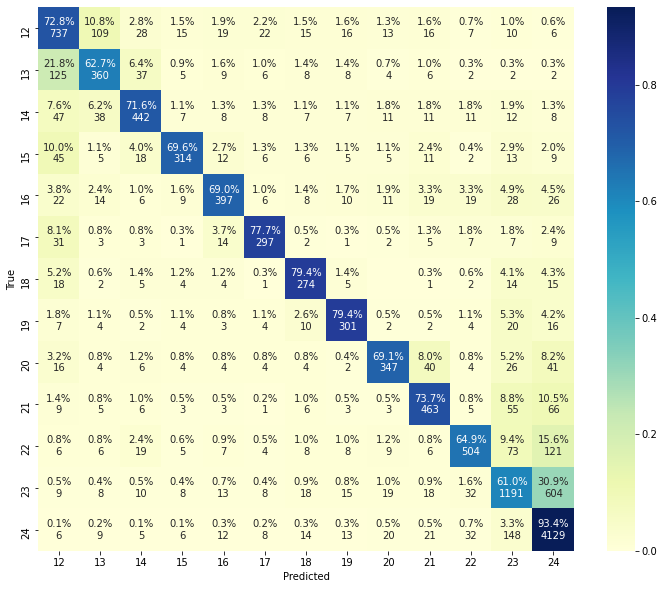

[I 2021-01-15 16:04:55,755] Trial 49 finished with value: -0.7957554920741645 and parameters: {'boosting': 'goss', 'num_leaves': 226, 'max_depth': 12, 'max_bin': 163, 'min_data_in_leaf': 218, 'min_data_in_bin': 128, 'min_gain_to_split': 0.1, 'lamda_l1': 0.007382750875137478, 'lamda_l2': 0.0002498489500122411, 'learning_rate': 0.027837577591706353, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.63, 'feature_fraction': 0.61}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[723]	training's multi_logloss: 0.116604	valid_1's multi_logloss: 0.590353
                                                                                  FOLD0-val acc: 80.60821484992101  FOLD0-test acc: 77.57172293548898
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[772]	training's multi_logloss: 0.106431	valid_1's multi_logloss: 0.622286
                                                                                  FOLD1-val acc: 80.58846761453397  FOLD1-test acc: 77.12791250594388
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[798]	training's multi_logloss: 0.101946	valid_1's multi_logloss: 0.603802
                                                                                  FOLD2-val acc: 81.18831425187525  FOLD2-test acc: 77.47662070058647
Training until validation scores d

[I 2021-01-15 16:25:18,530] Trial 50 finished with value: -0.8066920422209198 and parameters: {'boosting': 'goss', 'num_leaves': 168, 'max_depth': 8, 'max_bin': 170, 'min_data_in_leaf': 250, 'min_data_in_bin': 144, 'min_gain_to_split': 0.51, 'lamda_l1': 0.022159582625751243, 'lamda_l2': 2.918949439685742e-08, 'learning_rate': 0.03194554266031585, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.69, 'feature_fraction': 0.78}. Best is trial 26 with value: -0.8099109700693375.


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[763]	training's multi_logloss: 0.115719	valid_1's multi_logloss: 0.56752
                                                                                  FOLD0-val acc: 81.32898894154819  FOLD0-test acc: 77.33396734823268
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[651]	training's multi_logloss: 0.138707	valid_1's multi_logloss: 0.606446
                                                                                  FOLD1-val acc: 80.69707740916272  FOLD1-test acc: 77.21508955460453
Training until validation scores don't improve for 30 rounds.


In [ ]:
#optimization_function = partial(optimize, X=x, y=y)
study  = optuna.create_study(direction = "minimize")
#study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

study.optimize(optimize, n_trials=500)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
#optimization_function = partial(optimize, X=x, y=y)
study  = optuna.create_study(direction = "minimize")
#study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

study.optimize(optimize, n_trials=500)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-01-16 16:20:11,445] A new study created in memory with name: no-name-1ffe16a2-243d-4a14-96f3-f6b5b9941b02


Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[418]	training's multi_error: 0.0402756	valid_1's multi_error: 0.202153
                                                                                  FOLD0-val acc: 79.78471262097571  FOLD0-test acc: 76.30226859536795
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[602]	training's multi_error: 0.0245721	valid_1's multi_error: 0.211867
                                                                                  FOLD1-val acc: 78.81330832263797  FOLD1-test acc: 76.50778594577504
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[416]	training's multi_error: 0.0416039	valid_1's multi_error: 0.202944
                                                                                  FOLD2-val acc: 79.70556269143366  FOLD2-test acc: 76.27855505493638
Training until validation scores don't impr

[I 2021-01-16 16:35:36,109] Trial 0 finished with value: -0.7953464925453748 and parameters: {'boosting': 'goss', 'num_leaves': 659, 'max_depth': 12, 'max_bin': 233, 'min_data_in_leaf': 107, 'min_data_in_bin': 235, 'min_gain_to_split': 1.12, 'lamda_l1': 0.03707932887695611, 'lamda_l2': 1.897389711733466e-07, 'learning_rate': 0.015411143536642014, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.99, 'feature_fraction': 0.6}. Best is trial 0 with value: -0.7953464925453748.


 FOLD4-test acc: 76.30226859536795
=====================> TTA on test acc: 76.7370168366137, mse: 4.13666903802071 ~ 41366690380.2071
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[459]	training's multi_logloss: 0.305324	valid_1's multi_logloss: 0.680542
                                                                                  FOLD0-val acc: 78.4120086904997  FOLD0-test acc: 76.23903248755039
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[428]	training's multi_logloss: 0.30565	valid_1's multi_logloss: 0.689251
                                                                                  FOLD1-val acc: 79.19834139599172  FOLD1-test acc: 75.51181724764841
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[447]	training's multi_logloss: 0.300274	valid_1's multi_logloss: 0.699928
                                                    

[I 2021-01-16 16:48:13,281] Trial 1 finished with value: -0.7872460311984391 and parameters: {'boosting': 'gbdt', 'num_leaves': 1864, 'max_depth': 23, 'max_bin': 161, 'min_data_in_leaf': 72, 'min_data_in_bin': 45, 'min_gain_to_split': 3.8600000000000003, 'lamda_l1': 3.611747250175738e-07, 'lamda_l2': 4.96954708224156e-07, 'learning_rate': 0.025471325346548637, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.88, 'feature_fraction': 0.86}. Best is trial 0 with value: -0.7953464925453748.


 FOLD4-test acc: 76.46826337838905
=====================> TTA on test acc: 76.60264010750139, mse: 3.993597344083472 ~ 39935973440.83472
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[154]	training's multi_error: 0.057907	valid_1's multi_error: 0.207584
                                                                                  FOLD0-val acc: 79.2415563894924  FOLD0-test acc: 76.07303770452928
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[288]	training's multi_error: 0.0471193	valid_1's multi_error: 0.185803
                                                                                  FOLD1-val acc: 81.41968604995557  FOLD1-test acc: 76.08094221800648
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[239]	training's multi_error: 0.0501963	valid_1's multi_error: 0.206897
                                                          

[I 2021-01-16 16:53:04,323] Trial 2 finished with value: -0.7998088394942233 and parameters: {'boosting': 'goss', 'num_leaves': 843, 'max_depth': 7, 'max_bin': 177, 'min_data_in_leaf': 95, 'min_data_in_bin': 201, 'min_gain_to_split': 3.81, 'lamda_l1': 0.001774673452260073, 'lamda_l2': 0.006688706120870354, 'learning_rate': 0.06649222234435707, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.74, 'feature_fraction': 0.96}. Best is trial 2 with value: -0.7998088394942233.


 FOLD4-test acc: 76.2311279740732
=====================> TTA on test acc: 76.39712275709431, mse: 3.945854082681211 ~ 39458540826.81211
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[407]	training's multi_error: 0.0781559	valid_1's multi_error: 0.226644
                                                                                  FOLD0-val acc: 77.33557179537823  FOLD0-test acc: 75.64619397676073
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[696]	training's multi_error: 0.0434396	valid_1's multi_error: 0.21088
                                                                                  FOLD1-val acc: 78.91203475170303  FOLD1-test acc: 76.0493241640977
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[214]	training's multi_error: 0.102022	valid_1's multi_error: 0.227744
                                                            

[I 2021-01-16 17:09:32,076] Trial 3 finished with value: -0.7777832739772305 and parameters: {'boosting': 'goss', 'num_leaves': 1776, 'max_depth': 19, 'max_bin': 186, 'min_data_in_leaf': 107, 'min_data_in_bin': 118, 'min_gain_to_split': 3.8200000000000003, 'lamda_l1': 4.6406198487076106e-06, 'lamda_l2': 4.56755644287391e-06, 'learning_rate': 0.007456390260104328, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.62, 'feature_fraction': 0.65}. Best is trial 2 with value: -0.7998088394942233.


 FOLD4-test acc: 75.58295786894317
=====================> TTA on test acc: 76.14417832582404, mse: 4.8736858746344165 ~ 48736858746.34416
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[131]	training's multi_error: 0.0317809	valid_1's multi_error: 0.2143
                                                                                  FOLD0-val acc: 78.57001777602211  FOLD0-test acc: 75.3379179511501
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[213]	training's multi_error: 0.0193614	valid_1's multi_error: 0.206141
                                                                                  FOLD1-val acc: 79.38592161121532  FOLD1-test acc: 75.63828946328354
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[161]	training's multi_error: 0.0246167	valid_1's multi_error: 0.218654
                                                          

[I 2021-01-16 17:12:41,224] Trial 4 finished with value: -0.7865341395426368 and parameters: {'boosting': 'goss', 'num_leaves': 641, 'max_depth': 18, 'max_bin': 136, 'min_data_in_leaf': 246, 'min_data_in_bin': 106, 'min_gain_to_split': 3.21, 'lamda_l1': 0.002906543589053468, 'lamda_l2': 3.219942228797434e-05, 'learning_rate': 0.10299837937195613, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.99, 'feature_fraction': 0.55}. Best is trial 2 with value: -0.7998088394942233.


 FOLD4-test acc: 75.09287803335705
=====================> TTA on test acc: 75.78057070587305, mse: 4.838826970199984 ~ 48388269701.99984
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[119]	training's multi_logloss: 0.219022	valid_1's multi_logloss: 0.654184
                                                                                  FOLD0-val acc: 78.44163539403516  FOLD0-test acc: 75.82009327325903
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.218146	valid_1's multi_logloss: 0.666342
                                                                                  FOLD1-val acc: 79.1884687530852  FOLD1-test acc: 75.89123389455379
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.214494	valid_1's multi_logloss: 0.687275
                                                

[I 2021-01-16 17:16:52,582] Trial 5 finished with value: -0.7878190053681647 and parameters: {'boosting': 'gbdt', 'num_leaves': 1834, 'max_depth': 15, 'max_bin': 225, 'min_data_in_leaf': 180, 'min_data_in_bin': 14, 'min_gain_to_split': 1.9300000000000002, 'lamda_l1': 8.686692482861952e-06, 'lamda_l2': 1.7988750815395553e-06, 'learning_rate': 0.12605140384538321, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.54, 'feature_fraction': 0.8200000000000001}. Best is trial 2 with value: -0.7998088394942233.


 FOLD4-test acc: 76.0651331910521
=====================> TTA on test acc: 76.77653940399969, mse: 3.868864121413327 ~ 38688641214.13327
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[417]	training's multi_error: 0.0312623	valid_1's multi_error: 0.215386
                                                                                  FOLD0-val acc: 78.46138652972546  FOLD0-test acc: 75.82799778673622
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[528]	training's multi_error: 0.0237819	valid_1's multi_error: 0.206536
                                                                                  FOLD1-val acc: 79.34643103958929  FOLD1-test acc: 76.15208283930124
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[407]	training's multi_error: 0.0316535	valid_1's multi_error: 0.215097
                                                         

[I 2021-01-16 17:27:01,157] Trial 6 finished with value: -0.784400562212395 and parameters: {'boosting': 'goss', 'num_leaves': 1681, 'max_depth': 17, 'max_bin': 95, 'min_data_in_leaf': 61, 'min_data_in_bin': 145, 'min_gain_to_split': 1.6, 'lamda_l1': 7.46888662058894e-08, 'lamda_l2': 8.966579613377915, 'learning_rate': 0.01814042059719198, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.71, 'feature_fraction': 0.5}. Best is trial 2 with value: -0.7998088394942233.


 FOLD4-test acc: 75.40115405896766
=====================> TTA on test acc: 76.0651331910521, mse: 4.67852343688246 ~ 46785234368.8246
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[315]	training's multi_logloss: 0.339303	valid_1's multi_logloss: 0.843316
                                                                                  FOLD0-val acc: 77.35532293106854  FOLD0-test acc: 75.82009327325903
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[465]	training's multi_logloss: 0.267504	valid_1's multi_logloss: 0.84001
                                                                                  FOLD1-val acc: 78.97127060914207  FOLD1-test acc: 75.95447000237135
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[283]	training's multi_logloss: 0.347553	valid_1's multi_logloss: 0.846837
                                                   

[I 2021-01-16 17:47:42,171] Trial 7 finished with value: -0.7814974436743994 and parameters: {'boosting': 'gbdt', 'num_leaves': 1085, 'max_depth': 17, 'max_bin': 76, 'min_data_in_leaf': 160, 'min_data_in_bin': 93, 'min_gain_to_split': 1.26, 'lamda_l1': 1.4690407423656502e-08, 'lamda_l2': 0.0010578111505133699, 'learning_rate': 0.01114841968156663, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.63, 'feature_fraction': 0.87}. Best is trial 2 with value: -0.7998088394942233.


 FOLD4-test acc: 76.10465575843807
=====================> TTA on test acc: 76.37340921666271, mse: 4.343688245988459 ~ 43436882459.8846
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.154759	valid_1's multi_logloss: 0.60216
                                                                                  FOLD0-val acc: 80.11060635986568  FOLD0-test acc: 75.90704292150818
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.155174	valid_1's multi_logloss: 0.601741
                                                                                  FOLD1-val acc: 81.7652285516833  FOLD1-test acc: 76.37340921666271
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.153643	valid_1's multi_logloss: 0.626353
        

KeyboardInterrupt: ignored

Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[924]	training's multi_logloss: 0.311242	valid_1's multi_logloss: 0.808772
                                                                                  FOLD0-val acc: 78.19133181952809  FOLD0-test acc: 76.1803084223013
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[798]	training's multi_logloss: 0.342731	valid_1's multi_logloss: 0.788101
                                                                                  FOLD1-val acc: 78.8626715371705  FOLD1-test acc: 75.97469355476473
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[792]	training's multi_logloss: 0.353442	valid_1's multi_logloss: 0.783074
                                                                                  FOLD2-val acc: 78.45074597371801  FOLD2-test acc: 76.1407671016212
Training until validation scores don'

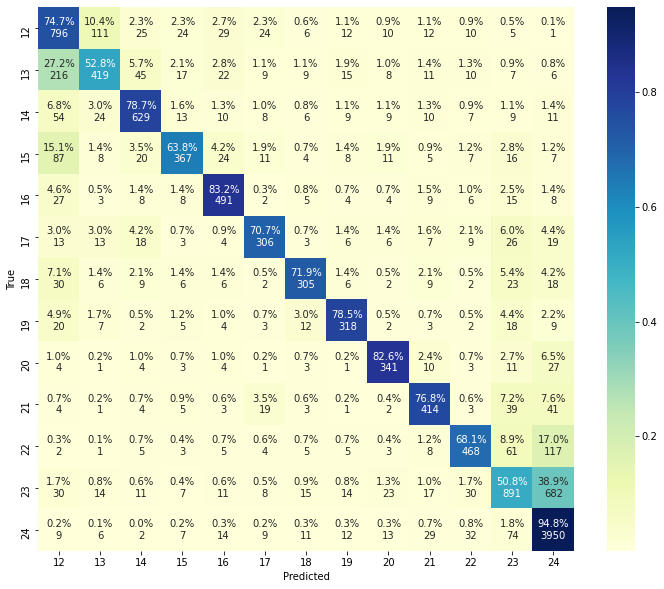

[I 2021-01-09 21:47:44,525] Trial 20 finished with value: -0.7796477639603459 and parameters: {'boosting': 'gbdt', 'num_leaves': 1912, 'max_depth': 9, 'max_bin': 200, 'min_data_in_leaf': 24, 'min_data_in_bin': 213, 'min_gain_to_split': 0.28, 'lamda_l1': 1.0045198888532194e-05, 'lamda_l2': 4.073273171720545e-07, 'learning_rate': 0.005008952157799371, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.7, 'feature_fraction': 0.9199999999999999}. Best is trial 11 with value: -0.7824136822474828.


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.642236	valid_1's multi_logloss: 0.857212
                                                                                  FOLD0-val acc: 76.54260045414158  FOLD0-test acc: 75.23131672597864
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.653666	valid_1's multi_logloss: 0.848768
                                                                                  FOLD1-val acc: 77.15470431434494  FOLD1-test acc: 75.20759193357058
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.648311	valid_1's multi_logloss: 0.819909
                                                                                  FOLD2-val acc: 77.62078845963838  FOLD2-test acc: 75.3103993

[I 2021-01-09 22:00:48,920] Trial 21 finished with value: -0.7642023465041878 and parameters: {'boosting': 'gbdt', 'num_leaves': 1685, 'max_depth': 6, 'max_bin': 220, 'min_data_in_leaf': 87, 'min_data_in_bin': 158, 'min_gain_to_split': 3.2600000000000002, 'lamda_l1': 0.0828245826769979, 'lamda_l2': 3.0885078468006576e-07, 'learning_rate': 0.005394237816921965, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.64, 'feature_fraction': 0.5}. Best is trial 11 with value: -0.7824136822474828.


 FOLD4-test acc: 75.19177540529853
=====================> TTA on test acc: 75.713720838276, mse: 4.53570581257414
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.345247	valid_1's multi_logloss: 0.796652
                                                                                  FOLD0-val acc: 78.39865732056471  FOLD0-test acc: 75.99841834717279
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[317]	training's multi_logloss: 0.3437	valid_1's multi_logloss: 0.776857
                                                                                  FOLD1-val acc: 79.0305064665811  FOLD1-test acc: 75.84816132858838
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[318]	training's multi_logloss: 0.345003	valid_1's multi_logloss: 0.758812
                                                                         

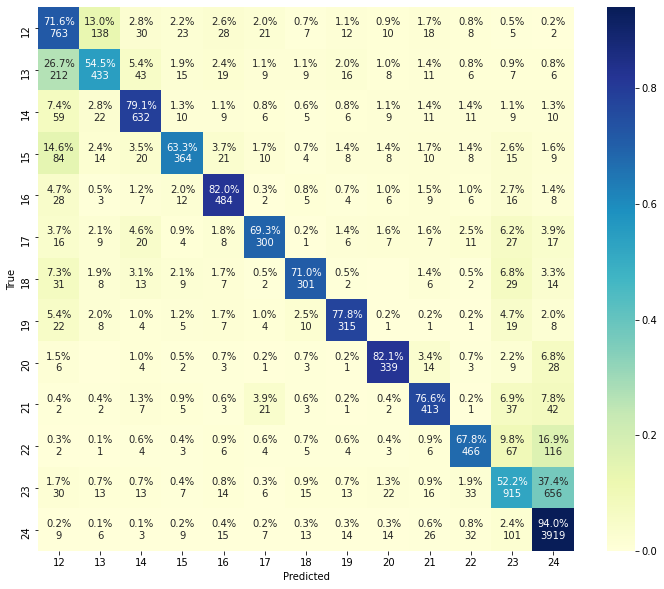

[I 2021-01-09 22:09:46,843] Trial 22 finished with value: -0.7816037178308601 and parameters: {'boosting': 'gbdt', 'num_leaves': 2027, 'max_depth': 11, 'max_bin': 254, 'min_data_in_leaf': 163, 'min_data_in_bin': 98, 'min_gain_to_split': 0.12000000000000001, 'lamda_l1': 1.627390357553677e-07, 'lamda_l2': 0.0008096598889245251, 'learning_rate': 0.018572316012392977, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.78, 'feature_fraction': 0.61}. Best is trial 11 with value: -0.7824136822474828.


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 1.01745	valid_1's multi_logloss: 1.08187
                                                                                  FOLD0-val acc: 68.53588705696515  FOLD0-test acc: 67.71846579675761
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 1.02788	valid_1's multi_logloss: 1.06765
                                                                                  FOLD1-val acc: 69.70085891993286  FOLD1-test acc: 67.71055753262158
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 1.02376	valid_1's multi_logloss: 1.04777
                                                                                  FOLD2-val acc: 70.55626914336528  FOLD2-test acc: 67.6631079478054

[I 2021-01-09 22:18:46,340] Trial 23 finished with value: -0.6918902431037441 and parameters: {'boosting': 'gbdt', 'num_leaves': 1542, 'max_depth': 2, 'max_bin': 189, 'min_data_in_leaf': 90, 'min_data_in_bin': 53, 'min_gain_to_split': 0.83, 'lamda_l1': 0.0007181581257884271, 'lamda_l2': 1.871476528101138e-05, 'learning_rate': 0.008167010609382474, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.76, 'feature_fraction': 0.7}. Best is trial 11 with value: -0.7824136822474828.


 FOLD4-test acc: 68.6041913799921
=====================> TTA on test acc: 68.10597073942269, mse: 11.095294582839067
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[613]	training's multi_logloss: 0.347908	valid_1's multi_logloss: 0.824736
                                                                                  FOLD0-val acc: 77.91489781814592  FOLD0-test acc: 76.02214313958086
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[629]	training's multi_logloss: 0.34892	valid_1's multi_logloss: 0.806883
                                                                                  FOLD1-val acc: 78.852798894264  FOLD1-test acc: 75.72162910241202
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[608]	training's multi_logloss: 0.337916	valid_1's multi_logloss: 0.77612
                                                                       

[I 2021-01-09 22:27:14,931] Trial 24 finished with value: -0.7797867340359683 and parameters: {'boosting': 'gbdt', 'num_leaves': 654, 'max_depth': 15, 'max_bin': 125, 'min_data_in_leaf': 35, 'min_data_in_bin': 125, 'min_gain_to_split': 2.0, 'lamda_l1': 4.855753763390138e-07, 'lamda_l2': 5.807461099206278e-07, 'learning_rate': 0.013375824796107381, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.89, 'feature_fraction': 0.66}. Best is trial 11 with value: -0.7824136822474828.


 FOLD4-test acc: 75.86397785686042
=====================> TTA on test acc: 75.95887702649269, mse: 4.012495057334915
Training until validation scores don't improve for 30 rounds.
Early stopping, best iteration is:
[921]	training's multi_logloss: 0.272715	valid_1's multi_logloss: 0.81805
                                                                                  FOLD0-val acc: 78.56649224997531  FOLD0-test acc: 75.89561091340451
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.273119	valid_1's multi_logloss: 0.803582
                                                                                  FOLD1-val acc: 79.40566689702834  FOLD1-test acc: 76.10913404507711
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.268097	valid_1's multi_logloss: 0.772995
                                        

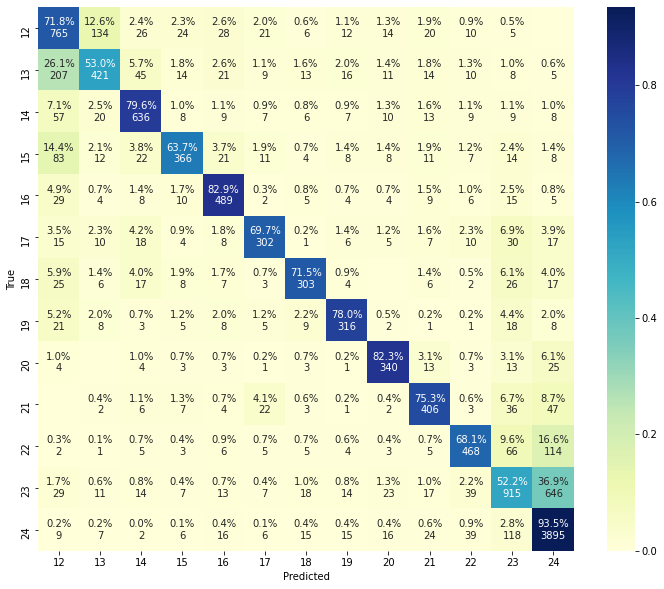

[I 2021-01-09 22:44:25,307] Trial 25 finished with value: -0.7849023276446871 and parameters: {'boosting': 'gbdt', 'num_leaves': 1079, 'max_depth': 13, 'max_bin': 158, 'min_data_in_leaf': 71, 'min_data_in_bin': 117, 'min_gain_to_split': 0.92, 'lamda_l1': 9.26773059543751e-06, 'lamda_l2': 1.1314562181458954e-08, 'learning_rate': 0.009426216220256975, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.8, 'feature_fraction': 0.59}. Best is trial 25 with value: -0.7849023276446871.


Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.352397	valid_1's multi_logloss: 0.808054
                                                                                  FOLD0-val acc: 77.93464310395893  FOLD0-test acc: 76.069592724397
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.355432	valid_1's multi_logloss: 0.791491
                                                                                  FOLD1-val acc: 78.98114325204857  FOLD1-test acc: 75.94306049822063
Training until validation scores don't improve for 30 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.357473	valid_1's multi_logloss: 0.773271


In [ ]:
study.optimize(optimize, n_trials=200)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
#optimization_function = partial(optimize, X=x, y=y)
study  = optuna.create_study(direction = "minimize")
#study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

study.optimize(optimize, n_trials=500)
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-01-08 23:47:57,909] A new study created in memory with name: no-name-bd6e8a31-e743-4442-979a-1977b3a92123


Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[193]	training's multi_logloss: 0.468724	valid_1's multi_logloss: 0.796338
                                                                                  FOLD0-val acc: 77.07345971563981  FOLD0-test acc: 75.42861657580785
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[205]	training's multi_logloss: 0.477661	valid_1's multi_logloss: 0.804872
                                                                                  FOLD1-val acc: 78.19169960474308  FOLD1-test acc: 75.32590661294145
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[191]	training's multi_logloss: 0.459124	valid_1's multi_logloss: 0.809983
                                                                                  FOLD2-val acc: 76.6403162055336  FOLD2-test acc: 75.47602117405388
Training until validation scores do

[I 2021-01-08 23:50:28,344] Trial 0 finished with value: -0.7771851114627377 and parameters: {'boosting': 'gbdt', 'num_leaves': 1929, 'max_depth': 7, 'max_bin': 56, 'min_data_in_leaf': 115, 'min_data_in_bin': 153, 'min_gain_to_split': 1.6800000000000002, 'lamda_l1': 5.8965770934112205e-05, 'lamda_l2': 0.0002608126268165675, 'learning_rate': 0.07053769819968045, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.88, 'feature_fraction': 0.75}. Best is trial 0 with value: -0.7771851114627377.


 FOLD4-test acc: 75.50762423955123
=================================================================================> TTA on test acc: 75.74464723078138
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[102]	training's multi_logloss: 0.377563	valid_1's multi_logloss: 0.858791
                                                                                  FOLD0-val acc: 77.40916271721959  FOLD0-test acc: 74.50422691001027
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[113]	training's multi_logloss: 0.354753	valid_1's multi_logloss: 0.849807
                                                                                  FOLD1-val acc: 78.39920948616601  FOLD1-test acc: 74.65434147112269
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[69]	training's multi_logloss: 0.455653	valid_1's multi_logloss: 0.860343
                                

[I 2021-01-08 23:52:05,229] Trial 1 finished with value: -0.7736678951181869 and parameters: {'boosting': 'goss', 'num_leaves': 1026, 'max_depth': 13, 'max_bin': 161, 'min_data_in_leaf': 241, 'min_data_in_bin': 253, 'min_gain_to_split': 2.6100000000000003, 'lamda_l1': 1.031963980811072e-05, 'lamda_l2': 5.204206990396357e-07, 'learning_rate': 0.13289396751737356, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.59, 'feature_fraction': 0.73}. Best is trial 0 with value: -0.7771851114627377.


 FOLD4-test acc: 74.30670775065181
=================================================================================> TTA on test acc: 75.79995259540175
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.132983	valid_1's multi_logloss: 0.696997
                                                                                  FOLD0-val acc: 78.39652448657188  FOLD0-test acc: 74.0143793948013
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[87]	training's multi_logloss: 0.151166	valid_1's multi_logloss: 0.693364
                                                                                  FOLD1-val acc: 78.15217391304347  FOLD1-test acc: 74.44892154538991
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[66]	training's multi_logloss: 0.173447	valid_1's multi_logloss: 0.738779
                                  

[I 2021-01-08 23:53:22,959] Trial 2 finished with value: -0.7813725087314296 and parameters: {'boosting': 'goss', 'num_leaves': 149, 'max_depth': 14, 'max_bin': 49, 'min_data_in_leaf': 114, 'min_data_in_bin': 203, 'min_gain_to_split': 0.78, 'lamda_l1': 8.50490374028516e-06, 'lamda_l2': 3.602209803121254e-07, 'learning_rate': 0.3169001769649936, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.53, 'feature_fraction': 0.64}. Best is trial 2 with value: -0.7813725087314296.


 FOLD4-test acc: 73.80105870269416
=================================================================================> TTA on test acc: 75.63403650154065
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[154]	training's multi_error: 0.0306264	valid_1's multi_error: 0.213863
                                                                                  FOLD0-val acc: 78.61374407582939  FOLD0-test acc: 75.2310974164494
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[146]	training's multi_error: 0.0376827	valid_1's multi_error: 0.211759
                                                                                  FOLD1-val acc: 78.82411067193675  FOLD1-test acc: 75.74464723078138
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[221]	training's multi_error: 0.0244962	valid_1's multi_error: 0.226779
                                         

[I 2021-01-08 23:57:28,411] Trial 3 finished with value: -0.7857783741611881 and parameters: {'boosting': 'gbdt', 'num_leaves': 662, 'max_depth': 17, 'max_bin': 66, 'min_data_in_leaf': 175, 'min_data_in_bin': 199, 'min_gain_to_split': 0.41000000000000003, 'lamda_l1': 6.909430892700589e-07, 'lamda_l2': 7.552321040976541e-06, 'learning_rate': 0.05413982627618566, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.72, 'feature_fraction': 0.8500000000000001}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.19949435095205
=================================================================================> TTA on test acc: 75.99747175476021
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[439]	training's multi_logloss: 0.592171	valid_1's multi_logloss: 0.890274
                                                                                  FOLD0-val acc: 74.90126382306477  FOLD0-test acc: 72.18140159595481
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[288]	training's multi_logloss: 0.660845	valid_1's multi_logloss: 0.924099
                                                                                  FOLD1-val acc: 75.18774703557312  FOLD1-test acc: 72.52113455005136
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[281]	training's multi_logloss: 0.656966	valid_1's multi_logloss: 0.912035
                               

[I 2021-01-08 23:59:42,389] Trial 4 finished with value: -0.7475096705367367 and parameters: {'boosting': 'goss', 'num_leaves': 819, 'max_depth': 2, 'max_bin': 207, 'min_data_in_leaf': 246, 'min_data_in_bin': 59, 'min_gain_to_split': 4.109999999999999, 'lamda_l1': 0.0018090051484406877, 'lamda_l2': 0.00017388751464902293, 'learning_rate': 0.23433237514895486, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.8500000000000001, 'feature_fraction': 0.51}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 72.29201232519554
=================================================================================> TTA on test acc: 73.84056253456586
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[58]	training's multi_error: 0.117393	valid_1's multi_error: 0.228574
                                                                                  FOLD0-val acc: 77.14257503949446  FOLD0-test acc: 74.98617365884492
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[53]	training's multi_error: 0.117987	valid_1's multi_error: 0.224506
                                                                                  FOLD1-val acc: 77.5494071146245  FOLD1-test acc: 75.50762423955123
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[57]	training's multi_error: 0.117271	valid_1's multi_error: 0.243379
                                               

[I 2021-01-09 00:00:40,502] Trial 5 finished with value: -0.7726993827636595 and parameters: {'boosting': 'gbdt', 'num_leaves': 1611, 'max_depth': 11, 'max_bin': 204, 'min_data_in_leaf': 131, 'min_data_in_bin': 199, 'min_gain_to_split': 2.06, 'lamda_l1': 0.015258079502677862, 'lamda_l2': 2.5725838385399553e-07, 'learning_rate': 0.2145742734641213, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.63, 'feature_fraction': 0.69}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 74.93876906059887
=================================================================================> TTA on test acc: 75.90266255826815
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[73]	training's multi_logloss: 0.503073	valid_1's multi_logloss: 0.825056
                                                                                  FOLD0-val acc: 77.14257503949446  FOLD0-test acc: 75.18369281820337
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[62]	training's multi_logloss: 0.510838	valid_1's multi_logloss: 0.838336
                                                                                  FOLD1-val acc: 77.37154150197628  FOLD1-test acc: 75.19949435095205
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[69]	training's multi_logloss: 0.499677	valid_1's multi_logloss: 0.844933
                                  

[I 2021-01-09 00:01:45,523] Trial 6 finished with value: -0.7712770825276922 and parameters: {'boosting': 'gbdt', 'num_leaves': 852, 'max_depth': 13, 'max_bin': 166, 'min_data_in_leaf': 123, 'min_data_in_bin': 204, 'min_gain_to_split': 3.44, 'lamda_l1': 4.687108066790608e-06, 'lamda_l2': 0.00011444299474789632, 'learning_rate': 0.12267467485842612, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.99, 'feature_fraction': 0.67}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.00197519159359
=================================================================================> TTA on test acc: 75.55502883779727
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[167]	training's multi_error: 0.0384558	valid_1's multi_error: 0.21564
                                                                                  FOLD0-val acc: 78.43601895734598  FOLD0-test acc: 75.5629296041716
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[137]	training's multi_error: 0.0392631	valid_1's multi_error: 0.216206
                                                                                  FOLD1-val acc: 78.3794466403162  FOLD1-test acc: 75.55502883779727
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[132]	training's multi_error: 0.0381766	valid_1's multi_error: 0.230138
                                           

[I 2021-01-09 00:04:15,076] Trial 7 finished with value: -0.7838616591020868 and parameters: {'boosting': 'gbdt', 'num_leaves': 770, 'max_depth': 20, 'max_bin': 237, 'min_data_in_leaf': 74, 'min_data_in_bin': 131, 'min_gain_to_split': 0.83, 'lamda_l1': 0.1375268986264524, 'lamda_l2': 0.002533869709769033, 'learning_rate': 0.08456294895416908, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.77, 'feature_fraction': 0.65}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.30220431381845
=================================================================================> TTA on test acc: 76.05277711938058
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.266497	valid_1's multi_logloss: 0.674499
                                                                                  FOLD0-val acc: 78.17930489731437  FOLD0-test acc: 75.51552500592558
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[948]	training's multi_logloss: 0.268543	valid_1's multi_logloss: 0.667467
                                                                                  FOLD1-val acc: 78.48814229249011  FOLD1-test acc: 75.72884569803271
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.265049	valid_1's multi_logloss: 0.716643
   

[I 2021-01-09 00:17:50,484] Trial 8 finished with value: -0.7828543472353442 and parameters: {'boosting': 'gbdt', 'num_leaves': 37, 'max_depth': 18, 'max_bin': 226, 'min_data_in_leaf': 208, 'min_data_in_bin': 69, 'min_gain_to_split': 0.72, 'lamda_l1': 0.0038381042030756034, 'lamda_l2': 0.03297802465603155, 'learning_rate': 0.02060759426737222, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.75}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.4602196413052
=================================================================================> TTA on test acc: 76.05277711938058
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.272766	valid_1's multi_logloss: 0.870288
                                                                                  FOLD0-val acc: 78.24842022116904  FOLD0-test acc: 74.97827289247057
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[113]	training's multi_logloss: 0.316926	valid_1's multi_logloss: 0.882248
                                                                                  FOLD1-val acc: 78.10276679841898  FOLD1-test acc: 75.92636485739118
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[123]	training's multi_logloss: 0.29369	valid_1's multi_logloss: 0.89938
                                  

[I 2021-01-09 00:21:14,658] Trial 9 finished with value: -0.7800488352326302 and parameters: {'boosting': 'goss', 'num_leaves': 578, 'max_depth': 19, 'max_bin': 105, 'min_data_in_leaf': 26, 'min_data_in_bin': 74, 'min_gain_to_split': 1.9900000000000002, 'lamda_l1': 0.0012680111936354858, 'lamda_l2': 1.0445053176925332e-07, 'learning_rate': 0.031589035283887054, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.96, 'feature_fraction': 0.9}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.62613573516632
=================================================================================> TTA on test acc: 76.42411313897448
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[728]	training's multi_error: 0.113268	valid_1's multi_error: 0.222848
                                                                                  FOLD0-val acc: 77.7152448657188  FOLD0-test acc: 75.71304416528403
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_error: 0.0750444	valid_1's multi_error: 0.21917
                                                                                  FOLD1-val acc: 78.08300395256917  FOLD1-test acc: 76.02907482025756
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[657]	training's multi_error: 0.123815	valid_1's multi_error: 0.245356
                              

[I 2021-01-09 00:44:53,439] Trial 10 finished with value: -0.7747932297004855 and parameters: {'boosting': 'gbdt', 'num_leaves': 1331, 'max_depth': 25, 'max_bin': 105, 'min_data_in_leaf': 179, 'min_data_in_bin': 252, 'min_gain_to_split': 0.19, 'lamda_l1': 1.8745151396743597e-08, 'lamda_l2': 4.506839381179659, 'learning_rate': 0.005650918176190488, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.71, 'feature_fraction': 1.0}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.38911274393615
=================================================================================> TTA on test acc: 76.02907482025756
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[366]	training's multi_error: 0.118603	valid_1's multi_error: 0.224032
                                                                                  FOLD0-val acc: 77.59676145339652  FOLD0-test acc: 75.87896025914513
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[329]	training's multi_error: 0.125074	valid_1's multi_error: 0.223221
                                                                                  FOLD1-val acc: 77.67786561264822  FOLD1-test acc: 75.665639567038
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[416]	training's multi_error: 0.110233	valid_1's multi_error: 0.241502
                                             

[I 2021-01-09 00:55:14,511] Trial 11 finished with value: -0.7734104550822052 and parameters: {'boosting': 'gbdt', 'num_leaves': 442, 'max_depth': 24, 'max_bin': 255, 'min_data_in_leaf': 33, 'min_data_in_bin': 128, 'min_gain_to_split': 0.23, 'lamda_l1': 7.7785125732522005, 'lamda_l2': 0.017603388551162176, 'learning_rate': 0.014221582442809404, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.73, 'feature_fraction': 0.8500000000000001}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.52342577229992
=================================================================================> TTA on test acc: 76.02907482025756
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[270]	training's multi_error: 0.0849881	valid_1's multi_error: 0.217121
                                                                                  FOLD0-val acc: 78.28791469194313  FOLD0-test acc: 75.58663190329462
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[421]	training's multi_error: 0.083391	valid_1's multi_error: 0.215415
                                                                                  FOLD1-val acc: 78.44861660079052  FOLD1-test acc: 75.72094493165838
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[305]	training's multi_error: 0.0823291	valid_1's multi_error: 0.229644
                                         

[I 2021-01-09 00:58:39,819] Trial 12 finished with value: -0.7830321582576304 and parameters: {'boosting': 'gbdt', 'num_leaves': 432, 'max_depth': 20, 'max_bin': 98, 'min_data_in_leaf': 65, 'min_data_in_bin': 129, 'min_gain_to_split': 1.1, 'lamda_l1': 0.925003844693319, 'lamda_l2': 0.03379084697710592, 'learning_rate': 0.04421079298366872, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.67, 'feature_fraction': 0.55}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.44441810855653
=================================================================================> TTA on test acc: 76.18709014774433
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[223]	training's multi_error: 0.00476684	valid_1's multi_error: 0.223637
                                                                                  FOLD0-val acc: 77.63625592417061  FOLD0-test acc: 75.04147902346527
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[62]	training's multi_error: 0.105344	valid_1's multi_error: 0.223617
                                                                                  FOLD1-val acc: 77.63833992094862  FOLD1-test acc: 75.69724263253535
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[218]	training's multi_error: 0.00483998	valid_1's multi_error: 0.231423
                                        

[I 2021-01-09 01:02:48,807] Trial 13 finished with value: -0.7777968074211827 and parameters: {'boosting': 'gbdt', 'num_leaves': 1165, 'max_depth': 21, 'max_bin': 36, 'min_data_in_leaf': 166, 'min_data_in_bin': 9, 'min_gain_to_split': 0.15000000000000002, 'lamda_l1': 3.1273372981099586e-08, 'lamda_l2': 1.6258551178526864e-05, 'learning_rate': 0.07666672071695492, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.8, 'feature_fraction': 0.8400000000000001}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.19949435095205
=================================================================================> TTA on test acc: 76.13968554949831
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[359]	training's multi_error: 0.0800237	valid_1's multi_error: 0.216627
                                                                                  FOLD0-val acc: 78.33728278041075  FOLD0-test acc: 75.69724263253535
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[360]	training's multi_error: 0.0811191	valid_1's multi_error: 0.218379
                                                                                  FOLD1-val acc: 78.16205533596839  FOLD1-test acc: 75.72884569803271
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[446]	training's multi_error: 0.0730689	valid_1's multi_error: 0.232609
                                        

[I 2021-01-09 01:09:53,299] Trial 14 finished with value: -0.7809376245776297 and parameters: {'boosting': 'gbdt', 'num_leaves': 621, 'max_depth': 16, 'max_bin': 76, 'min_data_in_leaf': 89, 'min_data_in_bin': 166, 'min_gain_to_split': 1.3, 'lamda_l1': 0.21317150838646717, 'lamda_l2': 4.388120570992944e-06, 'learning_rate': 0.011305605030510734, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.78, 'feature_fraction': 0.6}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.2943035474441
=================================================================================> TTA on test acc: 76.13178478312396
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[157]	training's multi_error: 0.130039	valid_1's multi_error: 0.23045
                                                                                  FOLD0-val acc: 76.95497630331754  FOLD0-test acc: 75.42071580943352
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[170]	training's multi_error: 0.126976	valid_1's multi_error: 0.228953
                                                                                  FOLD1-val acc: 77.10474308300395  FOLD1-test acc: 75.78415106265308
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[259]	training's multi_error: 0.123913	valid_1's multi_error: 0.24496
                                              

[I 2021-01-09 01:13:32,756] Trial 15 finished with value: -0.7693011882412871 and parameters: {'boosting': 'gbdt', 'num_leaves': 250, 'max_depth': 23, 'max_bin': 134, 'min_data_in_leaf': 66, 'min_data_in_bin': 105, 'min_gain_to_split': 2.83, 'lamda_l1': 5.358043464281844e-07, 'lamda_l2': 0.0026759494470375194, 'learning_rate': 0.03399283443719803, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.9299999999999999, 'feature_fraction': 0.99}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.47602117405388
=================================================================================> TTA on test acc: 76.13178478312396
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[51]	training's multi_error: 0.0407775	valid_1's multi_error: 0.229759
                                                                                  FOLD0-val acc: 77.0240916271722  FOLD0-test acc: 74.10128782491901
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[55]	training's multi_error: 0.0396829	valid_1's multi_error: 0.223617
                                                                                  FOLD1-val acc: 77.63833992094862  FOLD1-test acc: 74.81235679860947
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[31]	training's multi_error: 0.0496839	valid_1's multi_error: 0.237549
                                            

[I 2021-01-09 01:14:35,654] Trial 16 finished with value: -0.7748137963710646 and parameters: {'boosting': 'gbdt', 'num_leaves': 829, 'max_depth': 9, 'max_bin': 248, 'min_data_in_leaf': 171, 'min_data_in_bin': 171, 'min_gain_to_split': 0.59, 'lamda_l1': 2.551989631034169e-07, 'lamda_l2': 1.4250020794341425, 'learning_rate': 0.45181114310257753, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.74, 'feature_fraction': 0.81}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 74.20399778778541
=================================================================================> TTA on test acc: 75.73674646440705
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[64]	training's multi_error: 0.169309	valid_1's multi_error: 0.237362
                                                                                  FOLD0-val acc: 76.26382306477093  FOLD0-test acc: 74.73334913486607
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[54]	training's multi_error: 0.172511	valid_1's multi_error: 0.231719
                                                                                  FOLD1-val acc: 76.82806324110672  FOLD1-test acc: 75.00987595796792
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[71]	training's multi_error: 0.166757	valid_1's multi_error: 0.250395
                                              

[I 2021-01-09 01:15:53,511] Trial 17 finished with value: -0.7647771827060329 and parameters: {'boosting': 'gbdt', 'num_leaves': 1349, 'max_depth': 17, 'max_bin': 135, 'min_data_in_leaf': 209, 'min_data_in_bin': 228, 'min_gain_to_split': 4.93, 'lamda_l1': 0.05345871122513691, 'lamda_l2': 7.2180136248400285e-06, 'learning_rate': 0.0843082036631585, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.6799999999999999, 'feature_fraction': 0.9299999999999999}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 74.89926522872719
=================================================================================> TTA on test acc: 75.32590661294145
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[177]	training's multi_error: 0.156565	valid_1's multi_error: 0.229068
                                                                                  FOLD0-val acc: 77.09320695102686  FOLD0-test acc: 75.44441810855653
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[133]	training's multi_error: 0.159596	valid_1's multi_error: 0.227273
                                                                                  FOLD1-val acc: 77.27272727272727  FOLD1-test acc: 75.40491427668485
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[177]	training's multi_error: 0.155151	valid_1's multi_error: 0.243577
                                           

[I 2021-01-09 01:17:56,121] Trial 18 finished with value: -0.7710990294846398 and parameters: {'boosting': 'gbdt', 'num_leaves': 706, 'max_depth': 22, 'max_bin': 176, 'min_data_in_leaf': 143, 'min_data_in_bin': 30, 'min_gain_to_split': 1.61, 'lamda_l1': 6.098725961099158, 'lamda_l2': 0.004269205526669053, 'learning_rate': 0.05571606188279706, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.56, 'feature_fraction': 0.59}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.34170814569013
=================================================================================> TTA on test acc: 75.54712807142293
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[60]	training's multi_error: 0.0823454	valid_1's multi_error: 0.225711
                                                                                  FOLD0-val acc: 77.42890995260665  FOLD0-test acc: 75.30220431381845
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[77]	training's multi_error: 0.0789708	valid_1's multi_error: 0.223123
                                                                                  FOLD1-val acc: 77.68774703557312  FOLD1-test acc: 75.4365173421822
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[85]	training's multi_error: 0.0776126	valid_1's multi_error: 0.237846
                                            

[I 2021-01-09 01:19:25,504] Trial 19 finished with value: -0.7751493277377343 and parameters: {'boosting': 'gbdt', 'num_leaves': 314, 'max_depth': 16, 'max_bin': 73, 'min_data_in_leaf': 81, 'min_data_in_bin': 100, 'min_gain_to_split': 1.3, 'lamda_l1': 0.00012577276615528097, 'lamda_l2': 0.39343781507281295, 'learning_rate': 0.12941880993882263, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.89, 'feature_fraction': 0.81}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.4365173421822
=================================================================================> TTA on test acc: 76.10018171762661
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[479]	training's multi_error: 0.154959	valid_1's multi_error: 0.227093
                                                                                  FOLD0-val acc: 77.29067930489731  FOLD0-test acc: 75.69724263253535
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[846]	training's multi_error: 0.0978615	valid_1's multi_error: 0.212945
                                                                                  FOLD1-val acc: 78.70553359683794  FOLD1-test acc: 75.76044876353006
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[906]	training's multi_error: 0.0870456	valid_1's multi_error: 0.228063
                                          

[I 2021-01-09 01:32:33,540] Trial 20 finished with value: -0.7812355658081243 and parameters: {'boosting': 'gbdt', 'num_leaves': 1056, 'max_depth': 5, 'max_bin': 227, 'min_data_in_leaf': 197, 'min_data_in_bin': 144, 'min_gain_to_split': 0.12000000000000001, 'lamda_l1': 2.4726197336934095e-07, 'lamda_l2': 1.4684802459915122e-08, 'learning_rate': 0.026606462504772027, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.64, 'feature_fraction': 0.9299999999999999}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.59453266966895
=================================================================================> TTA on test acc: 76.36090700797978
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[163]	training's multi_error: 0.0775538	valid_1's multi_error: 0.217911
                                                                                  FOLD0-val acc: 78.20892575039494  FOLD0-test acc: 75.3338073793158
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[159]	training's multi_error: 0.077662	valid_1's multi_error: 0.214229
                                                                                  FOLD1-val acc: 78.57707509881423  FOLD1-test acc: 75.86315872639646
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[174]	training's multi_error: 0.0739085	valid_1's multi_error: 0.229447
                                          

[I 2021-01-09 01:35:38,701] Trial 21 finished with value: -0.7846127408023049 and parameters: {'boosting': 'gbdt', 'num_leaves': 406, 'max_depth': 20, 'max_bin': 101, 'min_data_in_leaf': 54, 'min_data_in_bin': 116, 'min_gain_to_split': 1.06, 'lamda_l1': 0.34963550054999903, 'lamda_l2': 0.16343350748608287, 'learning_rate': 0.0418495856837456, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.66, 'feature_fraction': 0.5}. Best is trial 3 with value: -0.7857783741611881.


 FOLD4-test acc: 75.31010508019278
=================================================================================> TTA on test acc: 76.25029627873904
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[299]	training's multi_error: 0.0312438	valid_1's multi_error: 0.210111
                                                                                  FOLD0-val acc: 78.98894154818325  FOLD0-test acc: 75.72094493165838
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[126]	training's multi_error: 0.0380531	valid_1's multi_error: 0.21334
                                                                                  FOLD1-val acc: 78.66600790513833  FOLD1-test acc: 75.83155566089911
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[263]	training's multi_error: 0.0316574	valid_1's multi_error: 0.227075
                                         

[I 2021-01-09 01:39:18,203] Trial 22 finished with value: -0.7870224966862708 and parameters: {'boosting': 'gbdt', 'num_leaves': 488, 'max_depth': 20, 'max_bin': 81, 'min_data_in_leaf': 4, 'min_data_in_bin': 97, 'min_gain_to_split': 0.66, 'lamda_l1': 0.6905780148970259, 'lamda_l2': 0.0029873223028801924, 'learning_rate': 0.04539908773938903, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.77, 'feature_fraction': 0.58}. Best is trial 22 with value: -0.7870224966862708.


 FOLD4-test acc: 75.34960891206447
=================================================================================> TTA on test acc: 76.35300624160544
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[155]	training's multi_error: 0.0735033	valid_1's multi_error: 0.212875
                                                                                  FOLD0-val acc: 78.71248025276462  FOLD0-test acc: 75.3338073793158
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[333]	training's multi_error: 0.0586972	valid_1's multi_error: 0.211561
                                                                                  FOLD1-val acc: 78.84387351778656  FOLD1-test acc: 75.86315872639646
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[393]	training's multi_error: 0.0583267	valid_1's multi_error: 0.226186
                                         

[I 2021-01-09 01:43:02,323] Trial 23 finished with value: -0.7866673352952903 and parameters: {'boosting': 'gbdt', 'num_leaves': 467, 'max_depth': 15, 'max_bin': 83, 'min_data_in_leaf': 40, 'min_data_in_bin': 97, 'min_gain_to_split': 0.59, 'lamda_l1': 1.4674031623292725, 'lamda_l2': 0.4377704901782587, 'learning_rate': 0.04293153160854181, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.69, 'feature_fraction': 0.5}. Best is trial 22 with value: -0.7870224966862708.


 FOLD4-test acc: 75.52342577229992
=================================================================================> TTA on test acc: 76.16338784862131
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[431]	training's multi_error: 0.108131	valid_1's multi_error: 0.219491
                                                                                  FOLD0-val acc: 78.05094786729858  FOLD0-test acc: 75.6024334360433
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[360]	training's multi_error: 0.120876	valid_1's multi_error: 0.218379
                                                                                  FOLD1-val acc: 78.16205533596839  FOLD1-test acc: 75.95006715651418
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[589]	training's multi_error: 0.0905768	valid_1's multi_error: 0.230632
                                           

[I 2021-01-09 01:50:46,602] Trial 24 finished with value: -0.7818467387328029 and parameters: {'boosting': 'gbdt', 'num_leaves': 71, 'max_depth': 15, 'max_bin': 71, 'min_data_in_leaf': 2, 'min_data_in_bin': 86, 'min_gain_to_split': 0.45999999999999996, 'lamda_l1': 2.3771047551532263, 'lamda_l2': 7.9997717795111205, 'learning_rate': 0.01751657098365522, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.71, 'feature_fraction': 0.54}. Best is trial 22 with value: -0.7870224966862708.


 FOLD4-test acc: 75.57873113692028
=================================================================================> TTA on test acc: 76.13178478312396
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[131]	training's multi_error: 0.0305276	valid_1's multi_error: 0.216035
                                                                                  FOLD0-val acc: 78.39652448657188  FOLD0-test acc: 75.72884569803271
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[97]	training's multi_error: 0.0419795	valid_1's multi_error: 0.214625
                                                                                  FOLD1-val acc: 78.53754940711462  FOLD1-test acc: 75.76044876353006
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[246]	training's multi_error: 0.0248913	valid_1's multi_error: 0.223715
                                         

[I 2021-01-09 01:53:55,806] Trial 25 finished with value: -0.7857390513499949 and parameters: {'boosting': 'gbdt', 'num_leaves': 516, 'max_depth': 11, 'max_bin': 33, 'min_data_in_leaf': 17, 'min_data_in_bin': 54, 'min_gain_to_split': 0.51, 'lamda_l1': 0.018725994847756357, 'lamda_l2': 3.682665186592764e-05, 'learning_rate': 0.055402611682582585, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.61, 'feature_fraction': 0.59}. Best is trial 22 with value: -0.7870224966862708.


 FOLD4-test acc: 75.34170814569013
=================================================================================> TTA on test acc: 76.35300624160544
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[787]	training's multi_error: 0.0967694	valid_1's multi_error: 0.218108
                                                                                  FOLD0-val acc: 78.1891785150079  FOLD0-test acc: 75.68144109978668
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[727]	training's multi_error: 0.098306	valid_1's multi_error: 0.215613
                                                                                  FOLD1-val acc: 78.43873517786561  FOLD1-test acc: 75.85525796002213
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[700]	training's multi_error: 0.100207	valid_1's multi_error: 0.233597
                                           

[I 2021-01-09 02:05:00,567] Trial 26 finished with value: -0.7807205767466365 and parameters: {'boosting': 'goss', 'num_leaves': 238, 'max_depth': 18, 'max_bin': 87, 'min_data_in_leaf': 41, 'min_data_in_bin': 39, 'min_gain_to_split': 2.09, 'lamda_l1': 0.9471385110431487, 'lamda_l2': 2.327584826871123e-06, 'learning_rate': 0.008868324881839657, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.8200000000000001, 'feature_fraction': 0.55}. Best is trial 22 with value: -0.7870224966862708.


 FOLD4-test acc: 75.75254799715573
=================================================================================> TTA on test acc: 76.06067788575493
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[197]	training's multi_error: 0.038036	valid_1's multi_error: 0.213665
                                                                                  FOLD0-val acc: 78.63349131121643  FOLD0-test acc: 75.72094493165838
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[213]	training's multi_error: 0.0388927	valid_1's multi_error: 0.212945
                                                                                  FOLD1-val acc: 78.70553359683794  FOLD1-test acc: 75.95006715651418
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[188]	training's multi_error: 0.0350158	valid_1's multi_error: 0.229051
                                         

[I 2021-01-09 02:08:46,715] Trial 27 finished with value: -0.7841186621129559 and parameters: {'boosting': 'gbdt', 'num_leaves': 638, 'max_depth': 12, 'max_bin': 117, 'min_data_in_leaf': 3, 'min_data_in_bin': 92, 'min_gain_to_split': 1.3800000000000001, 'lamda_l1': 0.0003303607495481042, 'lamda_l2': 0.31440825291741736, 'learning_rate': 0.0235836527983357, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.75, 'feature_fraction': 0.5}. Best is trial 22 with value: -0.7870224966862708.


 FOLD4-test acc: 75.3575096784388
=================================================================================> TTA on test acc: 76.18709014774433
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[244]	training's multi_error: 0.163975	valid_1's multi_error: 0.234301
                                                                                  FOLD0-val acc: 76.56990521327015  FOLD0-test acc: 75.61033420241763
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[309]	training's multi_error: 0.16293	valid_1's multi_error: 0.228261
                                                                                  FOLD1-val acc: 77.17391304347827  FOLD1-test acc: 75.47602117405388
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[348]	training's multi_error: 0.156139	valid_1's multi_error: 0.249308
                                             

[I 2021-01-09 02:13:09,493] Trial 28 finished with value: -0.7674244750515928 and parameters: {'boosting': 'gbdt', 'num_leaves': 950, 'max_depth': 15, 'max_bin': 52, 'min_data_in_leaf': 148, 'min_data_in_bin': 181, 'min_gain_to_split': 0.88, 'lamda_l1': 9.626935732091553, 'lamda_l2': 0.0005403341088951927, 'learning_rate': 0.038714241309512835, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.69, 'feature_fraction': 0.89}. Best is trial 22 with value: -0.7870224966862708.


 FOLD4-test acc: 75.41281504305918
=================================================================================> TTA on test acc: 75.68144109978668
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[207]	training's multi_error: 0.129199	valid_1's multi_error: 0.223242
                                                                                  FOLD0-val acc: 77.67575039494471  FOLD0-test acc: 75.30220431381845
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[224]	training's multi_error: 0.130161	valid_1's multi_error: 0.220455
                                                                                  FOLD1-val acc: 77.95454545454545  FOLD1-test acc: 75.50762423955123
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[148]	training's multi_error: 0.126235	valid_1's multi_error: 0.232609
                                           

[I 2021-01-09 02:15:45,471] Trial 29 finished with value: -0.7781327680169848 and parameters: {'boosting': 'gbdt', 'num_leaves': 537, 'max_depth': 7, 'max_bin': 62, 'min_data_in_leaf': 97, 'min_data_in_bin': 161, 'min_gain_to_split': 1.6800000000000002, 'lamda_l1': 1.5977840972011532e-06, 'lamda_l2': 0.0007041282831583997, 'learning_rate': 0.06197208890136128, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.88, 'feature_fraction': 0.79}. Best is trial 22 with value: -0.7870224966862708.


 FOLD4-test acc: 75.41281504305918
=================================================================================> TTA on test acc: 75.81575412815043
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[51]	training's multi_error: 0.00654515	valid_1's multi_error: 0.216035
                                                                                  FOLD0-val acc: 78.39652448657188  FOLD0-test acc: 75.31010508019278
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[77]	training's multi_error: 0.00321019	valid_1's multi_error: 0.213142
                                                                                  FOLD1-val acc: 78.68577075098814  FOLD1-test acc: 75.53132653867425
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[73]	training's multi_error: 0.00232122	valid_1's multi_error: 0.233794
                                        

[I 2021-01-09 02:17:39,146] Trial 30 finished with value: -0.7807798576053925 and parameters: {'boosting': 'gbdt', 'num_leaves': 207, 'max_depth': 22, 'max_bin': 120, 'min_data_in_leaf': 11, 'min_data_in_bin': 114, 'min_gain_to_split': 0.45999999999999996, 'lamda_l1': 4.4601491207295056e-05, 'lamda_l2': 8.284491660513559e-05, 'learning_rate': 0.10111678742547378, 'metric': 'multi_error', 'objective': 'multiclassova', 'bagging_fraction': 0.77, 'feature_fraction': 0.73}. Best is trial 22 with value: -0.7870224966862708.


 FOLD4-test acc: 75.00987595796792
=================================================================================> TTA on test acc: 76.41621237260014
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[132]	training's multi_error: 0.0263782	valid_1's multi_error: 0.215146
                                                                                  FOLD0-val acc: 78.48538704581358  FOLD0-test acc: 75.44441810855653
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[119]	training's multi_error: 0.0323242	valid_1's multi_error: 0.211858
                                                                                  FOLD1-val acc: 78.81422924901186  FOLD1-test acc: 76.09228095125226
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[254]	training's multi_error: 0.012174	valid_1's multi_error: 0.225494
                                         

[I 2021-01-09 02:20:55,597] Trial 31 finished with value: -0.7860551398143726 and parameters: {'boosting': 'gbdt', 'num_leaves': 491, 'max_depth': 10, 'max_bin': 41, 'min_data_in_leaf': 18, 'min_data_in_bin': 55, 'min_gain_to_split': 0.36, 'lamda_l1': 0.017423855231449823, 'lamda_l2': 2.54965424718611e-05, 'learning_rate': 0.054412413971537815, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.61, 'feature_fraction': 0.6}. Best is trial 22 with value: -0.7870224966862708.


 FOLD4-test acc: 75.46812040767954
=================================================================================> TTA on test acc: 76.43991467172316
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[188]	training's multi_error: 0.0281812	valid_1's multi_error: 0.215936
                                                                                  FOLD0-val acc: 78.4063981042654  FOLD0-test acc: 75.36541044481315
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[129]	training's multi_error: 0.0645496	valid_1's multi_error: 0.21166
                                                                                  FOLD1-val acc: 78.83399209486166  FOLD1-test acc: 76.21869321324168
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[300]	training's multi_error: 0.00861814	valid_1's multi_error: 0.225889
                                         

[I 2021-01-09 02:25:11,870] Trial 32 finished with value: -0.7853440052636779 and parameters: {'boosting': 'gbdt', 'num_leaves': 353, 'max_depth': 9, 'max_bin': 42, 'min_data_in_leaf': 42, 'min_data_in_bin': 13, 'min_gain_to_split': 0.19, 'lamda_l1': 0.027684024806397953, 'lamda_l2': 1.8106562635381411e-06, 'learning_rate': 0.05001557712281658, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.58, 'feature_fraction': 0.62}. Best is trial 22 with value: -0.7870224966862708.


 FOLD4-test acc: 75.59453266966895
=================================================================================> TTA on test acc: 76.16338784862131
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[266]	training's multi_error: 0.135126	valid_1's multi_error: 0.225118
                                                                                  FOLD0-val acc: 77.48815165876776  FOLD0-test acc: 75.81575412815043
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[270]	training's multi_error: 0.13384	valid_1's multi_error: 0.220652
                                                                                  FOLD1-val acc: 77.93478260869566  FOLD1-test acc: 75.665639567038
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[365]	training's multi_error: 0.121592	valid_1's multi_error: 0.237055
                                              

[I 2021-01-09 02:29:17,265] Trial 33 finished with value: -0.7772238175403817 and parameters: {'boosting': 'gbdt', 'num_leaves': 710, 'max_depth': 14, 'max_bin': 62, 'min_data_in_leaf': 224, 'min_data_in_bin': 43, 'min_gain_to_split': 0.99, 'lamda_l1': 1.6576043720805178, 'lamda_l2': 2.1117171688476222e-05, 'learning_rate': 0.029298101806310473, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.51, 'feature_fraction': 0.53}. Best is trial 22 with value: -0.7870224966862708.


 FOLD4-test acc: 75.5392273050486
=================================================================================> TTA on test acc: 76.05277711938058
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[202]	training's multi_error: 0.00456926	valid_1's multi_error: 0.212974
                                                                                  FOLD0-val acc: 78.70260663507109  FOLD0-test acc: 74.43312001264123
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[257]	training's multi_error: 0.00276571	valid_1's multi_error: 0.205534
                                                                                  FOLD1-val acc: 79.44664031620553  FOLD1-test acc: 75.2547997155724
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[215]	training's multi_error: 0.00375346	valid_1's multi_error: 0.22164
                                        

[I 2021-01-09 02:31:55,766] Trial 34 finished with value: -0.7900660450431138 and parameters: {'boosting': 'goss', 'num_leaves': 480, 'max_depth': 9, 'max_bin': 88, 'min_data_in_leaf': 105, 'min_data_in_bin': 78, 'min_gain_to_split': 0.45999999999999996, 'lamda_l1': 0.007905124586346558, 'lamda_l2': 0.0006878902148937115, 'learning_rate': 0.18649765123935805, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.55, 'feature_fraction': 0.5700000000000001}. Best is trial 34 with value: -0.7900660450431138.


 FOLD4-test acc: 74.67804377024572
=================================================================================> TTA on test acc: 75.64193726791498
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[319]	training's multi_error: 0.0210186	valid_1's multi_error: 0.209419
                                                                                  FOLD0-val acc: 79.05805687203792  FOLD0-test acc: 73.39021885122857
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[215]	training's multi_error: 0.0403991	valid_1's multi_error: 0.205632
                                                                                  FOLD1-val acc: 79.43675889328064  FOLD1-test acc: 74.22770008690843
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[397]	training's multi_error: 0.0128408	valid_1's multi_error: 0.21581
                                         

[I 2021-01-09 02:34:35,161] Trial 35 finished with value: -0.7916071099757829 and parameters: {'boosting': 'goss', 'num_leaves': 88, 'max_depth': 5, 'max_bin': 81, 'min_data_in_leaf': 106, 'min_data_in_bin': 69, 'min_gain_to_split': 0.69, 'lamda_l1': 0.006360493792541385, 'lamda_l2': 0.0008167279650077202, 'learning_rate': 0.22483997505788997, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.56, 'feature_fraction': 0.56}. Best is trial 35 with value: -0.7916071099757829.


 FOLD4-test acc: 73.9511732638066
=================================================================================> TTA on test acc: 75.17579205182902
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[522]	training's multi_error: 0.171187	valid_1's multi_error: 0.236078
                                                                                  FOLD0-val acc: 76.39218009478674  FOLD0-test acc: 73.6035395433357
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[711]	training's multi_error: 0.151719	valid_1's multi_error: 0.220949
                                                                                  FOLD1-val acc: 77.90513833992095  FOLD1-test acc: 73.39021885122857
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[583]	training's multi_error: 0.164238	valid_1's multi_error: 0.243676
                                             

[I 2021-01-09 02:37:48,140] Trial 36 finished with value: -0.7655884198888284 and parameters: {'boosting': 'goss', 'num_leaves': 39, 'max_depth': 2, 'max_bin': 87, 'min_data_in_leaf': 108, 'min_data_in_bin': 82, 'min_gain_to_split': 2.4000000000000004, 'lamda_l1': 0.003746817683983736, 'lamda_l2': 0.011619449393167634, 'learning_rate': 0.19072563320017483, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.5, 'feature_fraction': 0.56}. Best is trial 35 with value: -0.7916071099757829.


 FOLD4-test acc: 73.76155487082247
=================================================================================> TTA on test acc: 74.20399778778541
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[201]	training's multi_logloss: 0.231766	valid_1's multi_logloss: 0.693508
                                                                                  FOLD0-val acc: 78.22867298578198  FOLD0-test acc: 73.05048589713202
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[245]	training's multi_logloss: 0.19251	valid_1's multi_logloss: 0.690089
                                                                                  FOLD1-val acc: 79.06126482213439  FOLD1-test acc: 73.39021885122857
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[206]	training's multi_logloss: 0.22162	valid_1's multi_logloss: 0.730138
                                 

[I 2021-01-09 02:39:49,446] Trial 37 finished with value: -0.7842181710293846 and parameters: {'boosting': 'goss', 'num_leaves': 177, 'max_depth': 4, 'max_bin': 86, 'min_data_in_leaf': 101, 'min_data_in_bin': 66, 'min_gain_to_split': 0.69, 'lamda_l1': 0.000531320477200749, 'lamda_l2': 0.000952234746445023, 'learning_rate': 0.3500273489726562, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.53, 'feature_fraction': 0.69}. Best is trial 35 with value: -0.7916071099757829.


 FOLD4-test acc: 72.86086750414789
=================================================================================> TTA on test acc: 74.83605909773247
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[131]	training's multi_error: 0.0687611	valid_1's multi_error: 0.217121
                                                                                  FOLD0-val acc: 78.28791469194313  FOLD0-test acc: 74.66224223749704
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[444]	training's multi_error: 0.0309166	valid_1's multi_error: 0.205336
                                                                                  FOLD1-val acc: 79.46640316205533  FOLD1-test acc: 74.80445603223512
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[281]	training's multi_error: 0.0386705	valid_1's multi_error: 0.221443
                                        

[I 2021-01-09 02:42:29,109] Trial 38 finished with value: -0.7890984071273769 and parameters: {'boosting': 'goss', 'num_leaves': 2032, 'max_depth': 7, 'max_bin': 152, 'min_data_in_leaf': 121, 'min_data_in_bin': 94, 'min_gain_to_split': 1.4300000000000002, 'lamda_l1': 0.07449555944211324, 'lamda_l2': 0.0002654058156625166, 'learning_rate': 0.1648502096430809, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.56, 'feature_fraction': 0.52}. Best is trial 35 with value: -0.7916071099757829.


 FOLD4-test acc: 74.53582997550762
=================================================================================> TTA on test acc: 75.4365173421822
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[239]	training's multi_error: 0.0470263	valid_1's multi_error: 0.209321
                                                                                  FOLD0-val acc: 79.06793048973144  FOLD0-test acc: 74.18819625503674
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[374]	training's multi_error: 0.0353615	valid_1's multi_error: 0.203755
                                                                                  FOLD1-val acc: 79.62450592885375  FOLD1-test acc: 74.61483763925101
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[277]	training's multi_error: 0.0417572	valid_1's multi_error: 0.220949
                                         

[I 2021-01-09 02:45:02,799] Trial 39 finished with value: -0.7904215422471585 and parameters: {'boosting': 'goss', 'num_leaves': 2008, 'max_depth': 6, 'max_bin': 152, 'min_data_in_leaf': 124, 'min_data_in_bin': 28, 'min_gain_to_split': 1.5000000000000002, 'lamda_l1': 0.07425135159501081, 'lamda_l2': 0.00012315494858136785, 'learning_rate': 0.17283519220769694, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.55, 'feature_fraction': 0.64}. Best is trial 35 with value: -0.7916071099757829.


 FOLD4-test acc: 74.70964683574307
=================================================================================> TTA on test acc: 75.40491427668485
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[586]	training's multi_logloss: 0.248327	valid_1's multi_logloss: 0.661331
                                                                                  FOLD0-val acc: 78.42614533965245  FOLD0-test acc: 73.99857786205261
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[409]	training's multi_logloss: 0.259933	valid_1's multi_logloss: 0.655582
                                                                                  FOLD1-val acc: 79.01185770750988  FOLD1-test acc: 74.58323457375366
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[279]	training's multi_logloss: 0.278959	valid_1's multi_logloss: 0.702741
                               

[I 2021-01-09 02:48:08,190] Trial 40 finished with value: -0.7859565832225199 and parameters: {'boosting': 'goss', 'num_leaves': 1973, 'max_depth': 6, 'max_bin': 153, 'min_data_in_leaf': 119, 'min_data_in_bin': 16, 'min_gain_to_split': 2.41, 'lamda_l1': 0.005862739445561477, 'lamda_l2': 0.00016413731080340568, 'learning_rate': 0.17210260534763103, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.55, 'feature_fraction': 0.65}. Best is trial 35 with value: -0.7916071099757829.


 FOLD4-test acc: 74.67804377024572
=================================================================================> TTA on test acc: 75.23899818282374
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[347]	training's multi_error: 0.0468287	valid_1's multi_error: 0.210506
                                                                                  FOLD0-val acc: 78.94944707740916  FOLD0-test acc: 73.003081298886
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[215]	training's multi_error: 0.0711428	valid_1's multi_error: 0.21166
                                                                                  FOLD1-val acc: 78.83399209486166  FOLD1-test acc: 73.46922651497195
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[219]	training's multi_error: 0.0715132	valid_1's multi_error: 0.227372
                                           

[I 2021-01-09 02:50:20,312] Trial 41 finished with value: -0.7853237039833008 and parameters: {'boosting': 'goss', 'num_leaves': 1834, 'max_depth': 4, 'max_bin': 154, 'min_data_in_leaf': 148, 'min_data_in_bin': 80, 'min_gain_to_split': 1.53, 'lamda_l1': 0.06411404068179848, 'lamda_l2': 0.00024107424243919424, 'learning_rate': 0.3115676217517143, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.58, 'feature_fraction': 0.5700000000000001}. Best is trial 35 with value: -0.7916071099757829.


 FOLD4-test acc: 73.46922651497195
=================================================================================> TTA on test acc: 74.90716599510152
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[182]	training's multi_error: 0.0498419	valid_1's multi_error: 0.216331
                                                                                  FOLD0-val acc: 78.36690363349132  FOLD0-test acc: 74.24350161965711
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[286]	training's multi_error: 0.0436586	valid_1's multi_error: 0.209684
                                                                                  FOLD1-val acc: 79.03162055335969  FOLD1-test acc: 74.03018092754998
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[445]	training's multi_error: 0.040967	valid_1's multi_error: 0.224506
                                         

[I 2021-01-09 02:52:36,705] Trial 42 finished with value: -0.7855616073678661 and parameters: {'boosting': 'goss', 'num_leaves': 1758, 'max_depth': 8, 'max_bin': 185, 'min_data_in_leaf': 131, 'min_data_in_bin': 35, 'min_gain_to_split': 1.9000000000000001, 'lamda_l1': 0.1283534845500609, 'lamda_l2': 0.0014484377952094813, 'learning_rate': 0.2497746205999888, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.53, 'feature_fraction': 0.63}. Best is trial 35 with value: -0.7916071099757829.


 FOLD4-test acc: 74.053883226673
=================================================================================> TTA on test acc: 75.128387453583
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[705]	training's multi_error: 0.0741454	valid_1's multi_error: 0.215837
                                                                                  FOLD0-val acc: 78.41627172195894  FOLD0-test acc: 73.62724184245873
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[597]	training's multi_error: 0.0868234	valid_1's multi_error: 0.208498
                                                                                  FOLD1-val acc: 79.1501976284585  FOLD1-test acc: 74.22770008690843
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[734]	training's multi_error: 0.070723	valid_1's multi_error: 0.220455
                                              

[I 2021-01-09 02:56:42,557] Trial 43 finished with value: -0.7855817372353703 and parameters: {'boosting': 'goss', 'num_leaves': 1605, 'max_depth': 3, 'max_bin': 145, 'min_data_in_leaf': 111, 'min_data_in_bin': 65, 'min_gain_to_split': 1.1800000000000002, 'lamda_l1': 0.327999953752642, 'lamda_l2': 0.0003218693749776462, 'learning_rate': 0.16448371341684154, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.55, 'feature_fraction': 0.52}. Best is trial 35 with value: -0.7916071099757829.


 FOLD4-test acc: 74.30670775065181
=================================================================================> TTA on test acc: 74.8202575649838
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[197]	training's multi_error: 0.0164246	valid_1's multi_error: 0.21722
                                                                                  FOLD0-val acc: 78.2780410742496  FOLD0-test acc: 73.95907403018093
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[261]	training's multi_error: 0.0132359	valid_1's multi_error: 0.206225
                                                                                  FOLD1-val acc: 79.37747035573123  FOLD1-test acc: 74.10918859129335
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[201]	training's multi_error: 0.0173104	valid_1's multi_error: 0.212549
                                           

[I 2021-01-09 02:58:54,338] Trial 44 finished with value: -0.7901065543173212 and parameters: {'boosting': 'goss', 'num_leaves': 2032, 'max_depth': 7, 'max_bin': 125, 'min_data_in_leaf': 131, 'min_data_in_bin': 110, 'min_gain_to_split': 0.9, 'lamda_l1': 0.005839381213170726, 'lamda_l2': 0.009542979145977322, 'learning_rate': 0.2671834420099055, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.5, 'feature_fraction': 0.5700000000000001}. Best is trial 35 with value: -0.7916071099757829.


 FOLD4-test acc: 73.63514260883306
=================================================================================> TTA on test acc: 75.34170814569013
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[162]	training's multi_error: 0.0813327	valid_1's multi_error: 0.233116
                                                                                  FOLD0-val acc: 76.68838862559242  FOLD0-test acc: 72.7976613731532
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[199]	training's multi_error: 0.0762544	valid_1's multi_error: 0.224407
                                                                                  FOLD1-val acc: 77.5592885375494  FOLD1-test acc: 73.1057912617524
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[166]	training's multi_error: 0.0798104	valid_1's multi_error: 0.231225
                                           

[I 2021-01-09 03:00:23,200] Trial 45 finished with value: -0.7747157237220605 and parameters: {'boosting': 'goss', 'num_leaves': 2029, 'max_depth': 6, 'max_bin': 124, 'min_data_in_leaf': 133, 'min_data_in_bin': 115, 'min_gain_to_split': 2.8800000000000003, 'lamda_l1': 0.0009713261906855537, 'lamda_l2': 0.009274891312988321, 'learning_rate': 0.44396738293318805, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.5, 'feature_fraction': 0.62}. Best is trial 35 with value: -0.7916071099757829.


 FOLD4-test acc: 72.76605830765584
=================================================================================> TTA on test acc: 74.74915066761476
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[381]	training's multi_error: 0.0393944	valid_1's multi_error: 0.214751
                                                                                  FOLD0-val acc: 78.52488151658767  FOLD0-test acc: 73.96697479655526
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[319]	training's multi_error: 0.040646	valid_1's multi_error: 0.205435
                                                                                  FOLD1-val acc: 79.45652173913044  FOLD1-test acc: 73.92747096468358
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[363]	training's multi_error: 0.0409176	valid_1's multi_error: 0.222925
                                         

[I 2021-01-09 03:02:57,753] Trial 46 finished with value: -0.7866089602134366 and parameters: {'boosting': 'goss', 'num_leaves': 1858, 'max_depth': 7, 'max_bin': 173, 'min_data_in_leaf': 158, 'min_data_in_bin': 26, 'min_gain_to_split': 1.81, 'lamda_l1': 0.005700552001104006, 'lamda_l2': 9.217518052964613e-05, 'learning_rate': 0.2717856236801879, 'metric': 'multi_error', 'objective': 'multiclass', 'bagging_fraction': 0.6, 'feature_fraction': 0.67}. Best is trial 35 with value: -0.7916071099757829.


 FOLD4-test acc: 73.76945563719681
=================================================================================> TTA on test acc: 75.22319665007505
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[417]	training's multi_logloss: 0.18215	valid_1's multi_logloss: 0.661789
                                                                                  FOLD0-val acc: 78.98894154818325  FOLD0-test acc: 73.84056253456586
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[418]	training's multi_logloss: 0.181738	valid_1's multi_logloss: 0.650948
                                                                                  FOLD1-val acc: 79.82213438735178  FOLD1-test acc: 74.90716599510152
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[311]	training's multi_logloss: 0.22595	valid_1's multi_logloss: 0.689409
                                 

[I 2021-01-09 03:06:33,135] Trial 47 finished with value: -0.7922395209998025 and parameters: {'boosting': 'goss', 'num_leaves': 1669, 'max_depth': 5, 'max_bin': 188, 'min_data_in_leaf': 122, 'min_data_in_bin': 147, 'min_gain_to_split': 0.93, 'lamda_l1': 0.002105036738792151, 'lamda_l2': 0.02991373436840559, 'learning_rate': 0.15040326399659293, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.5700000000000001, 'feature_fraction': 0.52}. Best is trial 47 with value: -0.7922395209998025.


 FOLD4-test acc: 74.51212767638461
=================================================================================> TTA on test acc: 75.23899818282374
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[473]	training's multi_logloss: 0.192701	valid_1's multi_logloss: 0.649739
                                                                                  FOLD0-val acc: 79.16666666666666  FOLD0-test acc: 74.41731847989254
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[543]	training's multi_logloss: 0.172956	valid_1's multi_logloss: 0.642644
                                                                                  FOLD1-val acc: 79.80237154150197  FOLD1-test acc: 74.86766216322984
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[425]	training's multi_logloss: 0.206563	valid_1's multi_logloss: 0.688816
                               

[I 2021-01-09 03:11:27,488] Trial 48 finished with value: -0.7939577643023609 and parameters: {'boosting': 'goss', 'num_leaves': 1653, 'max_depth': 5, 'max_bin': 196, 'min_data_in_leaf': 84, 'min_data_in_bin': 150, 'min_gain_to_split': 0.97, 'lamda_l1': 0.0021007707979388644, 'lamda_l2': 0.0442749874314223, 'learning_rate': 0.10843037654132498, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.64, 'feature_fraction': 0.5700000000000001}. Best is trial 48 with value: -0.7939577643023609.


 FOLD4-test acc: 74.3857154143952
=================================================================================> TTA on test acc: 75.23899818282374
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.257161	valid_1's multi_logloss: 0.661916
                                                                                  FOLD0-val acc: 78.80134281200631  FOLD0-test acc: 73.90376866556055
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.256825	valid_1's multi_logloss: 0.648689
                                                                                  FOLD1-val acc: 79.48616600790514  FOLD1-test acc: 74.46472307813859
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[944]	training's multi_logloss: 0.263669	valid_1's multi_logloss: 0.693507
    

[I 2021-01-09 03:18:25,547] Trial 49 finished with value: -0.7891770137575286 and parameters: {'boosting': 'goss', 'num_leaves': 1630, 'max_depth': 3, 'max_bin': 205, 'min_data_in_leaf': 90, 'min_data_in_bin': 145, 'min_gain_to_split': 0.89, 'lamda_l1': 0.0020202880466523667, 'lamda_l2': 0.05191449476228695, 'learning_rate': 0.11522172412768855, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.52, 'feature_fraction': 0.6799999999999999}. Best is trial 48 with value: -0.7939577643023609.


 FOLD4-test acc: 73.94327249743226
=================================================================================> TTA on test acc: 74.93876906059887
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[181]	training's multi_logloss: 0.162966	valid_1's multi_logloss: 0.701323
                                                                                  FOLD0-val acc: 78.45576619273301  FOLD0-test acc: 73.05048589713202
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[177]	training's multi_logloss: 0.163975	valid_1's multi_logloss: 0.688746
                                                                                  FOLD1-val acc: 79.0909090909091  FOLD1-test acc: 73.15319585999842
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[83]	training's multi_logloss: 0.281063	valid_1's multi_logloss: 0.748356
                                 

[I 2021-01-09 03:20:03,882] Trial 50 finished with value: -0.7834869302581686 and parameters: {'boosting': 'goss', 'num_leaves': 1468, 'max_depth': 5, 'max_bin': 193, 'min_data_in_leaf': 80, 'min_data_in_bin': 186, 'min_gain_to_split': 1.1900000000000002, 'lamda_l1': 0.00011457657244016853, 'lamda_l2': 0.05749680036371301, 'learning_rate': 0.37579576408668486, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.63, 'feature_fraction': 0.71}. Best is trial 48 with value: -0.7939577643023609.


 FOLD4-test acc: 72.91617286876827
=================================================================================> TTA on test acc: 75.00987595796792
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[307]	training's multi_logloss: 0.157195	valid_1's multi_logloss: 0.662674
                                                                                  FOLD0-val acc: 79.01856240126382  FOLD0-test acc: 73.71415027257643
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[254]	training's multi_logloss: 0.184523	valid_1's multi_logloss: 0.658795
                                                                                  FOLD1-val acc: 79.199604743083  FOLD1-test acc: 74.63853993837402
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[193]	training's multi_logloss: 0.232705	valid_1's multi_logloss: 0.709706
                                 

[I 2021-01-09 03:22:41,910] Trial 51 finished with value: -0.7892358729734298 and parameters: {'boosting': 'goss', 'num_leaves': 1691, 'max_depth': 5, 'max_bin': 196, 'min_data_in_leaf': 104, 'min_data_in_bin': 138, 'min_gain_to_split': 0.82, 'lamda_l1': 0.009995883745699275, 'lamda_l2': 0.005790790392807281, 'learning_rate': 0.21608463942254144, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.58, 'feature_fraction': 0.56}. Best is trial 48 with value: -0.7939577643023609.


 FOLD4-test acc: 74.00647862842695
=================================================================================> TTA on test acc: 75.3338073793158
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[343]	training's multi_logloss: 0.150221	valid_1's multi_logloss: 0.665328
                                                                                  FOLD0-val acc: 78.70260663507109  FOLD0-test acc: 74.18819625503674
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[305]	training's multi_logloss: 0.154562	valid_1's multi_logloss: 0.659356
                                                                                  FOLD1-val acc: 78.84387351778656  FOLD1-test acc: 74.80445603223512
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[353]	training's multi_logloss: 0.147251	valid_1's multi_logloss: 0.69972
                                 

[I 2021-01-09 03:26:04,686] Trial 52 finished with value: -0.7888607300791024 and parameters: {'boosting': 'goss', 'num_leaves': 1896, 'max_depth': 8, 'max_bin': 164, 'min_data_in_leaf': 137, 'min_data_in_bin': 122, 'min_gain_to_split': 1.01, 'lamda_l1': 0.0014747667213690088, 'lamda_l2': 0.020558119404728164, 'learning_rate': 0.14342549408853028, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.54, 'feature_fraction': 0.61}. Best is trial 48 with value: -0.7939577643023609.


 FOLD4-test acc: 74.78075373311212
=================================================================================> TTA on test acc: 75.4365173421822
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[420]	training's multi_logloss: 0.163052	valid_1's multi_logloss: 0.654777
                                                                                  FOLD0-val acc: 79.05805687203792  FOLD0-test acc: 74.32250928340049
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[410]	training's multi_logloss: 0.1665	valid_1's multi_logloss: 0.643446
                                                                                  FOLD1-val acc: 79.40711462450592  FOLD1-test acc: 74.98617365884492
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[398]	training's multi_logloss: 0.169634	valid_1's multi_logloss: 0.693276
                                  

[I 2021-01-09 03:30:33,483] Trial 53 finished with value: -0.791923018793401 and parameters: {'boosting': 'goss', 'num_leaves': 1516, 'max_depth': 6, 'max_bin': 135, 'min_data_in_leaf': 116, 'min_data_in_bin': 155, 'min_gain_to_split': 0.29000000000000004, 'lamda_l1': 0.0027078992550069276, 'lamda_l2': 0.07904827665498061, 'learning_rate': 0.09726722217782217, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.5, 'feature_fraction': 0.54}. Best is trial 48 with value: -0.7939577643023609.


 FOLD4-test acc: 74.70964683574307
=================================================================================> TTA on test acc: 75.5392273050486
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.517309	valid_1's multi_logloss: 0.746991
                                                                                  FOLD0-val acc: 76.74763033175356  FOLD0-test acc: 73.78525716994548
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.518754	valid_1's multi_logloss: 0.740428
                                                                                  FOLD1-val acc: 77.33201581027667  FOLD1-test acc: 73.99067709567828
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.513448	valid_1's multi_logloss:

[I 2021-01-09 03:36:10,250] Trial 54 finished with value: -0.766516243168196 and parameters: {'boosting': 'goss', 'num_leaves': 1485, 'max_depth': 2, 'max_bin': 217, 'min_data_in_leaf': 124, 'min_data_in_bin': 150, 'min_gain_to_split': 0.28, 'lamda_l1': 0.0006337012754456925, 'lamda_l2': 0.13187145138926973, 'learning_rate': 0.09702973674317979, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.5, 'feature_fraction': 0.54}. Best is trial 48 with value: -0.7939577643023609.


 FOLD4-test acc: 73.94327249743226
=================================================================================> TTA on test acc: 74.33831081614916
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[302]	training's multi_logloss: 0.18442	valid_1's multi_logloss: 0.657447
                                                                                  FOLD0-val acc: 78.83096366508688  FOLD0-test acc: 73.86426483368886
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[335]	training's multi_logloss: 0.169973	valid_1's multi_logloss: 0.654666
                                                                                  FOLD1-val acc: 79.31818181818183  FOLD1-test acc: 74.74124990124042
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[265]	training's multi_logloss: 0.203965	valid_1's multi_logloss: 0.695981
                                

[I 2021-01-09 03:39:23,510] Trial 55 finished with value: -0.7904808618699438 and parameters: {'boosting': 'goss', 'num_leaves': 1269, 'max_depth': 6, 'max_bin': 133, 'min_data_in_leaf': 161, 'min_data_in_bin': 164, 'min_gain_to_split': 0.76, 'lamda_l1': 0.0021851478625741372, 'lamda_l2': 0.02977480831170793, 'learning_rate': 0.14259513112751324, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.59, 'feature_fraction': 0.64}. Best is trial 48 with value: -0.7939577643023609.


 FOLD4-test acc: 74.65434147112269
=================================================================================> TTA on test acc: 75.2943035474441
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.248635	valid_1's multi_logloss: 0.649032
                                                                                  FOLD0-val acc: 79.29502369668246  FOLD0-test acc: 74.1565931895394
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.24805	valid_1's multi_logloss: 0.642352
                                                                                  FOLD1-val acc: 79.91106719367589  FOLD1-test acc: 74.93086829422454
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.245228	valid_1's multi_logloss: 0

[I 2021-01-09 03:47:29,505] Trial 56 finished with value: -0.7931282714389154 and parameters: {'boosting': 'goss', 'num_leaves': 1222, 'max_depth': 4, 'max_bin': 175, 'min_data_in_leaf': 162, 'min_data_in_bin': 182, 'min_gain_to_split': 0.75, 'lamda_l1': 2.395143087691952e-05, 'lamda_l2': 2.650879860629657, 'learning_rate': 0.06879276376669055, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.64, 'feature_fraction': 0.65}. Best is trial 48 with value: -0.7939577643023609.


 FOLD4-test acc: 74.70964683574307
=================================================================================> TTA on test acc: 75.37331121118748
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.414062	valid_1's multi_logloss: 0.693517
                                                                                  FOLD0-val acc: 77.96208530805687  FOLD0-test acc: 74.10128782491901
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.412095	valid_1's multi_logloss: 0.68929
                                                                                  FOLD1-val acc: 78.64624505928853  FOLD1-test acc: 74.59903610650233
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.408588	valid_1's multi_logloss:

[I 2021-01-09 03:53:54,232] Trial 57 finished with value: -0.7789429433675922 and parameters: {'boosting': 'goss', 'num_leaves': 1173, 'max_depth': 3, 'max_bin': 178, 'min_data_in_leaf': 184, 'min_data_in_bin': 213, 'min_gain_to_split': 3.5100000000000002, 'lamda_l1': 1.9072837772119442e-05, 'lamda_l2': 0.7969327772870537, 'learning_rate': 0.07445488576542421, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.65, 'feature_fraction': 0.65}. Best is trial 48 with value: -0.7939577643023609.


 FOLD4-test acc: 74.44892154538991
=================================================================================> TTA on test acc: 74.95457059334755
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[861]	training's multi_logloss: 0.225108	valid_1's multi_logloss: 0.650947
                                                                                  FOLD0-val acc: 79.0086887835703  FOLD0-test acc: 74.077585525796
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[780]	training's multi_logloss: 0.243115	valid_1's multi_logloss: 0.645934
                                                                                  FOLD1-val acc: 79.36758893280633  FOLD1-test acc: 74.69384530299439
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[677]	training's multi_logloss: 0.26833	valid_1's multi_logloss: 0.690386
                                   

[I 2021-01-09 04:00:32,355] Trial 58 finished with value: -0.7913299694124485 and parameters: {'boosting': 'goss', 'num_leaves': 1290, 'max_depth': 4, 'max_bin': 212, 'min_data_in_leaf': 160, 'min_data_in_bin': 160, 'min_gain_to_split': 0.69, 'lamda_l1': 0.00017137307223306732, 'lamda_l2': 3.9471570399351696, 'learning_rate': 0.09238720103728726, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.63, 'feature_fraction': 0.59}. Best is trial 48 with value: -0.7939577643023609.


 FOLD4-test acc: 74.70964683574307
=================================================================================> TTA on test acc: 75.34170814569013
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[720]	training's multi_logloss: 0.200596	valid_1's multi_logloss: 0.636837
                                                                                  FOLD0-val acc: 79.63072669826225  FOLD0-test acc: 74.34621158252351
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[731]	training's multi_logloss: 0.195656	valid_1's multi_logloss: 0.640049
                                                                                  FOLD1-val acc: 79.71343873517786  FOLD1-test acc: 74.96247135972189
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[728]	training's multi_logloss: 0.194941	valid_1's multi_logloss: 0.673092
                               

[I 2021-01-09 04:07:08,279] Trial 59 finished with value: -0.7955778650696435 and parameters: {'boosting': 'goss', 'num_leaves': 1439, 'max_depth': 4, 'max_bin': 213, 'min_data_in_leaf': 65, 'min_data_in_bin': 183, 'min_gain_to_split': 0.26, 'lamda_l1': 0.0001384201419231275, 'lamda_l2': 2.660578731463626, 'learning_rate': 0.10221485556036046, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.63, 'feature_fraction': 0.59}. Best is trial 59 with value: -0.7955778650696435.


 FOLD4-test acc: 74.48052461088726
=================================================================================> TTA on test acc: 75.32590661294145
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[655]	training's multi_logloss: 0.198544	valid_1's multi_logloss: 0.648455
                                                                                  FOLD0-val acc: 79.34439178515008  FOLD0-test acc: 74.03808169392431
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[630]	training's multi_logloss: 0.204501	valid_1's multi_logloss: 0.637003
                                                                                  FOLD1-val acc: 79.9407114624506  FOLD1-test acc: 75.03357825709094
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[684]	training's multi_logloss: 0.187384	valid_1's multi_logloss: 0.679967
                                

[I 2021-01-09 04:12:31,032] Trial 60 finished with value: -0.7954598812476388 and parameters: {'boosting': 'goss', 'num_leaves': 1459, 'max_depth': 4, 'max_bin': 194, 'min_data_in_leaf': 66, 'min_data_in_bin': 178, 'min_gain_to_split': 0.28, 'lamda_l1': 4.325074876071101e-05, 'lamda_l2': 1.938608386630848, 'learning_rate': 0.11734204510329747, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.61, 'feature_fraction': 0.52}. Best is trial 59 with value: -0.7955778650696435.


 FOLD4-test acc: 74.7175476021174
=================================================================================> TTA on test acc: 75.42071580943352
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[652]	training's multi_logloss: 0.204763	valid_1's multi_logloss: 0.6412
                                                                                  FOLD0-val acc: 79.3937598736177  FOLD0-test acc: 74.3857154143952
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[683]	training's multi_logloss: 0.195479	valid_1's multi_logloss: 0.637659
                                                                                  FOLD1-val acc: 79.9505928853755  FOLD1-test acc: 74.51212767638461
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[576]	training's multi_logloss: 0.224104	valid_1's multi_logloss: 0.679022
                                     

[I 2021-01-09 04:17:53,729] Trial 61 finished with value: -0.7938593406307306 and parameters: {'boosting': 'goss', 'num_leaves': 1465, 'max_depth': 4, 'max_bin': 196, 'min_data_in_leaf': 57, 'min_data_in_bin': 182, 'min_gain_to_split': 0.30000000000000004, 'lamda_l1': 6.7770021657514036e-06, 'lamda_l2': 3.1271828146186844, 'learning_rate': 0.11325505265545041, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.62, 'feature_fraction': 0.52}. Best is trial 59 with value: -0.7955778650696435.


 FOLD4-test acc: 74.67804377024572
=================================================================================> TTA on test acc: 75.3970135103105
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.260102	valid_1's multi_logloss: 0.652587
                                                                                  FOLD0-val acc: 79.06793048973144  FOLD0-test acc: 73.89586789918621
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.260734	valid_1's multi_logloss: 0.652382
                                                                                  FOLD1-val acc: 79.38735177865613  FOLD1-test acc: 74.41731847989254
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.25683	valid_1's multi_logloss: 

[I 2021-01-09 04:24:34,427] Trial 62 finished with value: -0.7900856831841251 and parameters: {'boosting': 'goss', 'num_leaves': 1462, 'max_depth': 3, 'max_bin': 192, 'min_data_in_leaf': 70, 'min_data_in_bin': 178, 'min_gain_to_split': 0.11, 'lamda_l1': 1.4209531609520147e-05, 'lamda_l2': 2.5986554232222137, 'learning_rate': 0.11701580317035434, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.66, 'feature_fraction': 0.52}. Best is trial 59 with value: -0.7955778650696435.


 FOLD4-test acc: 74.06178399304733
=================================================================================> TTA on test acc: 75.01777672434227
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.234246	valid_1's multi_logloss: 0.638657
                                                                                  FOLD0-val acc: 79.28515007898895  FOLD0-test acc: 74.51212767638461
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.233199	valid_1's multi_logloss: 0.636019
                                                                                  FOLD1-val acc: 79.83201581027669  FOLD1-test acc: 75.08888362171132
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.230522	valid_1's multi_logloss

[I 2021-01-09 04:32:48,415] Trial 63 finished with value: -0.7949659506140615 and parameters: {'boosting': 'goss', 'num_leaves': 1568, 'max_depth': 4, 'max_bin': 225, 'min_data_in_leaf': 57, 'min_data_in_bin': 194, 'min_gain_to_split': 0.32, 'lamda_l1': 4.21428346020317e-06, 'lamda_l2': 1.7512530774670596, 'learning_rate': 0.0627694871408255, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.61, 'feature_fraction': 0.5}. Best is trial 59 with value: -0.7955778650696435.


 FOLD4-test acc: 74.75705143398909
=================================================================================> TTA on test acc: 75.64193726791498
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.234918	valid_1's multi_logloss: 0.635101
                                                                                  FOLD0-val acc: 79.6504739336493  FOLD0-test acc: 74.42521924626688
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.235789	valid_1's multi_logloss: 0.635021
                                                                                  FOLD1-val acc: 79.82213438735178  FOLD1-test acc: 74.80445603223512
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.230351	valid_1's multi_logloss:

[I 2021-01-09 04:41:08,836] Trial 64 finished with value: -0.7953803147066332 and parameters: {'boosting': 'goss', 'num_leaves': 1393, 'max_depth': 4, 'max_bin': 236, 'min_data_in_leaf': 57, 'min_data_in_bin': 195, 'min_gain_to_split': 0.13, 'lamda_l1': 4.744411792152225e-06, 'lamda_l2': 8.485311152076234, 'learning_rate': 0.06638763877577901, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.62, 'feature_fraction': 0.5}. Best is trial 59 with value: -0.7955778650696435.


 FOLD4-test acc: 74.69384530299439
=================================================================================> TTA on test acc: 75.38121197756182
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.233756	valid_1's multi_logloss: 0.63896
                                                                                  FOLD0-val acc: 79.63072669826225  FOLD0-test acc: 74.61483763925101
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.231005	valid_1's multi_logloss: 0.636896
                                                                                  FOLD1-val acc: 79.77272727272727  FOLD1-test acc: 74.9466698269732
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.229093	valid_1's multi_logloss: 

[I 2021-01-09 04:49:24,358] Trial 65 finished with value: -0.7954197076446384 and parameters: {'boosting': 'goss', 'num_leaves': 1373, 'max_depth': 4, 'max_bin': 239, 'min_data_in_leaf': 62, 'min_data_in_bin': 195, 'min_gain_to_split': 0.36, 'lamda_l1': 4.5508569846960906e-06, 'lamda_l2': 8.088833897246547, 'learning_rate': 0.06788246903785589, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.62, 'feature_fraction': 0.5}. Best is trial 59 with value: -0.7955778650696435.


 FOLD4-test acc: 74.81235679860947
=================================================================================> TTA on test acc: 75.50762423955123
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.591796	valid_1's multi_logloss: 0.77427
                                                                                  FOLD0-val acc: 76.20458135860979  FOLD0-test acc: 73.89586789918621
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.591767	valid_1's multi_logloss: 0.770119
                                                                                  FOLD1-val acc: 76.80830039525691  FOLD1-test acc: 74.14079165679071
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.58779	valid_1's multi_logloss: 

[I 2021-01-09 04:54:53,580] Trial 66 finished with value: -0.7605100477116679 and parameters: {'boosting': 'goss', 'num_leaves': 1396, 'max_depth': 2, 'max_bin': 237, 'min_data_in_leaf': 63, 'min_data_in_bin': 194, 'min_gain_to_split': 0.11, 'lamda_l1': 5.032415869274055e-06, 'lamda_l2': 0.9701792979062874, 'learning_rate': 0.06617104993011882, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.61, 'feature_fraction': 0.5}. Best is trial 59 with value: -0.7955778650696435.


 FOLD4-test acc: 74.03018092754998
=================================================================================> TTA on test acc: 74.52002844275894
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.567314	valid_1's multi_logloss: 0.761841
                                                                                  FOLD0-val acc: 76.30331753554502  FOLD0-test acc: 73.97487556292961
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.567173	valid_1's multi_logloss: 0.750072
                                                                                  FOLD1-val acc: 77.20355731225297  FOLD1-test acc: 74.1802954886624
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.563247	valid_1's multi_logloss:

[I 2021-01-09 05:00:33,319] Trial 67 finished with value: -0.7623873541544562 and parameters: {'boosting': 'goss', 'num_leaves': 1568, 'max_depth': 2, 'max_bin': 254, 'min_data_in_leaf': 55, 'min_data_in_bin': 214, 'min_gain_to_split': 0.35, 'lamda_l1': 1.228283094442616e-06, 'lamda_l2': 7.636478078548883, 'learning_rate': 0.07739981293703173, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.62, 'feature_fraction': 0.51}. Best is trial 59 with value: -0.7955778650696435.


 FOLD4-test acc: 73.91957019830923
=================================================================================> TTA on test acc: 74.67014300387137
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[659]	training's multi_logloss: 0.202694	valid_1's multi_logloss: 0.638949
                                                                                  FOLD0-val acc: 79.69984202211691  FOLD0-test acc: 74.3857154143952
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[733]	training's multi_logloss: 0.182033	valid_1's multi_logloss: 0.634014
                                                                                  FOLD1-val acc: 80.06916996047431  FOLD1-test acc: 74.89136446235285
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[716]	training's multi_logloss: 0.18218	valid_1's multi_logloss: 0.676418
                                 

[I 2021-01-09 05:06:17,133] Trial 68 finished with value: -0.7971587209978664 and parameters: {'boosting': 'goss', 'num_leaves': 1363, 'max_depth': 4, 'max_bin': 225, 'min_data_in_leaf': 50, 'min_data_in_bin': 207, 'min_gain_to_split': 0.1, 'lamda_l1': 4.828046626560366e-06, 'lamda_l2': 1.8312786739587255, 'learning_rate': 0.11033950918942535, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.6799999999999999, 'feature_fraction': 0.5}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.41731847989254
=================================================================================> TTA on test acc: 75.28640278106977
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.510273	valid_1's multi_logloss: 0.728392
                                                                                  FOLD0-val acc: 77.22156398104265  FOLD0-test acc: 74.96247135972189
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.510787	valid_1's multi_logloss: 0.72
                                                                                  FOLD1-val acc: 78.07312252964427  FOLD1-test acc: 75.17579205182902
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.505125	valid_1's multi_logloss: 0.

[I 2021-01-09 05:13:03,365] Trial 69 finished with value: -0.7732335418496424 and parameters: {'boosting': 'goss', 'num_leaves': 1387, 'max_depth': 3, 'max_bin': 238, 'min_data_in_leaf': 32, 'min_data_in_bin': 241, 'min_gain_to_split': 0.12000000000000001, 'lamda_l1': 2.3848401930589946e-06, 'lamda_l2': 8.674628830341309, 'learning_rate': 0.037492941079003445, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.6799999999999999, 'feature_fraction': 0.5}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 75.01777672434227
=================================================================================> TTA on test acc: 75.4365173421822
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[817]	training's multi_logloss: 0.210832	valid_1's multi_logloss: 0.638904
                                                                                  FOLD0-val acc: 79.37401263823065  FOLD0-test acc: 74.36991388164653
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[817]	training's multi_logloss: 0.210099	valid_1's multi_logloss: 0.63694
                                                                                  FOLD1-val acc: 80.01976284584981  FOLD1-test acc: 74.85186063048116
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[791]	training's multi_logloss: 0.212541	valid_1's multi_logloss: 0.674181
                                 

[I 2021-01-09 05:19:46,086] Trial 70 finished with value: -0.7957363971334191 and parameters: {'boosting': 'goss', 'num_leaves': 1020, 'max_depth': 4, 'max_bin': 225, 'min_data_in_leaf': 49, 'min_data_in_bin': 208, 'min_gain_to_split': 0.55, 'lamda_l1': 9.723413625685485e-08, 'lamda_l2': 1.6162421797304682, 'learning_rate': 0.08439404525160168, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.71, 'feature_fraction': 0.54}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.85186063048116
=================================================================================> TTA on test acc: 75.44441810855653
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[819]	training's multi_logloss: 0.203213	valid_1's multi_logloss: 0.642917
                                                                                  FOLD0-val acc: 79.42338072669827  FOLD0-test acc: 74.14869242316506
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[856]	training's multi_logloss: 0.194087	valid_1's multi_logloss: 0.634987
                                                                                  FOLD1-val acc: 80.24703557312253  FOLD1-test acc: 75.06518132258829
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[792]	training's multi_logloss: 0.205861	valid_1's multi_logloss: 0.675253
                               

[I 2021-01-09 05:26:34,874] Trial 71 finished with value: -0.7957958809096879 and parameters: {'boosting': 'goss', 'num_leaves': 1044, 'max_depth': 4, 'max_bin': 224, 'min_data_in_leaf': 46, 'min_data_in_bin': 209, 'min_gain_to_split': 0.53, 'lamda_l1': 4.3596314664999965e-08, 'lamda_l2': 1.3854531682187698, 'learning_rate': 0.08710623836296823, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.71, 'feature_fraction': 0.54}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.67014300387137
=================================================================================> TTA on test acc: 75.34960891206447
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[804]	training's multi_logloss: 0.211335	valid_1's multi_logloss: 0.642372
                                                                                  FOLD0-val acc: 79.49249605055292  FOLD0-test acc: 74.30670775065181
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[911]	training's multi_logloss: 0.186434	valid_1's multi_logloss: 0.634435
                                                                                  FOLD1-val acc: 80.0592885375494  FOLD1-test acc: 75.10468515445999
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[752]	training's multi_logloss: 0.219987	valid_1's multi_logloss: 0.679514
                                

[I 2021-01-09 05:33:30,943] Trial 72 finished with value: -0.7961313105585577 and parameters: {'boosting': 'goss', 'num_leaves': 1075, 'max_depth': 4, 'max_bin': 224, 'min_data_in_leaf': 49, 'min_data_in_bin': 208, 'min_gain_to_split': 0.49, 'lamda_l1': 1.0763649139742392e-07, 'lamda_l2': 1.4396571846145654, 'learning_rate': 0.08541301379254934, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.71, 'feature_fraction': 0.54}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.66224223749704
=================================================================================> TTA on test acc: 75.47602117405388
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.312092	valid_1's multi_logloss: 0.660297
                                                                                  FOLD0-val acc: 78.87045813586097  FOLD0-test acc: 74.31460851702614
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.312669	valid_1's multi_logloss: 0.653895
                                                                                  FOLD1-val acc: 79.32806324110672  FOLD1-test acc: 74.89136446235285
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.30796	valid_1's multi_logloss:

[I 2021-01-09 05:40:13,665] Trial 73 finished with value: -0.7881693351035043 and parameters: {'boosting': 'goss', 'num_leaves': 978, 'max_depth': 3, 'max_bin': 243, 'min_data_in_leaf': 44, 'min_data_in_bin': 210, 'min_gain_to_split': 0.56, 'lamda_l1': 4.039622761955465e-08, 'lamda_l2': 0.7311020311240004, 'learning_rate': 0.08499775793141974, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.72, 'feature_fraction': 0.55}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.3857154143952
=================================================================================> TTA on test acc: 75.34170814569013
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.531223	valid_1's multi_logloss: 0.749143
                                                                                  FOLD0-val acc: 76.44154818325435  FOLD0-test acc: 73.80105870269416
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.531519	valid_1's multi_logloss: 0.745848
                                                                                  FOLD1-val acc: 77.36166007905139  FOLD1-test acc: 74.23560085328276
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.523469	valid_1's multi_logloss:

[I 2021-01-09 05:45:48,941] Trial 74 finished with value: -0.7658248947464396 and parameters: {'boosting': 'goss', 'num_leaves': 1067, 'max_depth': 2, 'max_bin': 222, 'min_data_in_leaf': 27, 'min_data_in_bin': 225, 'min_gain_to_split': 0.45000000000000007, 'lamda_l1': 8.986031369918332e-08, 'lamda_l2': 0.2565642903760933, 'learning_rate': 0.08292768365882211, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.7, 'feature_fraction': 0.54}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 73.84056253456586
=================================================================================> TTA on test acc: 74.26720391878013
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[407]	training's multi_logloss: 0.170985	valid_1's multi_logloss: 0.641607
                                                                                  FOLD0-val acc: 79.3937598736177  FOLD0-test acc: 74.2197993205341
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[406]	training's multi_logloss: 0.169447	valid_1's multi_logloss: 0.63621
                                                                                  FOLD1-val acc: 80.07905138339922  FOLD1-test acc: 74.78075373311212
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[369]	training's multi_logloss: 0.184321	valid_1's multi_logloss: 0.683535
                                  

[I 2021-01-09 05:49:43,438] Trial 75 finished with value: -0.7957164781336001 and parameters: {'boosting': 'goss', 'num_leaves': 864, 'max_depth': 5, 'max_bin': 250, 'min_data_in_leaf': 49, 'min_data_in_bin': 221, 'min_gain_to_split': 0.55, 'lamda_l1': 3.360791936799805e-07, 'lamda_l2': 5.430691715015824, 'learning_rate': 0.1323800936563094, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.67, 'feature_fraction': 0.53}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.97827289247057
=================================================================================> TTA on test acc: 75.47602117405388
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[592]	training's multi_logloss: 0.3848	valid_1's multi_logloss: 0.695911
                                                                                  FOLD0-val acc: 77.9324644549763  FOLD0-test acc: 74.39361618076954
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[820]	training's multi_logloss: 0.369747	valid_1's multi_logloss: 0.671455
                                                                                  FOLD1-val acc: 78.77470355731225  FOLD1-test acc: 74.63063917199968
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[915]	training's multi_logloss: 0.364689	valid_1's multi_logloss: 0.7212
                                    

[I 2021-01-09 05:54:08,669] Trial 76 finished with value: -0.7817089765531688 and parameters: {'boosting': 'goss', 'num_leaves': 871, 'max_depth': 5, 'max_bin': 231, 'min_data_in_leaf': 50, 'min_data_in_bin': 225, 'min_gain_to_split': 4.6899999999999995, 'lamda_l1': 2.6087598380363773e-07, 'lamda_l2': 1.4837710165544513, 'learning_rate': 0.13201559865412596, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.74, 'feature_fraction': 0.53}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.14869242316506
=================================================================================> TTA on test acc: 75.24689894919807
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.323812	valid_1's multi_logloss: 0.656993
                                                                                  FOLD0-val acc: 78.72235387045814  FOLD0-test acc: 74.18819625503674
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.324814	valid_1's multi_logloss: 0.656373
                                                                                  FOLD1-val acc: 79.31818181818183  FOLD1-test acc: 74.62273840562534
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.319677	valid_1's multi_logloss

[I 2021-01-09 06:00:49,606] Trial 77 finished with value: -0.7868654556838157 and parameters: {'boosting': 'goss', 'num_leaves': 1120, 'max_depth': 3, 'max_bin': 249, 'min_data_in_leaf': 73, 'min_data_in_bin': 244, 'min_gain_to_split': 0.56, 'lamda_l1': 1.573008089540118e-08, 'lamda_l2': 5.18762061278502, 'learning_rate': 0.08845121364139519, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.67, 'feature_fraction': 0.53}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.51212767638461
=================================================================================> TTA on test acc: 75.26270048194675
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[58]	training's multi_logloss: 0.3469	valid_1's multi_logloss: 0.843303
                                                                                  FOLD0-val acc: 77.60663507109004  FOLD0-test acc: 74.72544836849174
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[60]	training's multi_logloss: 0.33964	valid_1's multi_logloss: 0.845034
                                                                                  FOLD1-val acc: 78.65612648221344  FOLD1-test acc: 75.31010508019278
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[54]	training's multi_logloss: 0.363383	valid_1's multi_logloss: 0.852987
                                     

[I 2021-01-09 06:02:34,721] Trial 78 finished with value: -0.7806027020560137 and parameters: {'boosting': 'goss', 'num_leaves': 900, 'max_depth': 8, 'max_bin': 212, 'min_data_in_leaf': 33, 'min_data_in_bin': 204, 'min_gain_to_split': 0.43000000000000005, 'lamda_l1': 8.390408420830803e-08, 'lamda_l2': 0.6664236657335594, 'learning_rate': 0.13002167185290076, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.72, 'feature_fraction': 0.59}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.97827289247057
=================================================================================> TTA on test acc: 76.25819704511338
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[740]	training's multi_logloss: 0.139143	valid_1's multi_logloss: 0.639179
                                                                                  FOLD0-val acc: 79.58135860979463  FOLD0-test acc: 74.49632614363594
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[686]	training's multi_logloss: 0.153737	valid_1's multi_logloss: 0.634604
                                                                                  FOLD1-val acc: 79.8913043478261  FOLD1-test acc: 75.57083037054593
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[585]	training's multi_logloss: 0.181285	valid_1's multi_logloss: 0.681393
                                

[I 2021-01-09 06:11:06,656] Trial 79 finished with value: -0.7965657340402619 and parameters: {'boosting': 'goss', 'num_leaves': 800, 'max_depth': 6, 'max_bin': 218, 'min_data_in_leaf': 48, 'min_data_in_bin': 220, 'min_gain_to_split': 0.2, 'lamda_l1': 1.2628654441272687e-07, 'lamda_l2': 1.7774862007138719, 'learning_rate': 0.04956057160193309, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.7, 'feature_fraction': 0.55}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.84395986410682
=================================================================================> TTA on test acc: 75.69724263253535
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[824]	training's multi_logloss: 0.134295	valid_1's multi_logloss: 0.638672
                                                                                  FOLD0-val acc: 79.54186413902053  FOLD0-test acc: 74.70174606936872
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[718]	training's multi_logloss: 0.154075	valid_1's multi_logloss: 0.635234
                                                                                  FOLD1-val acc: 79.81225296442688  FOLD1-test acc: 75.54712807142293
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[598]	training's multi_logloss: 0.182689	valid_1's multi_logloss: 0.684345
                               

[I 2021-01-09 06:19:37,897] Trial 80 finished with value: -0.7947084169214712 and parameters: {'boosting': 'goss', 'num_leaves': 805, 'max_depth': 6, 'max_bin': 219, 'min_data_in_leaf': 48, 'min_data_in_bin': 234, 'min_gain_to_split': 0.59, 'lamda_l1': 1.1063728314435447e-08, 'lamda_l2': 0.18786399169065054, 'learning_rate': 0.048673613751339634, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.75, 'feature_fraction': 0.55}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.85976139685549
=================================================================================> TTA on test acc: 75.54712807142293
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.257501	valid_1's multi_logloss: 0.642446
                                                                                  FOLD0-val acc: 79.26540284360189  FOLD0-test acc: 74.68594453662006
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.256597	valid_1's multi_logloss: 0.63622
                                                                                  FOLD1-val acc: 79.80237154150197  FOLD1-test acc: 75.24689894919807
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.253155	valid_1's multi_logloss:

[I 2021-01-09 06:27:51,284] Trial 81 finished with value: -0.793088956553224 and parameters: {'boosting': 'goss', 'num_leaves': 948, 'max_depth': 4, 'max_bin': 230, 'min_data_in_leaf': 64, 'min_data_in_bin': 220, 'min_gain_to_split': 0.21000000000000002, 'lamda_l1': 4.3198694510118923e-07, 'lamda_l2': 1.657442850579386, 'learning_rate': 0.05638342404442809, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.7, 'feature_fraction': 0.51}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.88346369597852
=================================================================================> TTA on test acc: 75.50762423955123
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[404]	training's multi_logloss: 0.180388	valid_1's multi_logloss: 0.638407
                                                                                  FOLD0-val acc: 79.61097946287519  FOLD0-test acc: 74.33831081614916
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[438]	training's multi_logloss: 0.166227	valid_1's multi_logloss: 0.63765
                                                                                  FOLD1-val acc: 80.01976284584981  FOLD1-test acc: 75.27060124832109
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[388]	training's multi_logloss: 0.184877	valid_1's multi_logloss: 0.684575
                                

[I 2021-01-09 06:32:17,062] Trial 82 finished with value: -0.7950051329434252 and parameters: {'boosting': 'goss', 'num_leaves': 740, 'max_depth': 5, 'max_bin': 213, 'min_data_in_leaf': 38, 'min_data_in_bin': 204, 'min_gain_to_split': 0.39, 'lamda_l1': 1.0414829686748903e-07, 'lamda_l2': 0.49047368223319804, 'learning_rate': 0.1058696346610387, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.6799999999999999, 'feature_fraction': 0.58}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.83605909773247
=================================================================================> TTA on test acc: 75.4997234731769
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.562128	valid_1's multi_logloss: 0.760619
                                                                                  FOLD0-val acc: 76.27369668246445  FOLD0-test acc: 73.87216560006321
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.56393	valid_1's multi_logloss: 0.753515
                                                                                  FOLD1-val acc: 77.37154150197628  FOLD1-test acc: 74.36991388164653
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.557608	valid_1's multi_logloss: 

[I 2021-01-09 06:38:00,712] Trial 83 finished with value: -0.7651927178238517 and parameters: {'boosting': 'goss', 'num_leaves': 1100, 'max_depth': 2, 'max_bin': 248, 'min_data_in_leaf': 27, 'min_data_in_bin': 172, 'min_gain_to_split': 0.1, 'lamda_l1': 4.2690797708609896e-08, 'lamda_l2': 5.848783340354075, 'learning_rate': 0.075449945470039, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.66, 'feature_fraction': 0.55}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 73.97487556292961
=================================================================================> TTA on test acc: 74.54373074188196
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[809]	training's multi_logloss: 0.279715	valid_1's multi_logloss: 0.653162
                                                                                  FOLD0-val acc: 79.0481832543444  FOLD0-test acc: 74.47262384451292
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[910]	training's multi_logloss: 0.255951	valid_1's multi_logloss: 0.649676
                                                                                  FOLD1-val acc: 79.64426877470355  FOLD1-test acc: 74.58323457375366
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[949]	training's multi_logloss: 0.24454	valid_1's multi_logloss: 0.689941
                                 

[I 2021-01-09 06:44:15,766] Trial 84 finished with value: -0.7909553030473876 and parameters: {'boosting': 'goss', 'num_leaves': 1030, 'max_depth': 3, 'max_bin': 232, 'min_data_in_leaf': 21, 'min_data_in_bin': 233, 'min_gain_to_split': 0.51, 'lamda_l1': 1.6227426117624033e-07, 'lamda_l2': 1.2134092134275027, 'learning_rate': 0.12038495752768726, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.7, 'feature_fraction': 0.53}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.29090621790314
=================================================================================> TTA on test acc: 75.24689894919807
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[480]	training's multi_logloss: 0.132082	valid_1's multi_logloss: 0.643168
                                                                                  FOLD0-val acc: 79.71958925750396  FOLD0-test acc: 74.39361618076954
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[390]	training's multi_logloss: 0.152942	valid_1's multi_logloss: 0.639504
                                                                                  FOLD1-val acc: 79.901185770751  FOLD1-test acc: 75.09678438808565
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[359]	training's multi_logloss: 0.163715	valid_1's multi_logloss: 0.683976
                                 

[I 2021-01-09 06:48:49,714] Trial 85 finished with value: -0.7962495207846978 and parameters: {'boosting': 'goss', 'num_leaves': 1189, 'max_depth': 6, 'max_bin': 204, 'min_data_in_leaf': 48, 'min_data_in_bin': 220, 'min_gain_to_split': 0.67, 'lamda_l1': 3.5540195683448654e-05, 'lamda_l2': 2.0960709213369806, 'learning_rate': 0.10031283649830153, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.72, 'feature_fraction': 0.51}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 75.01777672434227
=================================================================================> TTA on test acc: 75.42861657580785
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[347]	training's multi_logloss: 0.125986	valid_1's multi_logloss: 0.6522
                                                                                  FOLD0-val acc: 79.14691943127961  FOLD0-test acc: 74.70964683574307
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[309]	training's multi_logloss: 0.136645	valid_1's multi_logloss: 0.641489
                                                                                  FOLD1-val acc: 79.901185770751  FOLD1-test acc: 75.128387453583
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[256]	training's multi_logloss: 0.159821	valid_1's multi_logloss: 0.69623
                                      

[I 2021-01-09 06:52:52,344] Trial 86 finished with value: -0.792812229787423 and parameters: {'boosting': 'goss', 'num_leaves': 1138, 'max_depth': 7, 'max_bin': 202, 'min_data_in_leaf': 48, 'min_data_in_bin': 188, 'min_gain_to_split': 0.62, 'lamda_l1': 4.999830846709013e-05, 'lamda_l2': 2.436093704777578, 'learning_rate': 0.10013586167566664, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.73, 'feature_fraction': 0.58}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.67804377024572
=================================================================================> TTA on test acc: 75.58663190329462
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[485]	training's multi_logloss: 0.137955	valid_1's multi_logloss: 0.641938
                                                                                  FOLD0-val acc: 79.46287519747234  FOLD0-test acc: 74.82815833135814
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[473]	training's multi_logloss: 0.142889	valid_1's multi_logloss: 0.635498
                                                                                  FOLD1-val acc: 79.88142292490119  FOLD1-test acc: 75.32590661294145
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[423]	training's multi_logloss: 0.159906	valid_1's multi_logloss: 0.682092
                               

[I 2021-01-09 06:59:13,183] Trial 87 finished with value: -0.7950642652221545 and parameters: {'boosting': 'goss', 'num_leaves': 1233, 'max_depth': 6, 'max_bin': 203, 'min_data_in_leaf': 10, 'min_data_in_bin': 209, 'min_gain_to_split': 0.23, 'lamda_l1': 7.202350261184962e-07, 'lamda_l2': 0.35110056413564805, 'learning_rate': 0.05935436574483865, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.76, 'feature_fraction': 0.56}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.87556292960417
=================================================================================> TTA on test acc: 75.92636485739118
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[329]	training's multi_logloss: 0.21342	valid_1's multi_logloss: 0.650334
                                                                                  FOLD0-val acc: 79.30489731437599  FOLD0-test acc: 74.80445603223512
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[367]	training's multi_logloss: 0.199327	valid_1's multi_logloss: 0.641023
                                                                                  FOLD1-val acc: 79.26877470355731  FOLD1-test acc: 75.15999051908035
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[375]	training's multi_logloss: 0.19434	valid_1's multi_logloss: 0.686866
                                 

[I 2021-01-09 07:02:39,222] Trial 88 finished with value: -0.7938786739637334 and parameters: {'boosting': 'goss', 'num_leaves': 973, 'max_depth': 5, 'max_bin': 208, 'min_data_in_leaf': 37, 'min_data_in_bin': 218, 'min_gain_to_split': 1.1600000000000001, 'lamda_l1': 2.444552894456038e-08, 'lamda_l2': 3.8945501120206774, 'learning_rate': 0.14715983202532626, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.71, 'feature_fraction': 0.51}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.47262384451292
=================================================================================> TTA on test acc: 75.4365173421822
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[388]	training's multi_logloss: 0.134544	valid_1's multi_logloss: 0.649946
                                                                                  FOLD0-val acc: 79.20616113744076  FOLD0-test acc: 74.66224223749704
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[448]	training's multi_logloss: 0.124132	valid_1's multi_logloss: 0.64091
                                                                                  FOLD1-val acc: 79.69367588932806  FOLD1-test acc: 75.30220431381845
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[384]	training's multi_logloss: 0.133918	valid_1's multi_logloss: 0.69926
                                  

[I 2021-01-09 07:07:33,300] Trial 89 finished with value: -0.7932466376339937 and parameters: {'boosting': 'goss', 'num_leaves': 810, 'max_depth': 8, 'max_bin': 223, 'min_data_in_leaf': 69, 'min_data_in_bin': 256, 'min_gain_to_split': 0.77, 'lamda_l1': 3.2736718383708524e-05, 'lamda_l2': 0.5443472686244969, 'learning_rate': 0.08170609532533087, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.69, 'feature_fraction': 0.54}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 75.05728055621395
=================================================================================> TTA on test acc: 75.83945642727345
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[131]	training's multi_logloss: 0.160304	valid_1's multi_logloss: 0.668918
                                                                                  FOLD0-val acc: 78.47551342812005  FOLD0-test acc: 74.16449395591373
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.170206	valid_1's multi_logloss: 0.668833
                                                                                  FOLD1-val acc: 79.199604743083  FOLD1-test acc: 75.04147902346527
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[117]	training's multi_logloss: 0.178284	valid_1's multi_logloss: 0.716393
                                 

[I 2021-01-09 07:09:51,518] Trial 90 finished with value: -0.7862529634745836 and parameters: {'boosting': 'goss', 'num_leaves': 1321, 'max_depth': 7, 'max_bin': 217, 'min_data_in_leaf': 77, 'min_data_in_bin': 201, 'min_gain_to_split': 0.23, 'lamda_l1': 0.00010478244777968685, 'lamda_l2': 0.11341692061952875, 'learning_rate': 0.1965662690472333, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.74, 'feature_fraction': 0.61}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.36991388164653
=================================================================================> TTA on test acc: 75.7051433989097
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.299056	valid_1's multi_logloss: 0.648001
                                                                                  FOLD0-val acc: 78.85071090047393  FOLD0-test acc: 74.77285296673777
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.297579	valid_1's multi_logloss: 0.643581
                                                                                  FOLD1-val acc: 79.84189723320159  FOLD1-test acc: 75.27850201469542
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.293516	valid_1's multi_logloss:

[I 2021-01-09 07:18:01,832] Trial 91 finished with value: -0.7911925429656986 and parameters: {'boosting': 'goss', 'num_leaves': 1224, 'max_depth': 4, 'max_bin': 239, 'min_data_in_leaf': 50, 'min_data_in_bin': 233, 'min_gain_to_split': 0.39, 'lamda_l1': 5.4649553872012924e-08, 'lamda_l2': 9.907898624798543, 'learning_rate': 0.04939378083105549, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.72, 'feature_fraction': 0.53}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 75.06518132258829
=================================================================================> TTA on test acc: 75.57873113692028
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[635]	training's multi_logloss: 0.155324	valid_1's multi_logloss: 0.640621
                                                                                  FOLD0-val acc: 79.60110584518168  FOLD0-test acc: 74.35411234889784
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[480]	training's multi_logloss: 0.204433	valid_1's multi_logloss: 0.635292
                                                                                  FOLD1-val acc: 80.07905138339922  FOLD1-test acc: 75.17579205182902
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[486]	training's multi_logloss: 0.199576	valid_1's multi_logloss: 0.688261
                               

[I 2021-01-09 07:23:15,826] Trial 92 finished with value: -0.7950049221127463 and parameters: {'boosting': 'goss', 'num_leaves': 1189, 'max_depth': 5, 'max_bin': 246, 'min_data_in_leaf': 62, 'min_data_in_bin': 219, 'min_gain_to_split': 0.51, 'lamda_l1': 3.929473549219025e-07, 'lamda_l2': 2.080493509864855, 'learning_rate': 0.09128550190557268, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.67, 'feature_fraction': 0.51}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.85186063048116
=================================================================================> TTA on test acc: 75.47602117405388
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[285]	training's multi_logloss: 0.182932	valid_1's multi_logloss: 0.648781
                                                                                  FOLD0-val acc: 79.24565560821485  FOLD0-test acc: 74.64644070474836
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[406]	training's multi_logloss: 0.130517	valid_1's multi_logloss: 0.637995
                                                                                  FOLD1-val acc: 79.91106719367589  FOLD1-test acc: 74.83605909773247
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[308]	training's multi_logloss: 0.165731	valid_1's multi_logloss: 0.690944
                               

[I 2021-01-09 07:27:06,282] Trial 93 finished with value: -0.7944520150891978 and parameters: {'boosting': 'goss', 'num_leaves': 1014, 'max_depth': 6, 'max_bin': 254, 'min_data_in_leaf': 44, 'min_data_in_bin': 207, 'min_gain_to_split': 0.67, 'lamda_l1': 1.0933441290826836e-05, 'lamda_l2': 1.0129678439231486, 'learning_rate': 0.10699030711082395, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.79, 'feature_fraction': 0.55}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.84395986410682
=================================================================================> TTA on test acc: 75.54712807142293
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[937]	training's multi_logloss: 0.235988	valid_1's multi_logloss: 0.640046
                                                                                  FOLD0-val acc: 78.9691943127962  FOLD0-test acc: 74.51212767638461
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.225252	valid_1's multi_logloss: 0.638329
                                                                                  FOLD1-val acc: 79.77272727272727  FOLD1-test acc: 75.01777672434227
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[914]	training's multi_logloss: 0.237549	valid_1's multi_logloss: 0.67866
                   

[I 2021-01-09 07:34:47,929] Trial 94 finished with value: -0.7933262042181732 and parameters: {'boosting': 'goss', 'num_leaves': 908, 'max_depth': 4, 'max_bin': 225, 'min_data_in_leaf': 90, 'min_data_in_bin': 247, 'min_gain_to_split': 0.85, 'lamda_l1': 0.0002299639631697207, 'lamda_l2': 3.7025120369825104, 'learning_rate': 0.07354298231696708, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.65, 'feature_fraction': 0.56}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.75705143398909
=================================================================================> TTA on test acc: 75.4997234731769
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.252518	valid_1's multi_logloss: 0.649964
                                                                                  FOLD0-val acc: 79.01856240126382  FOLD0-test acc: 73.88796713281188
Training until validation scores don't improve for 50 rounds.
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.252976	valid_1's multi_logloss: 0.64846
                                                                                  FOLD1-val acc: 79.70355731225295  FOLD1-test acc: 74.60693687287667
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[843]	training's multi_logloss: 0.283223	valid_1's multi_logloss: 0.691111
     

[I 2021-01-09 07:41:10,798] Trial 95 finished with value: -0.791547735522095 and parameters: {'boosting': 'goss', 'num_leaves': 1342, 'max_depth': 3, 'max_bin': 209, 'min_data_in_leaf': 61, 'min_data_in_bin': 198, 'min_gain_to_split': 0.33999999999999997, 'lamda_l1': 7.416528793969549e-05, 'lamda_l2': 5.842340756493149, 'learning_rate': 0.12413753458185256, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.69, 'feature_fraction': 0.52}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.22770008690843
=================================================================================> TTA on test acc: 75.08888362171132
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[700]	training's multi_logloss: 0.205506	valid_1's multi_logloss: 0.641985
                                                                                  FOLD0-val acc: 79.35426540284361  FOLD0-test acc: 74.53582997550762
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[717]	training's multi_logloss: 0.199625	valid_1's multi_logloss: 0.635321
                                                                                  FOLD1-val acc: 79.9505928853755  FOLD1-test acc: 75.00987595796792
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[755]	training's multi_logloss: 0.186833	valid_1's multi_logloss: 0.676503
                                

[I 2021-01-09 07:47:39,958] Trial 96 finished with value: -0.7958943281049471 and parameters: {'boosting': 'goss', 'num_leaves': 1087, 'max_depth': 4, 'max_bin': 230, 'min_data_in_leaf': 31, 'min_data_in_bin': 187, 'min_gain_to_split': 0.19, 'lamda_l1': 9.675314475015995e-07, 'lamda_l2': 0.265296482687587, 'learning_rate': 0.09329367330993556, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.71, 'feature_fraction': 0.54}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.63063917199968
=================================================================================> TTA on test acc: 75.41281504305918
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[462]	training's multi_logloss: 0.162901	valid_1's multi_logloss: 0.643566
                                                                                  FOLD0-val acc: 79.41350710900474  FOLD0-test acc: 74.35411234889784
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[445]	training's multi_logloss: 0.170172	valid_1's multi_logloss: 0.634541
                                                                                  FOLD1-val acc: 80.07905138339922  FOLD1-test acc: 75.16789128545469
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[481]	training's multi_logloss: 0.152986	valid_1's multi_logloss: 0.678502
                               

[I 2021-01-09 07:52:57,047] Trial 97 finished with value: -0.7970994088565079 and parameters: {'boosting': 'goss', 'num_leaves': 1074, 'max_depth': 5, 'max_bin': 229, 'min_data_in_leaf': 21, 'min_data_in_bin': 187, 'min_gain_to_split': 0.2, 'lamda_l1': 8.213235192552739e-07, 'lamda_l2': 1.6302286341651917, 'learning_rate': 0.09610810663127714, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.73, 'feature_fraction': 0.5700000000000001}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.54373074188196
=================================================================================> TTA on test acc: 75.58663190329462
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[97]	training's multi_logloss: 0.406066	valid_1's multi_logloss: 0.84797
                                                                                  FOLD0-val acc: 77.32030015797788  FOLD0-test acc: 73.69834873982776
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[83]	training's multi_logloss: 0.44215	valid_1's multi_logloss: 0.840394
                                                                                  FOLD1-val acc: 77.68774703557312  FOLD1-test acc: 73.77735640357115
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[97]	training's multi_logloss: 0.405476	valid_1's multi_logloss: 0.872571
                                    

[I 2021-01-09 07:54:32,796] Trial 98 finished with value: -0.7759393651966524 and parameters: {'boosting': 'goss', 'num_leaves': 1077, 'max_depth': 5, 'max_bin': 230, 'min_data_in_leaf': 15, 'min_data_in_bin': 188, 'min_gain_to_split': 0.17, 'lamda_l1': 7.523027142863755e-07, 'lamda_l2': 0.2294332022093106, 'learning_rate': 0.15600655486747447, 'metric': 'multi_logloss', 'objective': 'multiclassova', 'bagging_fraction': 0.73, 'feature_fraction': 0.58}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.10128782491901
=================================================================================> TTA on test acc: 75.63403650154065
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[411]	training's multi_logloss: 0.162692	valid_1's multi_logloss: 0.643175
                                                                                  FOLD0-val acc: 79.25552922590838  FOLD0-test acc: 74.47262384451292
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[498]	training's multi_logloss: 0.14981	valid_1's multi_logloss: 0.630902
                                                                                  FOLD1-val acc: 80.27667984189723  FOLD1-test acc: 75.06518132258829
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[366]	training's multi_logloss: 0.17054	valid_1's multi_logloss: 0.686193
                                 

[I 2021-01-09 07:59:14,821] Trial 99 finished with value: -0.7956967308180329 and parameters: {'boosting': 'goss', 'num_leaves': 1027, 'max_depth': 6, 'max_bin': 244, 'min_data_in_leaf': 24, 'min_data_in_bin': 215, 'min_gain_to_split': 1.06, 'lamda_l1': 1.9440792489586713e-06, 'lamda_l2': 1.1948696752810106, 'learning_rate': 0.09426306948678857, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.71, 'feature_fraction': 0.6}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.85186063048116
=================================================================================> TTA on test acc: 75.5629296041716
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[362]	training's multi_logloss: 0.150829	valid_1's multi_logloss: 0.642889
                                                                                  FOLD0-val acc: 79.09755134281201  FOLD0-test acc: 74.59113534012799
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[441]	training's multi_logloss: 0.14144	valid_1's multi_logloss: 0.636075
                                                                                  FOLD1-val acc: 79.77272727272727  FOLD1-test acc: 75.27850201469542
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[446]	training's multi_logloss: 0.140225	valid_1's multi_logloss: 0.688085
                                 

[I 2021-01-09 08:03:38,927] Trial 100 finished with value: -0.792081316792751 and parameters: {'boosting': 'goss', 'num_leaves': 1008, 'max_depth': 7, 'max_bin': 243, 'min_data_in_leaf': 21, 'min_data_in_bin': 228, 'min_gain_to_split': 1.08, 'lamda_l1': 2.5909524259921186e-06, 'lamda_l2': 0.39327124764244065, 'learning_rate': 0.09100930754042999, 'metric': 'multi_logloss', 'objective': 'multiclass', 'bagging_fraction': 0.76, 'feature_fraction': 0.5700000000000001}. Best is trial 68 with value: -0.7971587209978664.


 FOLD4-test acc: 74.9466698269732
=================================================================================> TTA on test acc: 75.61823496879198
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[323]	training's multi_logloss: 0.153506	valid_1's multi_logloss: 0.648794
                                                                                  FOLD0-val acc: 79.32464454976304  FOLD0-test acc: 74.55163150825629
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[325]	training's multi_logloss: 0.152552	valid_1's multi_logloss: 0.639853
                                                                                  FOLD1-val acc: 79.901185770751  FOLD1-test acc: 75.42071580943352
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[336]	training's multi_logloss: 0.14506	valid_1's multi_logloss: 0.689598
                                   